In [347]:
from numpy import *
from matplotlib.dates import datestr2num
from matplotlib.pyplot import *
style.use(['dark_background'])
rcParams['figure.figsize'] = [10, 5]
rcParams['figure.dpi'] = 300
from datetime import datetime

# SANTA CRUZ

In [348]:
##AOD LEVEL 1.5 (no clouds but no calib) data from aeronet for all of year 2019, all bands

#Day format changed from 06-11: full night to split at midnight

#read from columns 4 to 25 (aod 1640 to 340nm)
cols=arange(4, 26)

path='cosqm_santa_cruz/20190101_20191231_Santa_Cruz_Tenerife.lev15'
header=7

#DATA
data_aod=genfromtxt(path, delimiter=',', skip_header=header, usecols=cols)

#remove negative values (-999) and set to 0
non_negs=data_aod>=0
data_aod=non_negs*data_aod

#DATES
dates_str=genfromtxt(path, delimiter=',', skip_header=header, usecols=[0,1], dtype=str)
dates_list=[datetime.strptime(dates, '%d:%m:%Y') for dates in dates_str[:,0]]
times_list=[datetime.strptime(dates, '%H:%M:%S') for dates in dates_str[:,1]]
dates_aod=array([dates_list,times_list])

#BANDS
bands_aod=genfromtxt(path, delimiter=',', skip_header=header-1, skip_footer=len(data_aod), usecols=cols, dtype=str)

#find which bands have no data (take mean of bands and find indices diff. than 0)
means=mean(data_aod, axis=0)
non_empty_aod=array(nonzero(means))

In [349]:
#COSQM Data load function, returns data and dates in tuple

def LoadData(path):
    data_server=loadtxt(path, usecols=list(arange(2,17)), unpack=True)
    data_server=swapaxes(data_server,0,1)
    dates_str=genfromtxt(path, delimiter=' ', usecols=[0,1],unpack=True,dtype='str')
    dates_list=[datetime.strptime(dates, '%Y-%m-%d') for dates in dates_str[0,:]]
    times_list=[datetime.strptime(dates, '%H:%M:%S') for dates in dates_str[1,:]]
    dates_cosqm=array([dates_list, times_list])
    dates_cosqm=swapaxes(dates_cosqm,0,1)
    return data_server, dates_cosqm

74.84677785533623


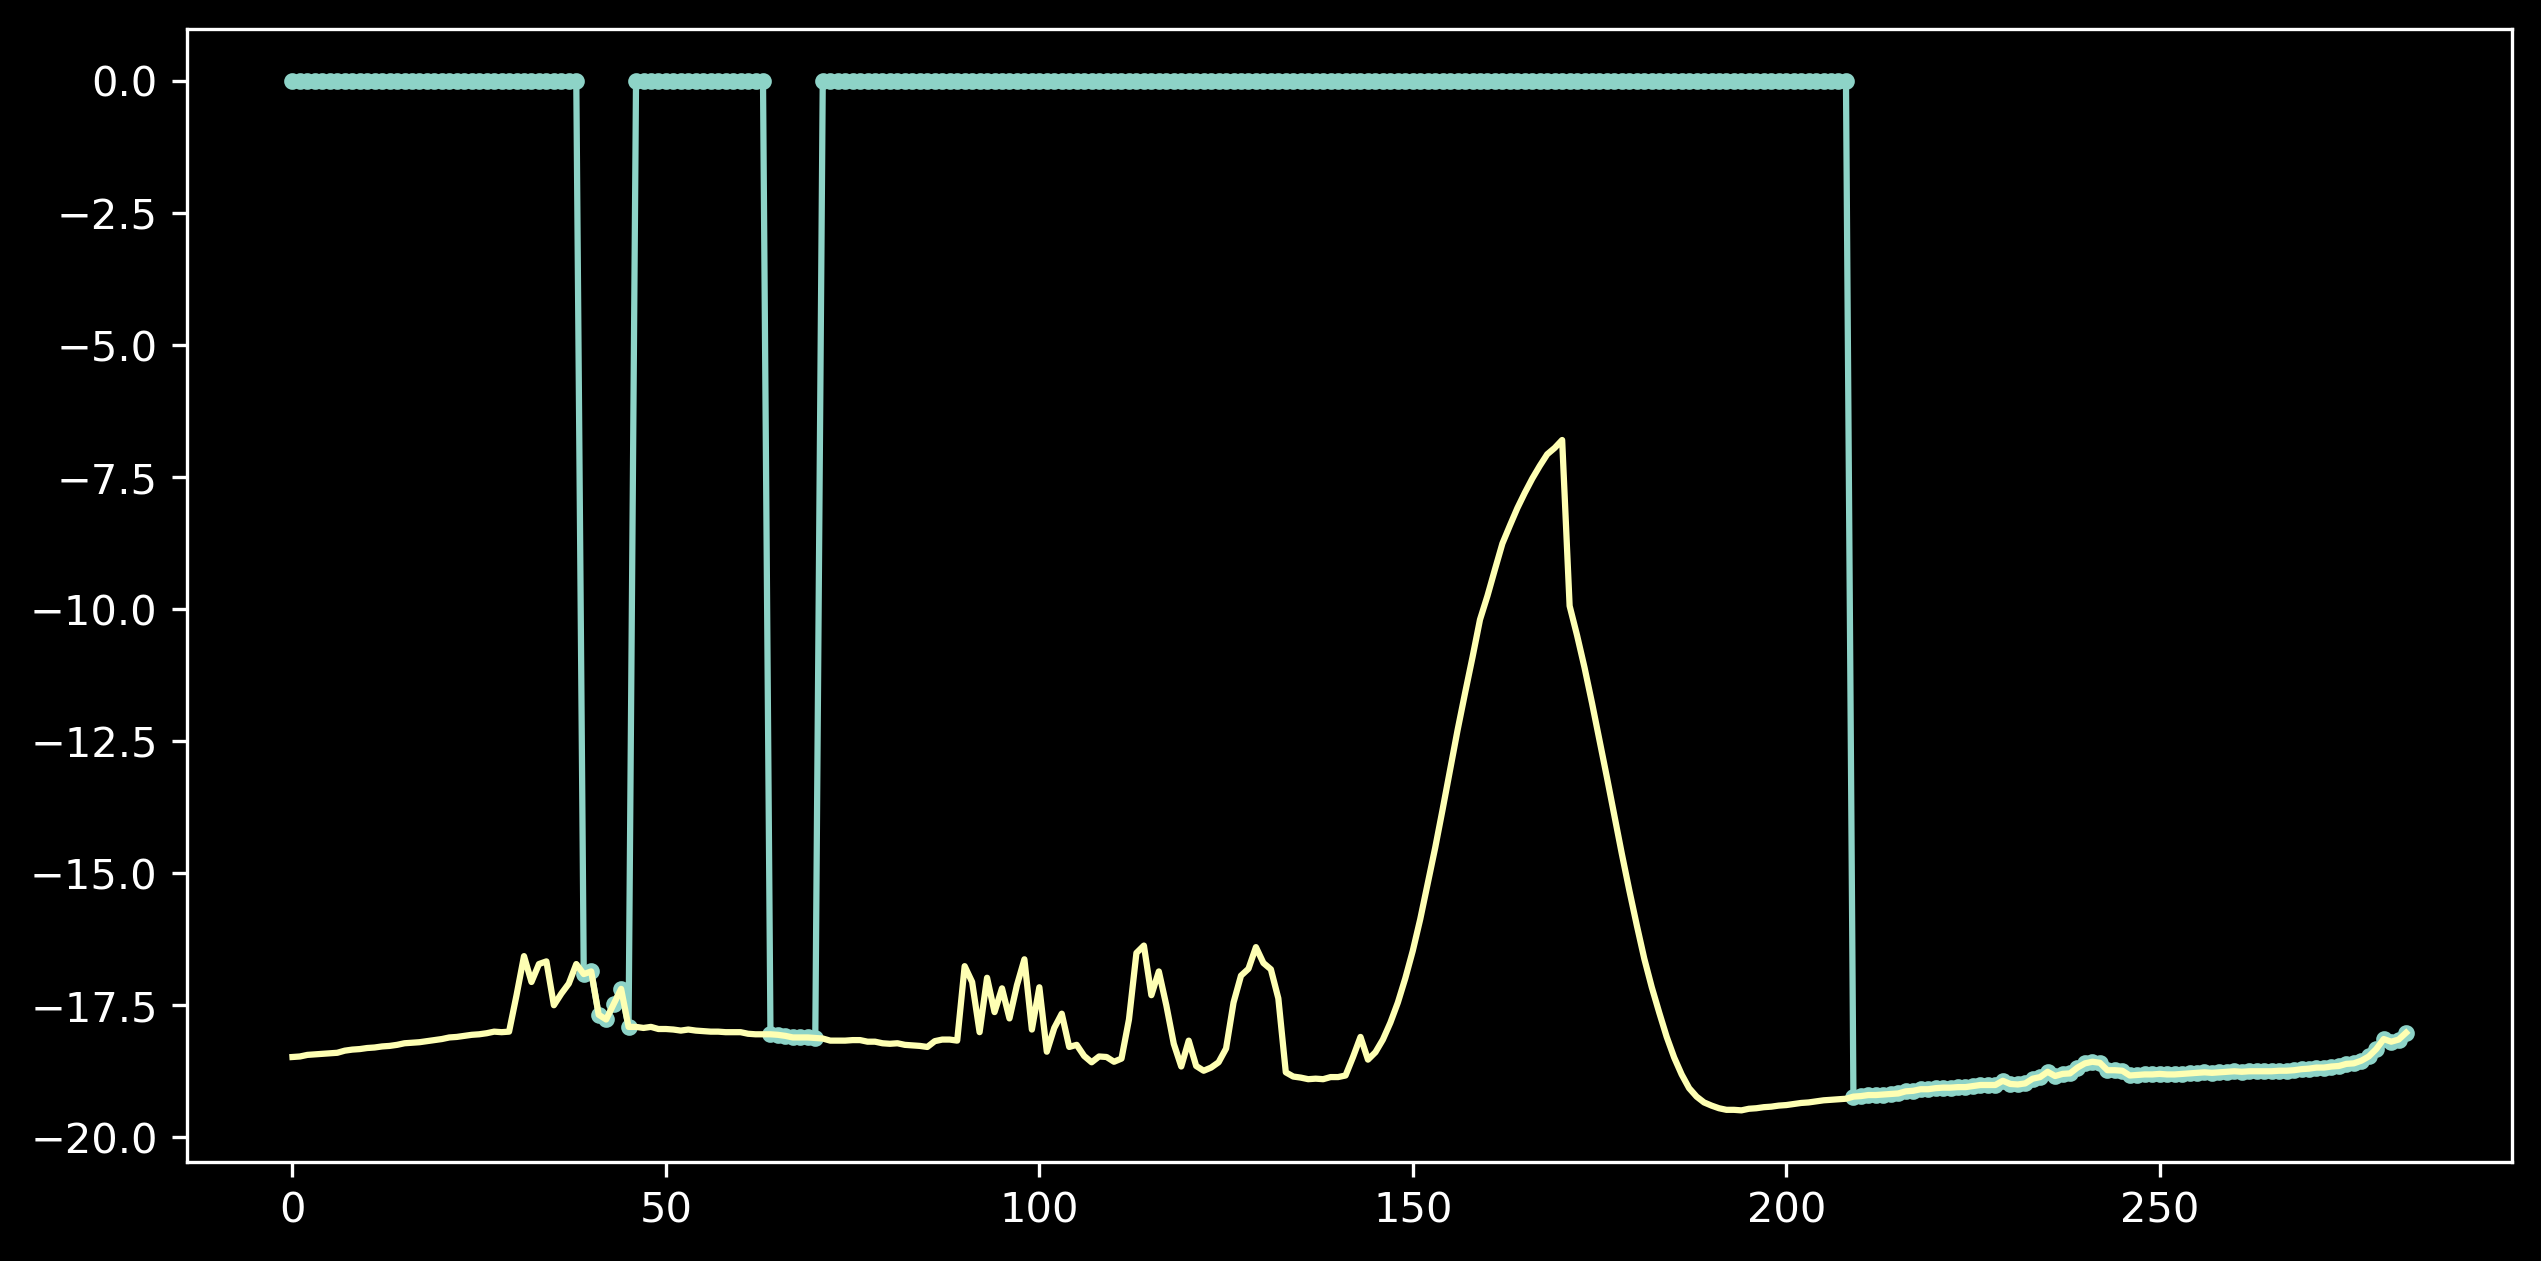

In [493]:
#COSQM Data cloud correction
##puts =0 cosqm value if clouds present, detected by variance higher than threshold on timely adjacent measurement values

def CloudCorr(cosqm_array, threshold, idx, idx_range):
    #check if data is at start or end of cosqm data, and correct range
    if idx<idx_range:
        left=0
        right=idx_range
    elif idx>len(cosqm_array)-idx_range-1:
        left=idx_range
        right=0
    else:
        left=int(idx_range/2)
        right=int(idx_range/2)
        
    #calculate variance of adjacent values
    var_val=var(cosqm_array[idx-left:idx+right])
    #print ('var:',var_val)
    #print ('vals:',cosqm_array[idx-left:idx+right])
    
    #put =0 if var bigger than threshold (clouds give a variance of approx 0.05mag)
    test=copy(cosqm_array)
    if var_val>threshold:
        test[idx]=0
        return test[idx]
    else: return cosqm_array[idx]
    
        
###Example
#load a day of cosqm and cloud screen all
for i in range (30):
    test=LoadData('/Users/admin/Documents/physique/Maitrise/hiver_2020/cosqm_aod/aod/cosqm_santa_cruz/data/2019/09/2019-09-15.txt')

test1=zeros(len(test[0][:,8]))
for i in range(len(test[0][:,8])):
    test1[i]=CloudCorr(test[0][:,8],0.1,i,50)

print(var(test1))
plot(-test1,'.-')
plot(-test[0][:,8])


In [363]:
###FIND CLOSEST TIME VALUES FROM AOD TO COSQM

#increments for months for computing seconds
days_per_month=[0,31,59,90,120,151,181,212,243,273,304,334]
    
#Define path from month and day of measurement on AOD
from IPython.display import display, clear_output
def FindClosest(array1,index):
    
    #define paths
    month=array1[0,index].month
    day=array1[0,index].day
    hour=array1[1,index].hour
        
    #make path string
    if day<9:
        pathstr='0'+str(day)
        if month<10:
            str_month='0'+str(month)
        else:
            str_month=str(month)
    elif day==9:
        pathstr=str(0)+str(day)
        if month<10:
            str_month='0'+str(month)
        else:
            str_month=str(month)
    else:
        pathstr=str(day)
        if month<10:
            str_month='0'+str(month)
        else:
            str_month=str(month)
            
    path=r'cosqm_izana/data/2019/'+str_month+'/2019-'+str_month+'-'+pathstr+'.txt'
    
    #Define time in seconds for AOD
    dates_aod_seconds=zeros(len(array1[1]))
    for i in range(len(array1[1])):
        dates_aod_seconds[i]=days_per_month[array1[0,i].month-1]*24*3600+(array1[0,i].day-1)*24*3600+array1[1,i].hour*3600+array1[1,i].minute*60+array1[1,i].second
    
    #Download data from this day (night)
    try:
        data,dates=LoadData(path)
        lenght=len(dates[:,0])-1
        dates_cosqm_seconds=zeros(lenght)
        for i in range(lenght):
            dates_cosqm_seconds[i]=days_per_month[dates[i,0].month-1]*24*3600+(array(dates[i,0].day)-1)*24*3600+dates[i,1].hour*3600+dates[i,1].minute*60+dates[i,1].second

        #find nearest time value for cosqm corresponding to aod measurement
        idx = abs(dates_cosqm_seconds-dates_aod_seconds[index]).argmin()    
        delta_t=dates_cosqm_seconds[idx]-dates_aod_seconds[index]
        i=index
        #print ('delta t= ',delta_t)
    
    except:
        delta_t=1001
        
    #correct for errors of time matching (range of 1000 difference to trigger)
    if -1000<delta_t<1000:
        cosqm_value1=data[idx]
        cosqm_value2=copy(cosqm_value1)
        
        #Cloud correction
        for i in range(5):
            cosqm_value2[i]=CloudCorr(data[:,6+i],0.005,idx,40)
    else: 
        cosqm_value2=array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

    return cosqm_value2, delta_t

In [420]:
#Load appropriate data from aod to corresponding cosqm values
start=5000
stop=11400

indexes=arange(start,stop)
cosqm_value=[]
delta_ts=[]

for i in indexes:
    data,delta_t=FindClosest(dates_aod,i)
    cosqm_value.append(data)
    delta_ts.append(delta_t)
    
cosqm_value=array(cosqm_value)

[ 119  171  252  466  575  703  832  944 1129 1151 1204 1335 1698 1793
 1929 2084 2221 2358 2477 2661 2687 2813 2926 3023 3083 3144 3291 3369
 3489 3606 3625 3816 3970 4268 4334 4508 4615 4695 5015 5034 5136 5252
 5382 5528 5796 5952 6021 6338]


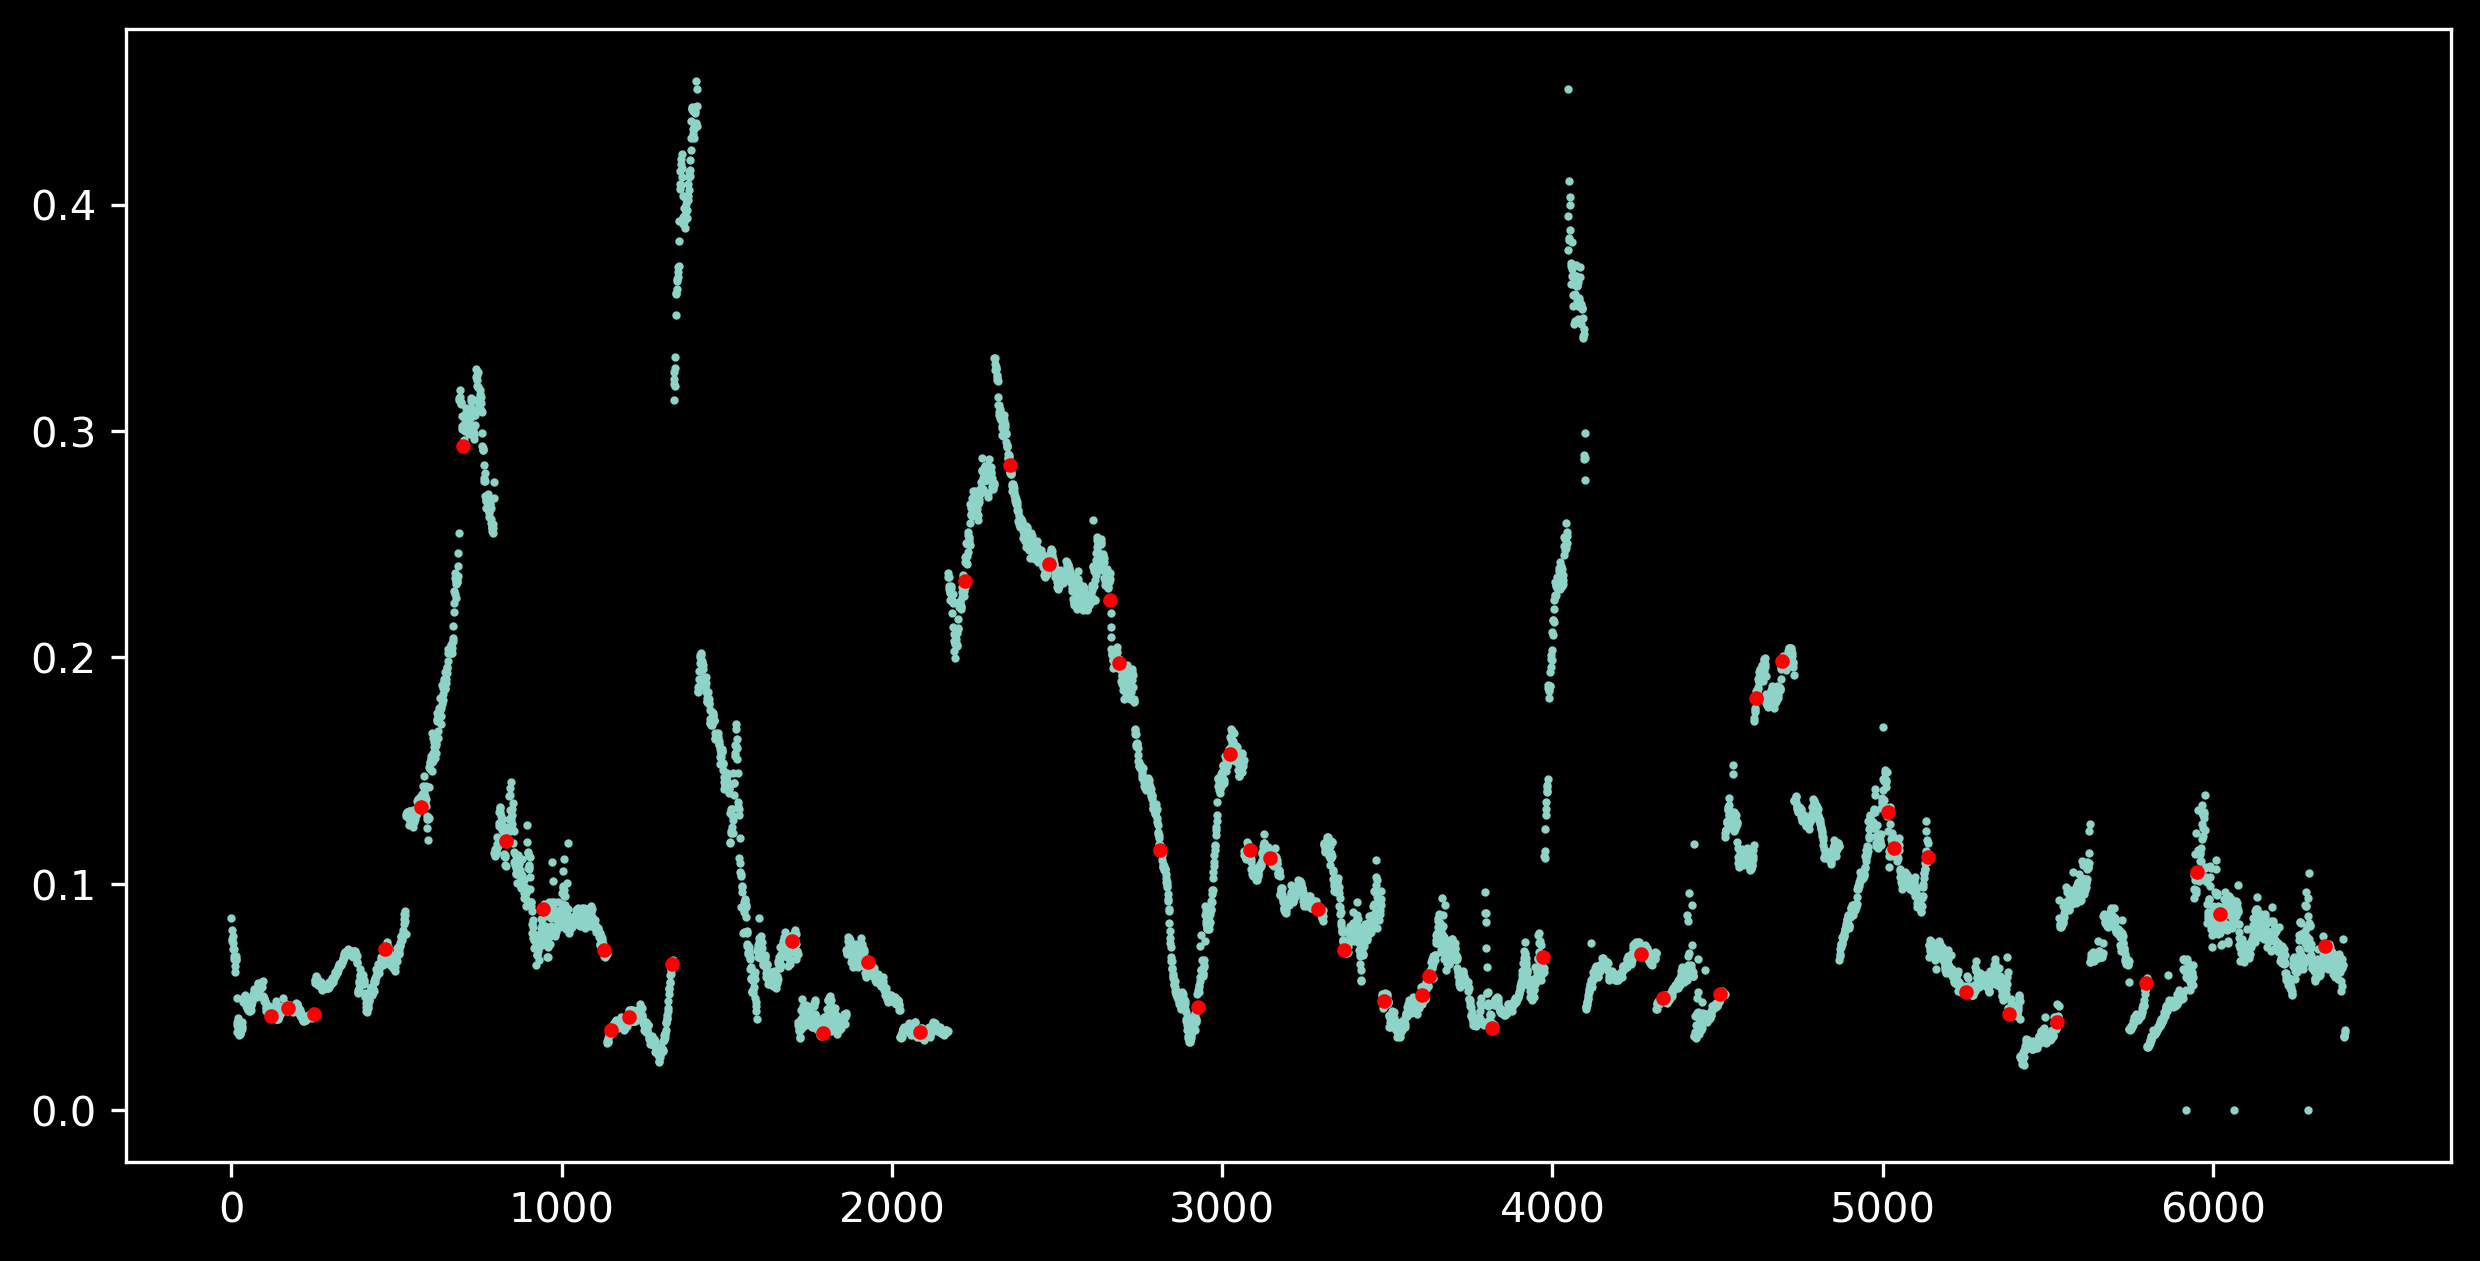

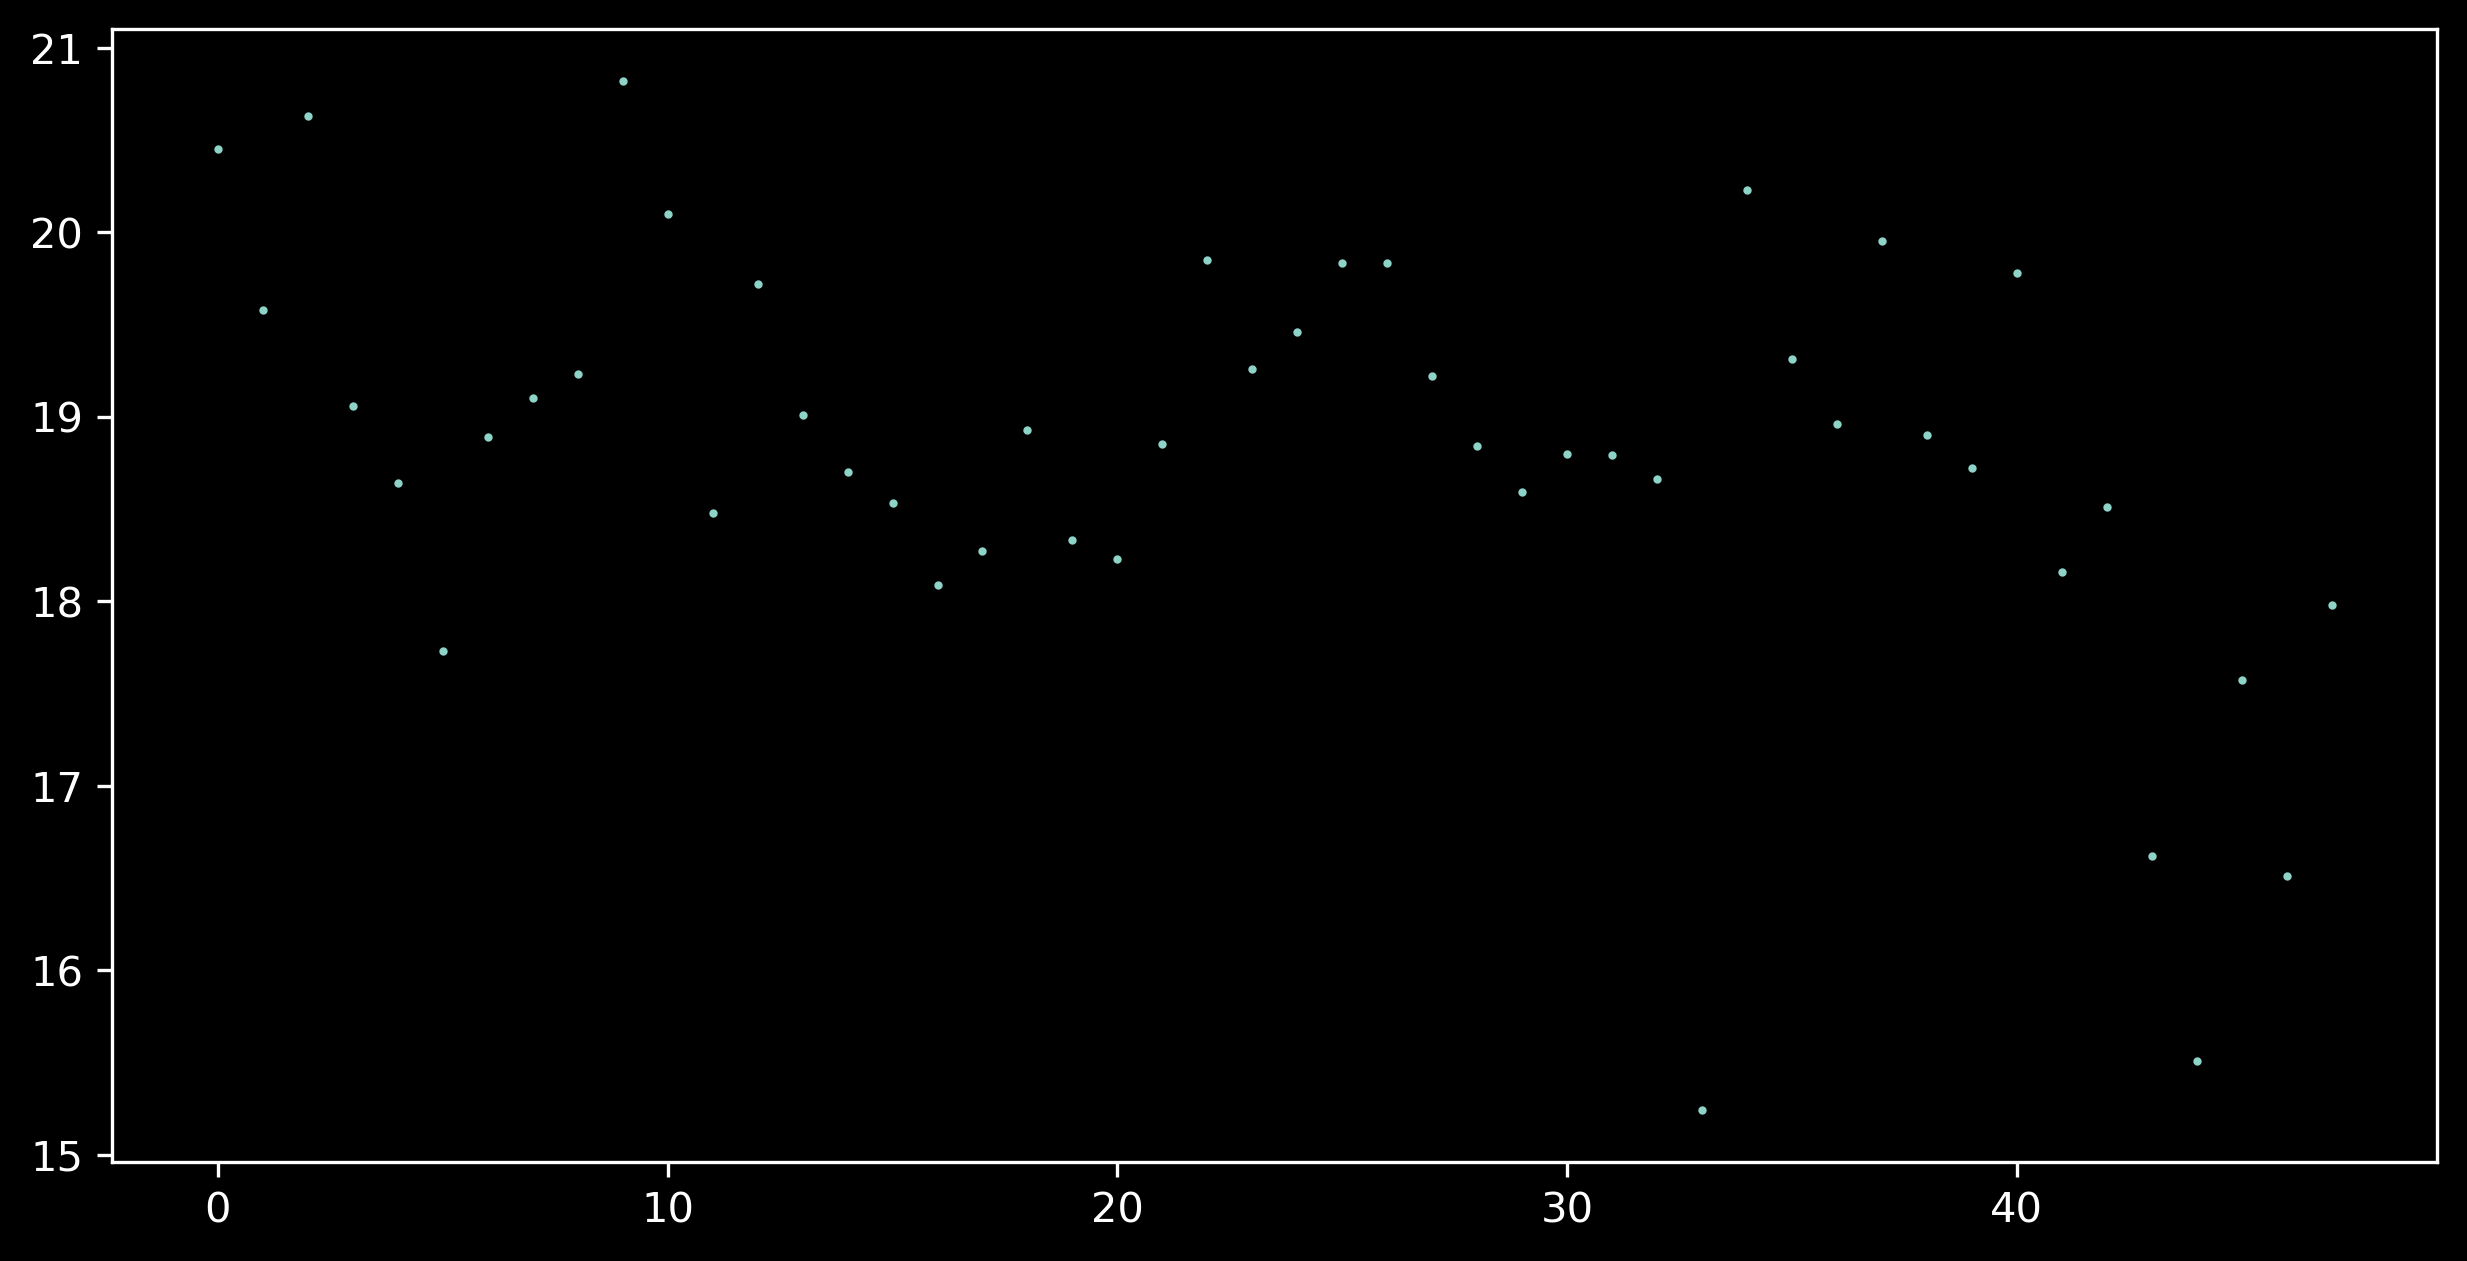

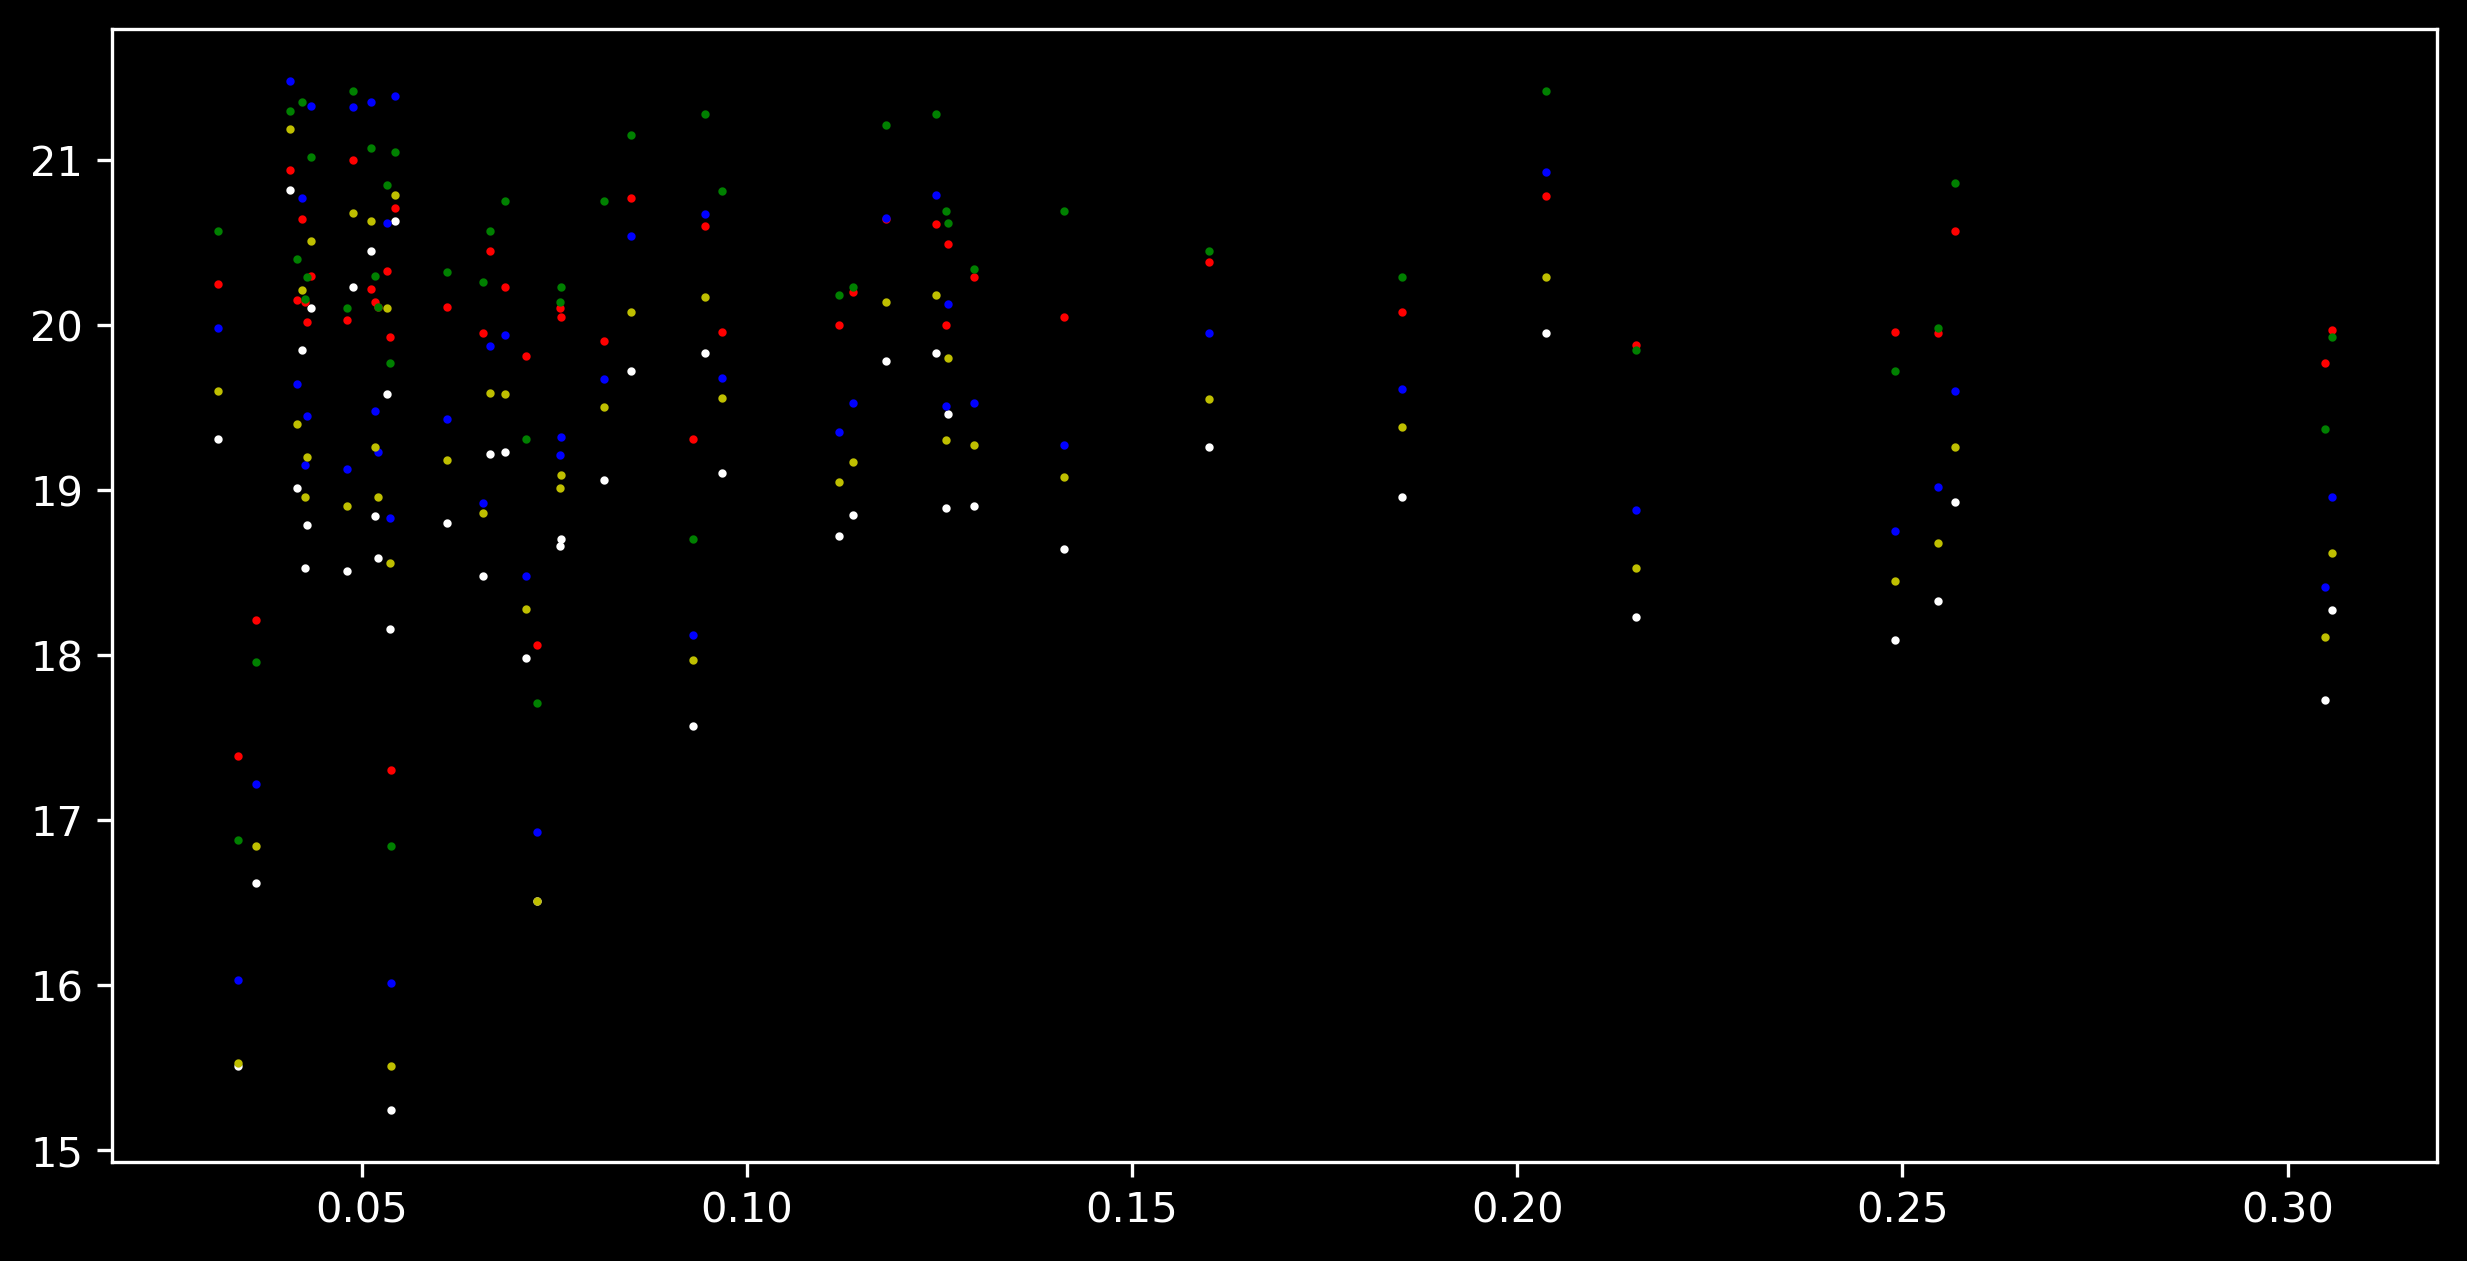

In [483]:
#Correction for moon rise and moon set (first and last values of aod recorded per night (day), going through midnight)
moonrise_idx=zeros(len(dates_aod[0]))

for i in range (len(dates_aod[0][start:stop])):
    hour1=dates_aod[1,i].hour
    hour2=dates_aod[1,i+1].hour
    if hour2-hour1>12:
        moonrise_idx[i]=i
    else:moonrise_idx[i]=0

moonrise_idx=array(nonzero(moonrise_idx)).astype(int)[0]
#cosqm_nonzero=array(nonzero(cosqm_value[moonrise_idx]))

plot_start=0
plot_end=6400
print(moonrise_idx)

figure()
plot(data_aod[start:stop,2],'.',markersize=2)
plot(moonrise_idx,data_aod[moonrise_idx+start,2],'.',color='r',markersize=5)
     
figure()
plot(cosqm_value[moonrise_idx,5],'.',markersize=2)    


figure()
plot(data_aod[moonrise_idx+start,5],cosqm_value[moonrise_idx,5],'.',markersize=2,color='w')
plot(data_aod[moonrise_idx+start,5],cosqm_value[moonrise_idx,6],'.',markersize=2,color='r')
plot(data_aod[moonrise_idx+start,5],cosqm_value[moonrise_idx,7],'.',markersize=2,color='g')
plot(data_aod[moonrise_idx+start,5],cosqm_value[moonrise_idx,8],'.',markersize=2,color='b')
plot(data_aod[moonrise_idx+start,5],cosqm_value[moonrise_idx,9],'.',markersize=2,color='y')

# IZANA

In [33]:
cols=arange(4, 26)

path='cosqm_izana/20190101_20191231_Izana.lev15'
header=7

#DATA
data_aod=genfromtxt(path, delimiter=',', skip_header=header, usecols=cols)

#remove negative values (-999) and set to 0
non_negs=data_aod>=0
data_aod=non_negs*data_aod

#DATES
dates_str=genfromtxt(path, delimiter=',', skip_header=header, usecols=[0,1], dtype=str)
dates_list=[datetime.strptime(dates, '%d:%m:%Y') for dates in dates_str[:,0]]
times_list=[datetime.strptime(dates, '%H:%M:%S') for dates in dates_str[:,1]]
dates_aod=array([dates_list,times_list])

#BANDS
bands_aod=genfromtxt(path, delimiter=',', skip_header=header-1, skip_footer=len(data_aod), usecols=cols, dtype=str)

#find which bands have no data (take mean of bands and find indices diff. than 0)
means=mean(data_aod, axis=0)
non_empty_aod=array(nonzero(means))

In [80]:
indexes=arange(6648,16000)
cosqm_value=[]
delta_ts=[]

for i in indexes:
    data_izana,delta_t=FindClosest(dates_aod,i)
    cosqm_value.append(data)
    delta_ts.append(delta_t)
    
izana_value=array(cosqm_value)

cosqm_izana/data/2019/05/2019-05-23.txt
AERONET:  10368000 1900800 0 900 45
COSQM:    10368000 1900800 0 840 59
12269745
AERONET month,day =  5 23
COSQM   month,day =  5 23
AERONET h:m:s =  0 15 45
COSQM   h:m:s =  0 14 59
idx= 91
delta t=  -46.0
----------------
cosqm_izana/data/2019/05/2019-05-23.txt
AERONET:  10368000 1900800 0 1080 45
COSQM:    10368000 1900800 0 1140 57
12269925
AERONET month,day =  5 23
COSQM   month,day =  5 23
AERONET h:m:s =  0 18 45
COSQM   h:m:s =  0 19 57
idx= 93
delta t=  72.0
----------------
cosqm_izana/data/2019/05/2019-05-23.txt
AERONET:  10368000 1900800 0 1260 45
COSQM:    10368000 1900800 0 1320 27
12270105
AERONET month,day =  5 23
COSQM   month,day =  5 23
AERONET h:m:s =  0 21 45
COSQM   h:m:s =  0 22 27
idx= 94
delta t=  42.0
----------------
cosqm_izana/data/2019/05/2019-05-23.txt
AERONET:  10368000 1900800 0 1440 45
COSQM:    10368000 1900800 0 1440 57
12270285
AERONET month,day =  5 23
COSQM   month,day =  5 23
AERONET h:m:s =  0 24 45
COSQM 

AERONET:  10368000 1900800 3600 3060 46
COSQM:    10368000 1900800 3600 3120 38
12275506
AERONET month,day =  5 23
COSQM   month,day =  5 23
AERONET h:m:s =  1 51 46
COSQM   h:m:s =  1 52 38
idx= 130
delta t=  52.0
----------------
cosqm_izana/data/2019/05/2019-05-23.txt
AERONET:  10368000 1900800 3600 3240 46
COSQM:    10368000 1900800 3600 3300 9
12275686
AERONET month,day =  5 23
COSQM   month,day =  5 23
AERONET h:m:s =  1 54 46
COSQM   h:m:s =  1 55 9
idx= 131
delta t=  23.0
----------------
cosqm_izana/data/2019/05/2019-05-23.txt
AERONET:  10368000 1900800 3600 3420 46
COSQM:    10368000 1900800 3600 3420 39
12275866
AERONET month,day =  5 23
COSQM   month,day =  5 23
AERONET h:m:s =  1 57 46
COSQM   h:m:s =  1 57 39
idx= 132
delta t=  -7.0
----------------
cosqm_izana/data/2019/05/2019-05-23.txt
AERONET:  10368000 1900800 7200 180 46
COSQM:    10368000 1900800 7200 120 38
12276226
AERONET month,day =  5 23
COSQM   month,day =  5 23
AERONET h:m:s =  2 3 46
COSQM   h:m:s =  2 2 38

AERONET:  10368000 1900800 10800 2160 46
COSQM:    10368000 1900800 10800 2220 45
12281806
AERONET month,day =  5 23
COSQM   month,day =  5 23
AERONET h:m:s =  3 36 46
COSQM   h:m:s =  3 37 45
idx= 172
delta t=  59.0
----------------
cosqm_izana/data/2019/05/2019-05-23.txt
AERONET:  10368000 1900800 10800 2340 46
COSQM:    10368000 1900800 10800 2400 16
12281986
AERONET month,day =  5 23
COSQM   month,day =  5 23
AERONET h:m:s =  3 39 46
COSQM   h:m:s =  3 40 16
idx= 173
delta t=  30.0
----------------
cosqm_izana/data/2019/05/2019-05-23.txt
AERONET:  10368000 1900800 10800 2520 46
COSQM:    10368000 1900800 10800 2520 45
12282166
AERONET month,day =  5 23
COSQM   month,day =  5 23
AERONET h:m:s =  3 42 46
COSQM   h:m:s =  3 42 45
idx= 174
delta t=  -1.0
----------------
cosqm_izana/data/2019/05/2019-05-23.txt
AERONET:  10368000 1900800 10800 2700 46
COSQM:    10368000 1900800 10800 2700 15
12282346
AERONET month,day =  5 23
COSQM   month,day =  5 23
AERONET h:m:s =  3 45 46
COSQM   h:

AERONET:  10368000 1900800 18000 900 46
COSQM:    10368000 1900800 18000 900 12
12287746
AERONET month,day =  5 23
COSQM   month,day =  5 23
AERONET h:m:s =  5 15 46
COSQM   h:m:s =  5 15 12
idx= 211
delta t=  -34.0
----------------
cosqm_izana/data/2019/05/2019-05-23.txt
AERONET:  10368000 1900800 18000 1080 46
COSQM:    10368000 1900800 18000 1020 42
12287926
AERONET month,day =  5 23
COSQM   month,day =  5 23
AERONET h:m:s =  5 18 46
COSQM   h:m:s =  5 17 42
idx= 212
delta t=  -64.0
----------------
cosqm_izana/data/2019/05/2019-05-23.txt
AERONET:  10368000 1900800 18000 1260 46
COSQM:    10368000 1900800 18000 1200 12
12288106
AERONET month,day =  5 23
COSQM   month,day =  5 23
AERONET h:m:s =  5 21 46
COSQM   h:m:s =  5 20 12
idx= 213
delta t=  -94.0
----------------
cosqm_izana/data/2019/05/2019-05-23.txt
AERONET:  10368000 1900800 18000 1440 46
COSQM:    10368000 1900800 18000 1200 12
12288286
AERONET month,day =  5 23
COSQM   month,day =  5 23
AERONET h:m:s =  5 24 46
COSQM   h

AERONET:  10368000 1987200 7200 900 46
COSQM:    10368000 1987200 0 240 23
12363346
AERONET month,day =  5 24
COSQM   month,day =  5 24
AERONET h:m:s =  2 15 46
COSQM   h:m:s =  0 4 23
idx= 94
delta t=  -7883.0
----------------
cosqm_izana/data/2019/05/2019-05-24.txt
AERONET:  10368000 1987200 7200 1080 46
COSQM:    10368000 1987200 0 240 23
12363526
AERONET month,day =  5 24
COSQM   month,day =  5 24
AERONET h:m:s =  2 18 46
COSQM   h:m:s =  0 4 23
idx= 94
delta t=  -8063.0
----------------
cosqm_izana/data/2019/05/2019-05-24.txt
AERONET:  10368000 1987200 7200 1260 46
COSQM:    10368000 1987200 0 240 23
12363706
AERONET month,day =  5 24
COSQM   month,day =  5 24
AERONET h:m:s =  2 21 46
COSQM   h:m:s =  0 4 23
idx= 94
delta t=  -8243.0
----------------
cosqm_izana/data/2019/05/2019-05-24.txt
AERONET:  10368000 1987200 7200 1440 46
COSQM:    10368000 1987200 0 240 23
12363886
AERONET month,day =  5 24
COSQM   month,day =  5 24
AERONET h:m:s =  2 24 46
COSQM   h:m:s =  0 4 23
idx= 94


COSQM:    10368000 1987200 0 240 23
12369646
AERONET month,day =  5 24
COSQM   month,day =  5 24
AERONET h:m:s =  4 0 46
COSQM   h:m:s =  0 4 23
idx= 94
delta t=  -14183.0
----------------
cosqm_izana/data/2019/05/2019-05-24.txt
AERONET:  10368000 1987200 14400 180 46
COSQM:    10368000 1987200 0 240 23
12369826
AERONET month,day =  5 24
COSQM   month,day =  5 24
AERONET h:m:s =  4 3 46
COSQM   h:m:s =  0 4 23
idx= 94
delta t=  -14363.0
----------------
cosqm_izana/data/2019/05/2019-05-24.txt
AERONET:  10368000 1987200 14400 360 46
COSQM:    10368000 1987200 0 240 23
12370006
AERONET month,day =  5 24
COSQM   month,day =  5 24
AERONET h:m:s =  4 6 46
COSQM   h:m:s =  0 4 23
idx= 94
delta t=  -14543.0
----------------
cosqm_izana/data/2019/05/2019-05-24.txt
AERONET:  10368000 1987200 14400 540 46
COSQM:    10368000 1987200 0 240 23
12370186
AERONET month,day =  5 24
COSQM   month,day =  5 24
AERONET h:m:s =  4 9 46
COSQM   h:m:s =  0 4 23
idx= 94
delta t=  -14723.0
----------------
cosq

AERONET:  10368000 2073600 3600 2880 45
COSQM:    10368000 2073600 3600 2940 15
12448125
AERONET month,day =  5 25
COSQM   month,day =  5 25
AERONET h:m:s =  1 48 45
COSQM   h:m:s =  1 49 15
idx= 78
delta t=  30.0
----------------
cosqm_izana/data/2019/05/2019-05-25.txt
AERONET:  10368000 2073600 3600 3060 45
COSQM:    10368000 2073600 3600 3060 45
12448305
AERONET month,day =  5 25
COSQM   month,day =  5 25
AERONET h:m:s =  1 51 45
COSQM   h:m:s =  1 51 45
idx= 79
delta t=  0.0
----------------
cosqm_izana/data/2019/05/2019-05-25.txt
AERONET:  10368000 2073600 3600 3240 45
COSQM:    10368000 2073600 3600 3240 14
12448485
AERONET month,day =  5 25
COSQM   month,day =  5 25
AERONET h:m:s =  1 54 45
COSQM   h:m:s =  1 54 14
idx= 80
delta t=  -31.0
----------------
cosqm_izana/data/2019/05/2019-05-25.txt
AERONET:  10368000 2073600 3600 3420 45
COSQM:    10368000 2073600 3600 3360 44
12448665
AERONET month,day =  5 25
COSQM   month,day =  5 25
AERONET h:m:s =  1 57 45
COSQM   h:m:s =  1 56

COSQM   month,day =  5 25
AERONET h:m:s =  3 21 46
COSQM   h:m:s =  3 22 47
idx= 115
delta t=  61.0
----------------
cosqm_izana/data/2019/05/2019-05-25.txt
AERONET:  10368000 2073600 10800 1440 46
COSQM:    10368000 2073600 10800 1500 16
12453886
AERONET month,day =  5 25
COSQM   month,day =  5 25
AERONET h:m:s =  3 24 46
COSQM   h:m:s =  3 25 16
idx= 116
delta t=  30.0
----------------
cosqm_izana/data/2019/05/2019-05-25.txt
AERONET:  10368000 2073600 10800 1620 46
COSQM:    10368000 2073600 10800 1620 46
12454066
AERONET month,day =  5 25
COSQM   month,day =  5 25
AERONET h:m:s =  3 27 46
COSQM   h:m:s =  3 27 46
idx= 117
delta t=  0.0
----------------
cosqm_izana/data/2019/05/2019-05-25.txt
AERONET:  10368000 2073600 10800 1800 46
COSQM:    10368000 2073600 10800 1800 15
12454246
AERONET month,day =  5 25
COSQM   month,day =  5 25
AERONET h:m:s =  3 30 46
COSQM   h:m:s =  3 30 15
idx= 118
delta t=  -31.0
----------------
cosqm_izana/data/2019/05/2019-05-25.txt
AERONET:  10368000 20

AERONET month,day =  5 25
COSQM   month,day =  5 25
AERONET h:m:s =  4 57 46
COSQM   h:m:s =  4 57 36
idx= 153
delta t=  -10.0
----------------
cosqm_izana/data/2019/05/2019-05-25.txt
AERONET:  10368000 2073600 18000 0 46
COSQM:    10368000 2073600 18000 0 6
12459646
AERONET month,day =  5 25
COSQM   month,day =  5 25
AERONET h:m:s =  5 0 46
COSQM   h:m:s =  5 0 6
idx= 154
delta t=  -40.0
----------------
cosqm_izana/data/2019/05/2019-05-25.txt
AERONET:  10368000 2073600 18000 180 46
COSQM:    10368000 2073600 18000 120 36
12459826
AERONET month,day =  5 25
COSQM   month,day =  5 25
AERONET h:m:s =  5 3 46
COSQM   h:m:s =  5 2 36
idx= 155
delta t=  -70.0
----------------
cosqm_izana/data/2019/05/2019-05-25.txt
AERONET:  10368000 2073600 18000 360 46
COSQM:    10368000 2073600 18000 420 35
12460006
AERONET month,day =  5 25
COSQM   month,day =  5 25
AERONET h:m:s =  5 6 46
COSQM   h:m:s =  5 7 35
idx= 157
delta t=  49.0
----------------
cosqm_izana/data/2019/05/2019-05-25.txt
AERONET:  

AERONET h:m:s =  3 9 45
COSQM   h:m:s =  6 25 46
idx= 0
delta t=  11761.0
----------------
cosqm_izana/data/2019/05/2019-05-26.txt
AERONET:  10368000 2160000 10800 720 46
COSQM:    10368000 2160000 21600 1500 46
12539566
AERONET month,day =  5 26
COSQM   month,day =  5 26
AERONET h:m:s =  3 12 46
COSQM   h:m:s =  6 25 46
idx= 0
delta t=  11580.0
----------------
cosqm_izana/data/2019/05/2019-05-26.txt
AERONET:  10368000 2160000 10800 900 46
COSQM:    10368000 2160000 21600 1500 46
12539746
AERONET month,day =  5 26
COSQM   month,day =  5 26
AERONET h:m:s =  3 15 46
COSQM   h:m:s =  6 25 46
idx= 0
delta t=  11400.0
----------------
cosqm_izana/data/2019/05/2019-05-26.txt
AERONET:  10368000 2160000 10800 1080 46
COSQM:    10368000 2160000 21600 1500 46
12539926
AERONET month,day =  5 26
COSQM   month,day =  5 26
AERONET h:m:s =  3 18 46
COSQM   h:m:s =  6 25 46
idx= 0
delta t=  11220.0
----------------
cosqm_izana/data/2019/05/2019-05-26.txt
AERONET:  10368000 2160000 10800 1260 46
COSQM

delta t=  6000.0
----------------
cosqm_izana/data/2019/05/2019-05-26.txt
AERONET:  10368000 2160000 14400 2880 46
COSQM:    10368000 2160000 21600 1500 46
12545326
AERONET month,day =  5 26
COSQM   month,day =  5 26
AERONET h:m:s =  4 48 46
COSQM   h:m:s =  6 25 46
idx= 0
delta t=  5820.0
----------------
cosqm_izana/data/2019/05/2019-05-26.txt
AERONET:  10368000 2160000 14400 3240 46
COSQM:    10368000 2160000 21600 1500 46
12545686
AERONET month,day =  5 26
COSQM   month,day =  5 26
AERONET h:m:s =  4 54 46
COSQM   h:m:s =  6 25 46
idx= 0
delta t=  5460.0
----------------
cosqm_izana/data/2019/05/2019-05-26.txt
AERONET:  10368000 2160000 18000 180 46
COSQM:    10368000 2160000 21600 1500 46
12546226
AERONET month,day =  5 26
COSQM   month,day =  5 26
AERONET h:m:s =  5 3 46
COSQM   h:m:s =  6 25 46
idx= 0
delta t=  4920.0
----------------
cosqm_izana/data/2019/05/2019-05-26.txt
AERONET:  10368000 2160000 18000 360 46
COSQM:    10368000 2160000 21600 1500 46
12546406
AERONET month,da

COSQM   month,day =  6 12
AERONET h:m:s =  0 0 46
COSQM   h:m:s =  9 31 0
idx= 0
delta t=  34214.0
----------------
cosqm_izana/data/2019/06/2019-06-12.txt
AERONET:  13046400 950400 0 180 46
COSQM:    13046400 950400 32400 1860 0
13997026
AERONET month,day =  6 12
COSQM   month,day =  6 12
AERONET h:m:s =  0 3 46
COSQM   h:m:s =  9 31 0
idx= 0
delta t=  34034.0
----------------
cosqm_izana/data/2019/06/2019-06-12.txt
AERONET:  13046400 950400 0 360 46
COSQM:    13046400 950400 32400 1860 0
13997206
AERONET month,day =  6 12
COSQM   month,day =  6 12
AERONET h:m:s =  0 6 46
COSQM   h:m:s =  9 31 0
idx= 0
delta t=  33854.0
----------------
cosqm_izana/data/2019/06/2019-06-12.txt
AERONET:  13046400 950400 0 540 46
COSQM:    13046400 950400 32400 1860 0
13997386
AERONET month,day =  6 12
COSQM   month,day =  6 12
AERONET h:m:s =  0 9 46
COSQM   h:m:s =  9 31 0
idx= 0
delta t=  33674.0
----------------
cosqm_izana/data/2019/06/2019-06-12.txt
AERONET:  13046400 950400 0 720 46
COSQM:    1304

AERONET:  13046400 950400 3600 2700 45
COSQM:    13046400 950400 32400 1860 0
14003145
AERONET month,day =  6 12
COSQM   month,day =  6 12
AERONET h:m:s =  1 45 45
COSQM   h:m:s =  9 31 0
idx= 0
delta t=  27915.0
----------------
cosqm_izana/data/2019/06/2019-06-12.txt
AERONET:  13046400 950400 3600 2880 45
COSQM:    13046400 950400 32400 1860 0
14003325
AERONET month,day =  6 12
COSQM   month,day =  6 12
AERONET h:m:s =  1 48 45
COSQM   h:m:s =  9 31 0
idx= 0
delta t=  27735.0
----------------
cosqm_izana/data/2019/06/2019-06-12.txt
AERONET:  13046400 950400 3600 3060 45
COSQM:    13046400 950400 32400 1860 0
14003505
AERONET month,day =  6 12
COSQM   month,day =  6 12
AERONET h:m:s =  1 51 45
COSQM   h:m:s =  9 31 0
idx= 0
delta t=  27555.0
----------------
cosqm_izana/data/2019/06/2019-06-12.txt
AERONET:  13046400 950400 3600 3240 45
COSQM:    13046400 950400 32400 1860 0
14003685
AERONET month,day =  6 12
COSQM   month,day =  6 12
AERONET h:m:s =  1 54 45
COSQM   h:m:s =  9 31 0
id

AERONET:  13046400 950400 79200 180 47
COSQM:    13046400 950400 79200 240 0
14076227
AERONET month,day =  6 12
COSQM   month,day =  6 12
AERONET h:m:s =  22 3 47
COSQM   h:m:s =  22 4 0
idx= 49
delta t=  13.0
----------------
cosqm_izana/data/2019/06/2019-06-12.txt
AERONET:  13046400 950400 79200 360 47
COSQM:    13046400 950400 79200 360 29
14076407
AERONET month,day =  6 12
COSQM   month,day =  6 12
AERONET h:m:s =  22 6 47
COSQM   h:m:s =  22 6 29
idx= 50
delta t=  -18.0
----------------
cosqm_izana/data/2019/06/2019-06-12.txt
AERONET:  13046400 950400 79200 540 47
COSQM:    13046400 950400 79200 480 59
14076587
AERONET month,day =  6 12
COSQM   month,day =  6 12
AERONET h:m:s =  22 9 47
COSQM   h:m:s =  22 8 59
idx= 51
delta t=  -48.0
----------------
cosqm_izana/data/2019/06/2019-06-12.txt
AERONET:  13046400 950400 79200 720 47
COSQM:    13046400 950400 79200 780 59
14076767
AERONET month,day =  6 12
COSQM   month,day =  6 12
AERONET h:m:s =  22 12 47
COSQM   h:m:s =  22 13 59
id

AERONET:  13046400 950400 82800 2880 46
COSQM:    13046400 950400 82800 2940 1
14082526
AERONET month,day =  6 12
COSQM   month,day =  6 12
AERONET h:m:s =  23 48 46
COSQM   h:m:s =  23 49 1
idx= 91
delta t=  15.0
----------------
cosqm_izana/data/2019/06/2019-06-12.txt
AERONET:  13046400 950400 82800 3060 46
COSQM:    13046400 950400 82800 3060 31
14082706
AERONET month,day =  6 12
COSQM   month,day =  6 12
AERONET h:m:s =  23 51 46
COSQM   h:m:s =  23 51 31
idx= 92
delta t=  -15.0
----------------
cosqm_izana/data/2019/06/2019-06-12.txt
AERONET:  13046400 950400 82800 3240 46
COSQM:    13046400 950400 82800 3240 1
14082886
AERONET month,day =  6 12
COSQM   month,day =  6 12
AERONET h:m:s =  23 54 46
COSQM   h:m:s =  23 54 1
idx= 93
delta t=  -45.0
----------------
cosqm_izana/data/2019/06/2019-06-12.txt
AERONET:  13046400 950400 82800 3420 46
COSQM:    13046400 950400 82800 3360 32
14083066
AERONET month,day =  6 12
COSQM   month,day =  6 12
AERONET h:m:s =  23 57 46
COSQM   h:m:s = 

AERONET:  13046400 1036800 3600 1260 46
COSQM:    13046400 1036800 3600 1260 34
14088106
AERONET month,day =  6 13
COSQM   month,day =  6 13
AERONET h:m:s =  1 21 46
COSQM   h:m:s =  1 21 34
idx= 32
delta t=  -12.0
----------------
cosqm_izana/data/2019/06/2019-06-13.txt
AERONET:  13046400 1036800 3600 1440 46
COSQM:    13046400 1036800 3600 1440 5
14088286
AERONET month,day =  6 13
COSQM   month,day =  6 13
AERONET h:m:s =  1 24 46
COSQM   h:m:s =  1 24 5
idx= 33
delta t=  -41.0
----------------
cosqm_izana/data/2019/06/2019-06-13.txt
AERONET:  13046400 1036800 3600 1620 46
COSQM:    13046400 1036800 3600 1560 36
14088466
AERONET month,day =  6 13
COSQM   month,day =  6 13
AERONET h:m:s =  1 27 46
COSQM   h:m:s =  1 26 36
idx= 34
delta t=  -70.0
----------------
cosqm_izana/data/2019/06/2019-06-13.txt
AERONET:  13046400 1036800 3600 1800 46
COSQM:    13046400 1036800 3600 1860 36
14088646
AERONET month,day =  6 13
COSQM   month,day =  6 13
AERONET h:m:s =  1 30 46
COSQM   h:m:s =  1 3

AERONET h:m:s =  21 15 47
COSQM   h:m:s =  21 15 16
idx= 169
delta t=  -31.0
----------------
cosqm_izana/data/2019/06/2019-06-13.txt
AERONET:  13046400 1036800 75600 1080 47
COSQM:    13046400 1036800 75600 1020 46
14159927
AERONET month,day =  6 13
COSQM   month,day =  6 13
AERONET h:m:s =  21 18 47
COSQM   h:m:s =  21 17 46
idx= 170
delta t=  -61.0
----------------
cosqm_izana/data/2019/06/2019-06-13.txt
AERONET:  13046400 1036800 75600 1260 47
COSQM:    13046400 1036800 75600 1320 45
14160107
AERONET month,day =  6 13
COSQM   month,day =  6 13
AERONET h:m:s =  21 21 47
COSQM   h:m:s =  21 22 45
idx= 172
delta t=  58.0
----------------
cosqm_izana/data/2019/06/2019-06-13.txt
AERONET:  13046400 1036800 75600 1440 47
COSQM:    13046400 1036800 75600 1500 16
14160287
AERONET month,day =  6 13
COSQM   month,day =  6 13
AERONET h:m:s =  21 24 47
COSQM   h:m:s =  21 25 16
idx= 173
delta t=  29.0
----------------
cosqm_izana/data/2019/06/2019-06-13.txt
AERONET:  13046400 1036800 75600 1620

AERONET:  13046400 1036800 82800 180 47
COSQM:    13046400 1036800 82800 120 47
14166227
AERONET month,day =  6 13
COSQM   month,day =  6 13
AERONET h:m:s =  23 3 47
COSQM   h:m:s =  23 2 47
idx= 212
delta t=  -60.0
----------------
cosqm_izana/data/2019/06/2019-06-13.txt
AERONET:  13046400 1036800 82800 360 47
COSQM:    13046400 1036800 82800 420 46
14166407
AERONET month,day =  6 13
COSQM   month,day =  6 13
AERONET h:m:s =  23 6 47
COSQM   h:m:s =  23 7 46
idx= 214
delta t=  59.0
----------------
cosqm_izana/data/2019/06/2019-06-13.txt
AERONET:  13046400 1036800 82800 540 47
COSQM:    13046400 1036800 82800 600 16
14166587
AERONET month,day =  6 13
COSQM   month,day =  6 13
AERONET h:m:s =  23 9 47
COSQM   h:m:s =  23 10 16
idx= 215
delta t=  29.0
----------------
cosqm_izana/data/2019/06/2019-06-13.txt
AERONET:  13046400 1036800 82800 720 47
COSQM:    13046400 1036800 82800 720 46
14166767
AERONET month,day =  6 13
COSQM   month,day =  6 13
AERONET h:m:s =  23 12 47
COSQM   h:m:s =

AERONET:  13046400 1123200 0 3240 46
COSQM:    13046400 1123200 0 3300 21
14172886
AERONET month,day =  6 14
COSQM   month,day =  6 14
AERONET h:m:s =  0 54 46
COSQM   h:m:s =  0 55 21
idx= 22
delta t=  35.0
----------------
cosqm_izana/data/2019/06/2019-06-14.txt
AERONET:  13046400 1123200 0 3420 46
COSQM:    13046400 1123200 0 3420 51
14173066
AERONET month,day =  6 14
COSQM   month,day =  6 14
AERONET h:m:s =  0 57 46
COSQM   h:m:s =  0 57 51
idx= 23
delta t=  5.0
----------------
cosqm_izana/data/2019/06/2019-06-14.txt
AERONET:  13046400 1123200 3600 0 46
COSQM:    13046400 1123200 3600 0 22
14173246
AERONET month,day =  6 14
COSQM   month,day =  6 14
AERONET h:m:s =  1 0 46
COSQM   h:m:s =  1 0 22
idx= 24
delta t=  -24.0
----------------
cosqm_izana/data/2019/06/2019-06-14.txt
AERONET:  13046400 1123200 3600 180 46
COSQM:    13046400 1123200 3600 120 51
14173426
AERONET month,day =  6 14
COSQM   month,day =  6 14
AERONET h:m:s =  1 3 46
COSQM   h:m:s =  1 2 51
idx= 25
delta t=  -5

AERONET:  13046400 1123200 7200 2160 45
COSQM:    13046400 1123200 7200 2220 53
14179005
AERONET month,day =  6 14
COSQM   month,day =  6 14
AERONET h:m:s =  2 36 45
COSQM   h:m:s =  2 37 53
idx= 63
delta t=  68.0
----------------
cosqm_izana/data/2019/06/2019-06-14.txt
AERONET:  13046400 1123200 7200 2340 45
COSQM:    13046400 1123200 7200 2400 23
14179185
AERONET month,day =  6 14
COSQM   month,day =  6 14
AERONET h:m:s =  2 39 45
COSQM   h:m:s =  2 40 23
idx= 64
delta t=  38.0
----------------
cosqm_izana/data/2019/06/2019-06-14.txt
AERONET:  13046400 1123200 7200 2520 45
COSQM:    13046400 1123200 7200 2520 53
14179365
AERONET month,day =  6 14
COSQM   month,day =  6 14
AERONET h:m:s =  2 42 45
COSQM   h:m:s =  2 42 53
idx= 65
delta t=  8.0
----------------
cosqm_izana/data/2019/06/2019-06-14.txt
AERONET:  13046400 1123200 7200 2700 45
COSQM:    13046400 1123200 7200 2700 24
14179545
AERONET month,day =  6 14
COSQM   month,day =  6 14
AERONET h:m:s =  2 45 45
COSQM   h:m:s =  2 45 

AERONET h:m:s =  21 33 46
COSQM   h:m:s =  21 33 47
idx= 176
delta t=  1.0
----------------
cosqm_izana/data/2019/06/2019-06-14.txt
AERONET:  13046400 1123200 75600 2160 46
COSQM:    13046400 1123200 75600 2160 18
14247406
AERONET month,day =  6 14
COSQM   month,day =  6 14
AERONET h:m:s =  21 36 46
COSQM   h:m:s =  21 36 18
idx= 177
delta t=  -28.0
----------------
cosqm_izana/data/2019/06/2019-06-14.txt
AERONET:  13046400 1123200 75600 2340 46
COSQM:    13046400 1123200 75600 2280 48
14247586
AERONET month,day =  6 14
COSQM   month,day =  6 14
AERONET h:m:s =  21 39 46
COSQM   h:m:s =  21 38 48
idx= 178
delta t=  -58.0
----------------
cosqm_izana/data/2019/06/2019-06-14.txt
AERONET:  13046400 1123200 75600 2520 46
COSQM:    13046400 1123200 75600 2580 48
14247766
AERONET month,day =  6 14
COSQM   month,day =  6 14
AERONET h:m:s =  21 42 46
COSQM   h:m:s =  21 43 48
idx= 180
delta t=  62.0
----------------
cosqm_izana/data/2019/06/2019-06-14.txt
AERONET:  13046400 1123200 75600 2700 

idx= 214
delta t=  -59.0
----------------
cosqm_izana/data/2019/06/2019-06-14.txt
AERONET:  13046400 1123200 82800 720 47
COSQM:    13046400 1123200 82800 780 49
14253167
AERONET month,day =  6 14
COSQM   month,day =  6 14
AERONET h:m:s =  23 12 47
COSQM   h:m:s =  23 13 49
idx= 216
delta t=  62.0
----------------
cosqm_izana/data/2019/06/2019-06-14.txt
AERONET:  13046400 1123200 82800 900 47
COSQM:    13046400 1123200 82800 960 18
14253347
AERONET month,day =  6 14
COSQM   month,day =  6 14
AERONET h:m:s =  23 15 47
COSQM   h:m:s =  23 16 18
idx= 217
delta t=  31.0
----------------
cosqm_izana/data/2019/06/2019-06-14.txt
AERONET:  13046400 1123200 82800 1080 47
COSQM:    13046400 1123200 82800 1080 48
14253527
AERONET month,day =  6 14
COSQM   month,day =  6 14
AERONET h:m:s =  23 18 47
COSQM   h:m:s =  23 18 48
idx= 218
delta t=  1.0
----------------
cosqm_izana/data/2019/06/2019-06-14.txt
AERONET:  13046400 1123200 82800 1260 47
COSQM:    13046400 1123200 82800 1260 19
14253707
AERO

AERONET:  13046400 1209600 7200 2160 46
COSQM:    13046400 1209600 7200 2160 21
14265406
AERONET month,day =  6 15
COSQM   month,day =  6 15
AERONET h:m:s =  2 36 46
COSQM   h:m:s =  2 36 21
idx= 62
delta t=  -25.0
----------------
cosqm_izana/data/2019/06/2019-06-15.txt
AERONET:  13046400 1209600 7200 2340 46
COSQM:    13046400 1209600 7200 2280 51
14265586
AERONET month,day =  6 15
COSQM   month,day =  6 15
AERONET h:m:s =  2 39 46
COSQM   h:m:s =  2 38 51
idx= 63
delta t=  -55.0
----------------
cosqm_izana/data/2019/06/2019-06-15.txt
AERONET:  13046400 1209600 7200 2520 46
COSQM:    13046400 1209600 7200 2580 51
14265766
AERONET month,day =  6 15
COSQM   month,day =  6 15
AERONET h:m:s =  2 42 46
COSQM   h:m:s =  2 43 51
idx= 65
delta t=  65.0
----------------
cosqm_izana/data/2019/06/2019-06-15.txt
AERONET:  13046400 1209600 7200 2700 46
COSQM:    13046400 1209600 7200 2760 21
14265946
AERONET month,day =  6 15
COSQM   month,day =  6 15
AERONET h:m:s =  2 45 46
COSQM   h:m:s =  2 

AERONET:  13046400 1209600 72000 3420 46
COSQM:    13046400 1209600 72000 3480 46
14331466
AERONET month,day =  6 15
COSQM   month,day =  6 15
AERONET h:m:s =  20 57 46
COSQM   h:m:s =  20 58 46
idx= 162
delta t=  60.0
----------------
cosqm_izana/data/2019/06/2019-06-15.txt
AERONET:  13046400 1209600 75600 0 46
COSQM:    13046400 1209600 75600 60 16
14331646
AERONET month,day =  6 15
COSQM   month,day =  6 15
AERONET h:m:s =  21 0 46
COSQM   h:m:s =  21 1 16
idx= 163
delta t=  30.0
----------------
cosqm_izana/data/2019/06/2019-06-15.txt
AERONET:  13046400 1209600 75600 180 46
COSQM:    13046400 1209600 75600 180 47
14331826
AERONET month,day =  6 15
COSQM   month,day =  6 15
AERONET h:m:s =  21 3 46
COSQM   h:m:s =  21 3 47
idx= 164
delta t=  1.0
----------------
cosqm_izana/data/2019/06/2019-06-15.txt
AERONET:  13046400 1209600 75600 360 46
COSQM:    13046400 1209600 75600 360 17
14332006
AERONET month,day =  6 15
COSQM   month,day =  6 15
AERONET h:m:s =  21 6 46
COSQM   h:m:s =  2

delta t=  32.0
----------------
cosqm_izana/data/2019/06/2019-06-15.txt
AERONET:  13046400 1209600 79200 1980 46
COSQM:    13046400 1209600 79200 1980 48
14337226
AERONET month,day =  6 15
COSQM   month,day =  6 15
AERONET h:m:s =  22 33 46
COSQM   h:m:s =  22 33 48
idx= 200
delta t=  2.0
----------------
cosqm_izana/data/2019/06/2019-06-15.txt
AERONET:  13046400 1209600 79200 2160 46
COSQM:    13046400 1209600 79200 2160 17
14337406
AERONET month,day =  6 15
COSQM   month,day =  6 15
AERONET h:m:s =  22 36 46
COSQM   h:m:s =  22 36 17
idx= 201
delta t=  -29.0
----------------
cosqm_izana/data/2019/06/2019-06-15.txt
AERONET:  13046400 1209600 79200 2340 46
COSQM:    13046400 1209600 79200 2280 48
14337586
AERONET month,day =  6 15
COSQM   month,day =  6 15
AERONET h:m:s =  22 39 46
COSQM   h:m:s =  22 38 48
idx= 202
delta t=  -58.0
----------------
cosqm_izana/data/2019/06/2019-06-15.txt
AERONET:  13046400 1209600 79200 2520 46
COSQM:    13046400 1209600 79200 2580 48
14337766
AERONET 

AERONET:  13046400 1296000 0 360 46
COSQM:    13046400 1296000 0 360 18
14342806
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  0 6 46
COSQM   h:m:s =  0 6 18
idx= 2
delta t=  -28.0
----------------
cosqm_izana/data/2019/06/2019-06-16.txt
AERONET:  13046400 1296000 0 540 46
COSQM:    13046400 1296000 0 480 48
14342986
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  0 9 46
COSQM   h:m:s =  0 8 48
idx= 3
delta t=  -58.0
----------------
cosqm_izana/data/2019/06/2019-06-16.txt
AERONET:  13046400 1296000 0 720 46
COSQM:    13046400 1296000 0 780 48
14343166
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  0 12 46
COSQM   h:m:s =  0 13 48
idx= 5
delta t=  62.0
----------------
cosqm_izana/data/2019/06/2019-06-16.txt
AERONET:  13046400 1296000 0 900 46
COSQM:    13046400 1296000 0 960 18
14343346
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  0 15 46
COSQM   h:m:s =  0 16 18
idx= 6
delta t=  32.0
-----------

AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  1 51 46
COSQM   h:m:s =  1 51 20
idx= 44
delta t=  -26.0
----------------
cosqm_izana/data/2019/06/2019-06-16.txt
AERONET:  13046400 1296000 3600 3240 46
COSQM:    13046400 1296000 3600 3180 49
14349286
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  1 54 46
COSQM   h:m:s =  1 53 49
idx= 45
delta t=  -57.0
----------------
cosqm_izana/data/2019/06/2019-06-16.txt
AERONET:  13046400 1296000 3600 3420 46
COSQM:    13046400 1296000 3600 3480 49
14349466
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  1 57 46
COSQM   h:m:s =  1 58 49
idx= 47
delta t=  63.0
----------------
cosqm_izana/data/2019/06/2019-06-16.txt
AERONET:  13046400 1296000 7200 180 46
COSQM:    13046400 1296000 7200 180 49
14349826
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  2 3 46
COSQM   h:m:s =  2 3 49
idx= 49
delta t=  3.0
----------------
cosqm_izana/data/2019/06/2019-06-16.txt
AERONET:

AERONET:  13046400 1296000 10800 3060 45
COSQM:    13046400 1296000 10800 3060 21
14356305
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  3 51 45
COSQM   h:m:s =  3 51 21
idx= 92
delta t=  -24.0
----------------
cosqm_izana/data/2019/06/2019-06-16.txt
AERONET:  13046400 1296000 10800 3240 45
COSQM:    13046400 1296000 10800 3180 51
14356485
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  3 54 45
COSQM   h:m:s =  3 53 51
idx= 93
delta t=  -54.0
----------------
cosqm_izana/data/2019/06/2019-06-16.txt
AERONET:  13046400 1296000 10800 3420 45
COSQM:    13046400 1296000 10800 3480 51
14356665
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  3 57 45
COSQM   h:m:s =  3 58 51
idx= 95
delta t=  66.0
----------------
cosqm_izana/data/2019/06/2019-06-16.txt
AERONET:  13046400 1296000 14400 0 45
COSQM:    13046400 1296000 14400 60 21
14356845
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  4 0 45
COSQM   h:m:s =  

AERONET:  13046400 1296000 75600 1980 46
COSQM:    13046400 1296000 75600 2040 48
14420026
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  21 33 46
COSQM   h:m:s =  21 34 48
idx= 176
delta t=  62.0
----------------
cosqm_izana/data/2019/06/2019-06-16.txt
AERONET:  13046400 1296000 75600 2160 46
COSQM:    13046400 1296000 75600 2220 17
14420206
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  21 36 46
COSQM   h:m:s =  21 37 17
idx= 177
delta t=  31.0
----------------
cosqm_izana/data/2019/06/2019-06-16.txt
AERONET:  13046400 1296000 75600 2340 46
COSQM:    13046400 1296000 75600 2340 48
14420386
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  21 39 46
COSQM   h:m:s =  21 39 48
idx= 178
delta t=  2.0
----------------
cosqm_izana/data/2019/06/2019-06-16.txt
AERONET:  13046400 1296000 75600 2520 46
COSQM:    13046400 1296000 75600 2520 18
14420566
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  21 42 46
COSQ

AERONET:  13046400 1296000 82800 360 46
COSQM:    13046400 1296000 82800 420 17
14425606
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  23 6 46
COSQM   h:m:s =  23 7 17
idx= 213
delta t=  31.0
----------------
cosqm_izana/data/2019/06/2019-06-16.txt
AERONET:  13046400 1296000 82800 540 46
COSQM:    13046400 1296000 82800 540 47
14425786
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  23 9 46
COSQM   h:m:s =  23 9 47
idx= 214
delta t=  1.0
----------------
cosqm_izana/data/2019/06/2019-06-16.txt
AERONET:  13046400 1296000 82800 720 46
COSQM:    13046400 1296000 82800 720 17
14425966
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  23 12 46
COSQM   h:m:s =  23 12 17
idx= 215
delta t=  -29.0
----------------
cosqm_izana/data/2019/06/2019-06-16.txt
AERONET:  13046400 1296000 82800 900 46
COSQM:    13046400 1296000 82800 840 47
14426146
AERONET month,day =  6 16
COSQM   month,day =  6 16
AERONET h:m:s =  23 15 46
COSQM   h:m:s =

COSQM   month,day =  6 17
AERONET h:m:s =  0 51 46
COSQM   h:m:s =  0 52 17
idx= 20
delta t=  31.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 0 3240 46
COSQM:    13046400 1382400 0 3240 48
14432086
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  0 54 46
COSQM   h:m:s =  0 54 48
idx= 21
delta t=  2.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 0 3420 46
COSQM:    13046400 1382400 0 3420 17
14432266
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  0 57 46
COSQM   h:m:s =  0 57 17
idx= 22
delta t=  -29.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 3600 0 46
COSQM:    13046400 1382400 0 3540 48
14432446
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  1 0 46
COSQM   h:m:s =  0 59 48
idx= 23
delta t=  -58.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 3600 180 46
COSQM:    

AERONET:  13046400 1382400 10800 0 46
COSQM:    13046400 1382400 7200 3540 49
14439646
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  3 0 46
COSQM   h:m:s =  2 59 49
idx= 71
delta t=  -57.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 10800 180 46
COSQM:    13046400 1382400 10800 240 49
14439826
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  3 3 46
COSQM   h:m:s =  3 4 49
idx= 73
delta t=  63.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 10800 360 46
COSQM:    13046400 1382400 10800 420 19
14440006
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  3 6 46
COSQM   h:m:s =  3 7 19
idx= 74
delta t=  33.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 10800 540 46
COSQM:    13046400 1382400 10800 540 49
14440186
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  3 9 46
COSQM   h:m:s =  3 9 49
idx=

AERONET:  13046400 1382400 14400 1980 45
COSQM:    13046400 1382400 14400 2040 50
14445225
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  4 33 45
COSQM   h:m:s =  4 34 50
idx= 109
delta t=  65.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 14400 2160 45
COSQM:    13046400 1382400 14400 2220 20
14445405
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  4 36 45
COSQM   h:m:s =  4 37 20
idx= 110
delta t=  35.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 14400 2340 45
COSQM:    13046400 1382400 14400 2340 50
14445585
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  4 39 45
COSQM   h:m:s =  4 39 50
idx= 111
delta t=  5.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 14400 2520 45
COSQM:    13046400 1382400 14400 2520 21
14445765
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  4 42 45
COSQM   h:m

AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  21 57 45
COSQM   h:m:s =  21 57 18
idx= 184
delta t=  -27.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 79200 180 45
COSQM:    13046400 1382400 79200 240 48
14508225
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  22 3 45
COSQM   h:m:s =  22 4 48
idx= 187
delta t=  63.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 79200 360 45
COSQM:    13046400 1382400 79200 420 18
14508405
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  22 6 45
COSQM   h:m:s =  22 7 18
idx= 188
delta t=  33.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 79200 540 45
COSQM:    13046400 1382400 79200 540 48
14508585
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  22 9 45
COSQM   h:m:s =  22 9 48
idx= 189
delta t=  3.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt

COSQM   h:m:s =  23 29 47
idx= 221
delta t=  -59.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 82800 1980 46
COSQM:    13046400 1382400 82800 2040 47
14513626
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  23 33 46
COSQM   h:m:s =  23 34 47
idx= 223
delta t=  61.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 82800 2160 46
COSQM:    13046400 1382400 82800 2220 17
14513806
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  23 36 46
COSQM   h:m:s =  23 37 17
idx= 224
delta t=  31.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 82800 2340 46
COSQM:    13046400 1382400 82800 2340 47
14513986
AERONET month,day =  6 17
COSQM   month,day =  6 17
AERONET h:m:s =  23 39 46
COSQM   h:m:s =  23 39 47
idx= 225
delta t=  1.0
----------------
cosqm_izana/data/2019/06/2019-06-17.txt
AERONET:  13046400 1382400 82800 2520 46
COSQM:    13046400 13824

AERONET:  13046400 1468800 3600 2160 46
COSQM:    13046400 1468800 3600 2220 18
14521006
AERONET month,day =  6 18
COSQM   month,day =  6 18
AERONET h:m:s =  1 36 46
COSQM   h:m:s =  1 37 18
idx= 38
delta t=  32.0
----------------
cosqm_izana/data/2019/06/2019-06-18.txt
AERONET:  13046400 1468800 3600 2340 46
COSQM:    13046400 1468800 3600 2340 47
14521186
AERONET month,day =  6 18
COSQM   month,day =  6 18
AERONET h:m:s =  1 39 46
COSQM   h:m:s =  1 39 47
idx= 39
delta t=  1.0
----------------
cosqm_izana/data/2019/06/2019-06-18.txt
AERONET:  13046400 1468800 3600 2520 46
COSQM:    13046400 1468800 3600 2520 18
14521366
AERONET month,day =  6 18
COSQM   month,day =  6 18
AERONET h:m:s =  1 42 46
COSQM   h:m:s =  1 42 18
idx= 40
delta t=  -28.0
----------------
cosqm_izana/data/2019/06/2019-06-18.txt
AERONET:  13046400 1468800 3600 2700 46
COSQM:    13046400 1468800 3600 2640 47
14521546
AERONET month,day =  6 18
COSQM   month,day =  6 18
AERONET h:m:s =  1 45 46
COSQM   h:m:s =  1 44

COSQM:    13046400 1468800 10800 1320 18
14527306
AERONET month,day =  6 18
COSQM   month,day =  6 18
AERONET h:m:s =  3 21 46
COSQM   h:m:s =  3 22 18
idx= 80
delta t=  32.0
----------------
cosqm_izana/data/2019/06/2019-06-18.txt
AERONET:  13046400 1468800 10800 1440 46
COSQM:    13046400 1468800 10800 1440 48
14527486
AERONET month,day =  6 18
COSQM   month,day =  6 18
AERONET h:m:s =  3 24 46
COSQM   h:m:s =  3 24 48
idx= 81
delta t=  2.0
----------------
cosqm_izana/data/2019/06/2019-06-18.txt
AERONET:  13046400 1468800 10800 1620 46
COSQM:    13046400 1468800 10800 1620 18
14527666
AERONET month,day =  6 18
COSQM   month,day =  6 18
AERONET h:m:s =  3 27 46
COSQM   h:m:s =  3 27 18
idx= 82
delta t=  -28.0
----------------
cosqm_izana/data/2019/06/2019-06-18.txt
AERONET:  13046400 1468800 10800 1800 46
COSQM:    13046400 1468800 10800 1740 48
14527846
AERONET month,day =  6 18
COSQM   month,day =  6 18
AERONET h:m:s =  3 30 46
COSQM   h:m:s =  3 29 48
idx= 83
delta t=  -58.0
-----

AERONET h:m:s =  4 51 46
COSQM   h:m:s =  4 52 19
idx= 116
delta t=  33.0
----------------
cosqm_izana/data/2019/06/2019-06-18.txt
AERONET:  13046400 1468800 14400 3240 46
COSQM:    13046400 1468800 14400 3240 49
14532886
AERONET month,day =  6 18
COSQM   month,day =  6 18
AERONET h:m:s =  4 54 46
COSQM   h:m:s =  4 54 49
idx= 117
delta t=  3.0
----------------
cosqm_izana/data/2019/06/2019-06-18.txt
AERONET:  13046400 1468800 14400 3420 45
COSQM:    13046400 1468800 14400 3420 19
14533065
AERONET month,day =  6 18
COSQM   month,day =  6 18
AERONET h:m:s =  4 57 45
COSQM   h:m:s =  4 57 19
idx= 118
delta t=  -26.0
----------------
cosqm_izana/data/2019/06/2019-06-18.txt
AERONET:  13046400 1468800 18000 0 46
COSQM:    13046400 1468800 14400 3540 48
14533246
AERONET month,day =  6 18
COSQM   month,day =  6 18
AERONET h:m:s =  5 0 46
COSQM   h:m:s =  4 59 48
idx= 119
delta t=  -58.0
----------------
cosqm_izana/data/2019/06/2019-06-18.txt
AERONET:  13046400 1468800 18000 180 46
COSQM:    

AERONET:  13046400 1555200 7200 1800 46
COSQM:    13046400 1555200 7200 1800 52
14610646
AERONET month,day =  6 19
COSQM   month,day =  6 19
AERONET h:m:s =  2 30 46
COSQM   h:m:s =  2 30 52
idx= 60
delta t=  6.0
----------------
cosqm_izana/data/2019/06/2019-06-19.txt
AERONET:  13046400 1555200 7200 2700 46
COSQM:    13046400 1555200 7200 2700 52
14611546
AERONET month,day =  6 19
COSQM   month,day =  6 19
AERONET h:m:s =  2 45 46
COSQM   h:m:s =  2 45 52
idx= 66
delta t=  6.0
----------------
cosqm_izana/data/2019/06/2019-06-19.txt
AERONET:  13046400 1555200 7200 2880 46
COSQM:    13046400 1555200 7200 2880 22
14611726
AERONET month,day =  6 19
COSQM   month,day =  6 19
AERONET h:m:s =  2 48 46
COSQM   h:m:s =  2 48 22
idx= 67
delta t=  -24.0
----------------
cosqm_izana/data/2019/06/2019-06-19.txt
AERONET:  13046400 1555200 7200 3060 46
COSQM:    13046400 1555200 7200 3000 52
14611906
AERONET month,day =  6 19
COSQM   month,day =  6 19
AERONET h:m:s =  2 51 46
COSQM   h:m:s =  2 50 

COSQM:    13046400 1555200 14400 2700 54
14618746
AERONET month,day =  6 19
COSQM   month,day =  6 19
AERONET h:m:s =  4 45 46
COSQM   h:m:s =  4 45 54
idx= 114
delta t=  8.0
----------------
cosqm_izana/data/2019/06/2019-06-19.txt
AERONET:  13046400 1555200 14400 2880 46
COSQM:    13046400 1555200 14400 2880 25
14618926
AERONET month,day =  6 19
COSQM   month,day =  6 19
AERONET h:m:s =  4 48 46
COSQM   h:m:s =  4 48 25
idx= 115
delta t=  -21.0
----------------
cosqm_izana/data/2019/06/2019-06-19.txt
AERONET:  13046400 1555200 14400 3060 46
COSQM:    13046400 1555200 14400 3000 55
14619106
AERONET month,day =  6 19
COSQM   month,day =  6 19
AERONET h:m:s =  4 51 46
COSQM   h:m:s =  4 50 55
idx= 116
delta t=  -51.0
----------------
cosqm_izana/data/2019/06/2019-06-19.txt
AERONET:  13046400 1555200 14400 3240 46
COSQM:    13046400 1555200 14400 3300 55
14619286
AERONET month,day =  6 19
COSQM   month,day =  6 19
AERONET h:m:s =  4 54 46
COSQM   h:m:s =  4 55 55
idx= 118
delta t=  69.0
-

AERONET:  13046400 1641600 0 1080 46
COSQM:    13046400 1641600 0 1080 22
14689126
AERONET month,day =  6 20
COSQM   month,day =  6 20
AERONET h:m:s =  0 18 46
COSQM   h:m:s =  0 18 22
idx= 7
delta t=  -24.0
----------------
cosqm_izana/data/2019/06/2019-06-20.txt
AERONET:  13046400 1641600 0 1260 46
COSQM:    13046400 1641600 0 1200 53
14689306
AERONET month,day =  6 20
COSQM   month,day =  6 20
AERONET h:m:s =  0 21 46
COSQM   h:m:s =  0 20 53
idx= 8
delta t=  -53.0
----------------
cosqm_izana/data/2019/06/2019-06-20.txt
AERONET:  13046400 1641600 0 1440 46
COSQM:    13046400 1641600 0 1500 52
14689486
AERONET month,day =  6 20
COSQM   month,day =  6 20
AERONET h:m:s =  0 24 46
COSQM   h:m:s =  0 25 52
idx= 10
delta t=  66.0
----------------
cosqm_izana/data/2019/06/2019-06-20.txt
AERONET:  13046400 1641600 0 1620 46
COSQM:    13046400 1641600 0 1680 22
14689666
AERONET month,day =  6 20
COSQM   month,day =  6 20
AERONET h:m:s =  0 27 46
COSQM   h:m:s =  0 28 22
idx= 11
delta t=  36

idx= 44
delta t=  -54.0
----------------
cosqm_izana/data/2019/06/2019-06-20.txt
AERONET:  13046400 1641600 3600 3240 46
COSQM:    13046400 1641600 3600 3300 52
14694886
AERONET month,day =  6 20
COSQM   month,day =  6 20
AERONET h:m:s =  1 54 46
COSQM   h:m:s =  1 55 52
idx= 46
delta t=  66.0
----------------
cosqm_izana/data/2019/06/2019-06-20.txt
AERONET:  13046400 1641600 3600 3420 46
COSQM:    13046400 1641600 3600 3480 22
14695066
AERONET month,day =  6 20
COSQM   month,day =  6 20
AERONET h:m:s =  1 57 46
COSQM   h:m:s =  1 58 22
idx= 47
delta t=  36.0
----------------
cosqm_izana/data/2019/06/2019-06-20.txt
AERONET:  13046400 1641600 7200 180 46
COSQM:    13046400 1641600 7200 180 21
14695426
AERONET month,day =  6 20
COSQM   month,day =  6 20
AERONET h:m:s =  2 3 46
COSQM   h:m:s =  2 3 21
idx= 49
delta t=  -25.0
----------------
cosqm_izana/data/2019/06/2019-06-20.txt
AERONET:  13046400 1641600 7200 360 46
COSQM:    13046400 1641600 7200 300 52
14695606
AERONET month,day =  6

AERONET:  13046400 1641600 10800 1620 46
COSQM:    13046400 1641600 10800 1680 21
14700466
AERONET month,day =  6 20
COSQM   month,day =  6 20
AERONET h:m:s =  3 27 46
COSQM   h:m:s =  3 28 21
idx= 83
delta t=  35.0
----------------
cosqm_izana/data/2019/06/2019-06-20.txt
AERONET:  13046400 1641600 10800 1800 46
COSQM:    13046400 1641600 10800 1800 51
14700646
AERONET month,day =  6 20
COSQM   month,day =  6 20
AERONET h:m:s =  3 30 46
COSQM   h:m:s =  3 30 51
idx= 84
delta t=  5.0
----------------
cosqm_izana/data/2019/06/2019-06-20.txt
AERONET:  13046400 1641600 10800 1980 46
COSQM:    13046400 1641600 10800 1980 22
14700826
AERONET month,day =  6 20
COSQM   month,day =  6 20
AERONET h:m:s =  3 33 46
COSQM   h:m:s =  3 33 22
idx= 85
delta t=  -24.0
----------------
cosqm_izana/data/2019/06/2019-06-20.txt
AERONET:  13046400 1641600 10800 2160 46
COSQM:    13046400 1641600 10800 2100 51
14701006
AERONET month,day =  6 20
COSQM   month,day =  6 20
AERONET h:m:s =  3 36 46
COSQM   h:m:s

AERONET:  13046400 1641600 18000 1620 46
COSQM:    13046400 1641600 18000 1680 14
14707666
AERONET month,day =  6 20
COSQM   month,day =  6 20
AERONET h:m:s =  5 27 46
COSQM   h:m:s =  5 28 14
idx= 131
delta t=  28.0
----------------
cosqm_izana/data/2019/06/2019-06-20.txt
AERONET:  13046400 1641600 18000 1800 46
COSQM:    13046400 1641600 18000 1800 44
14707846
AERONET month,day =  6 20
COSQM   month,day =  6 20
AERONET h:m:s =  5 30 46
COSQM   h:m:s =  5 30 44
idx= 132
delta t=  -2.0
----------------
cosqm_izana/data/2019/06/2019-06-20.txt
AERONET:  13046400 1641600 82800 2160 45
COSQM:    13046400 1641600 82800 2100 40
14773005
AERONET month,day =  6 20
COSQM   month,day =  6 20
AERONET h:m:s =  23 36 45
COSQM   h:m:s =  23 35 40
idx= 224
delta t=  -65.0
----------------
cosqm_izana/data/2019/06/2019-06-20.txt
AERONET:  13046400 1641600 82800 2340 45
COSQM:    13046400 1641600 82800 2400 40
14773185
AERONET month,day =  6 20
COSQM   month,day =  6 20
AERONET h:m:s =  23 39 45
COSQM 

COSQM   h:m:s =  1 15 36
idx= 30
delta t=  -10.0
----------------
cosqm_izana/data/2019/06/2019-06-21.txt
AERONET:  13046400 1728000 3600 1080 46
COSQM:    13046400 1728000 3600 1080 6
14779126
AERONET month,day =  6 21
COSQM   month,day =  6 21
AERONET h:m:s =  1 18 46
COSQM   h:m:s =  1 18 6
idx= 31
delta t=  -40.0
----------------
cosqm_izana/data/2019/06/2019-06-21.txt
AERONET:  13046400 1728000 3600 1260 46
COSQM:    13046400 1728000 3600 1200 35
14779306
AERONET month,day =  6 21
COSQM   month,day =  6 21
AERONET h:m:s =  1 21 46
COSQM   h:m:s =  1 20 35
idx= 32
delta t=  -71.0
----------------
cosqm_izana/data/2019/06/2019-06-21.txt
AERONET:  13046400 1728000 3600 1440 46
COSQM:    13046400 1728000 3600 1500 36
14779486
AERONET month,day =  6 21
COSQM   month,day =  6 21
AERONET h:m:s =  1 24 46
COSQM   h:m:s =  1 25 36
idx= 34
delta t=  50.0
----------------
cosqm_izana/data/2019/06/2019-06-21.txt
AERONET:  13046400 1728000 3600 1620 46
COSQM:    13046400 1728000 3600 1680 5
14

AERONET:  13046400 1728000 7200 3060 46
COSQM:    13046400 1728000 7200 3000 34
14784706
AERONET month,day =  6 21
COSQM   month,day =  6 21
AERONET h:m:s =  2 51 46
COSQM   h:m:s =  2 50 34
idx= 68
delta t=  -72.0
----------------
cosqm_izana/data/2019/06/2019-06-21.txt
AERONET:  13046400 1728000 7200 3240 46
COSQM:    13046400 1728000 7200 3300 34
14784886
AERONET month,day =  6 21
COSQM   month,day =  6 21
AERONET h:m:s =  2 54 46
COSQM   h:m:s =  2 55 34
idx= 70
delta t=  48.0
----------------
cosqm_izana/data/2019/06/2019-06-21.txt
AERONET:  13046400 1728000 7200 3420 46
COSQM:    13046400 1728000 7200 3480 4
14785066
AERONET month,day =  6 21
COSQM   month,day =  6 21
AERONET h:m:s =  2 57 46
COSQM   h:m:s =  2 58 4
idx= 71
delta t=  18.0
----------------
cosqm_izana/data/2019/06/2019-06-21.txt
AERONET:  13046400 1728000 10800 0 46
COSQM:    13046400 1728000 10800 0 34
14785246
AERONET month,day =  6 21
COSQM   month,day =  6 21
AERONET h:m:s =  3 0 46
COSQM   h:m:s =  3 0 34
idx

AERONET:  13046400 1728000 14400 3060 46
COSQM:    13046400 1728000 14400 3000 35
14791906
AERONET month,day =  6 21
COSQM   month,day =  6 21
AERONET h:m:s =  4 51 46
COSQM   h:m:s =  4 50 35
idx= 116
delta t=  -71.0
----------------
cosqm_izana/data/2019/06/2019-06-21.txt
AERONET:  13046400 1728000 14400 3240 46
COSQM:    13046400 1728000 14400 3300 35
14792086
AERONET month,day =  6 21
COSQM   month,day =  6 21
AERONET h:m:s =  4 54 46
COSQM   h:m:s =  4 55 35
idx= 118
delta t=  49.0
----------------
cosqm_izana/data/2019/06/2019-06-21.txt
AERONET:  13046400 1728000 14400 3420 46
COSQM:    13046400 1728000 14400 3480 5
14792266
AERONET month,day =  6 21
COSQM   month,day =  6 21
AERONET h:m:s =  4 57 46
COSQM   h:m:s =  4 58 5
idx= 119
delta t=  19.0
----------------
cosqm_izana/data/2019/06/2019-06-21.txt
AERONET:  13046400 1728000 18000 0 46
COSQM:    13046400 1728000 18000 0 34
14792446
AERONET month,day =  6 21
COSQM   month,day =  6 21
AERONET h:m:s =  5 0 46
COSQM   h:m:s =  5

AERONET h:m:s =  1 18 46
COSQM   h:m:s =  1 18 9
idx= 31
delta t=  -37.0
----------------
cosqm_izana/data/2019/06/2019-06-22.txt
AERONET:  13046400 1814400 3600 1260 46
COSQM:    13046400 1814400 3600 1200 39
14865706
AERONET month,day =  6 22
COSQM   month,day =  6 22
AERONET h:m:s =  1 21 46
COSQM   h:m:s =  1 20 39
idx= 32
delta t=  -67.0
----------------
cosqm_izana/data/2019/06/2019-06-22.txt
AERONET:  13046400 1814400 3600 1440 46
COSQM:    13046400 1814400 3600 1500 38
14865886
AERONET month,day =  6 22
COSQM   month,day =  6 22
AERONET h:m:s =  1 24 46
COSQM   h:m:s =  1 25 38
idx= 34
delta t=  52.0
----------------
cosqm_izana/data/2019/06/2019-06-22.txt
AERONET:  13046400 1814400 3600 1620 46
COSQM:    13046400 1814400 3600 1680 8
14866066
AERONET month,day =  6 22
COSQM   month,day =  6 22
AERONET h:m:s =  1 27 46
COSQM   h:m:s =  1 28 8
idx= 35
delta t=  22.0
----------------
cosqm_izana/data/2019/06/2019-06-22.txt
AERONET:  13046400 1814400 3600 1800 46
COSQM:    13046400

AERONET:  13046400 1814400 10800 1980 46
COSQM:    13046400 1814400 10800 1980 6
14873626
AERONET month,day =  6 22
COSQM   month,day =  6 22
AERONET h:m:s =  3 33 46
COSQM   h:m:s =  3 33 6
idx= 85
delta t=  -40.0
----------------
cosqm_izana/data/2019/06/2019-06-22.txt
AERONET:  13046400 1814400 10800 2160 46
COSQM:    13046400 1814400 10800 2100 35
14873806
AERONET month,day =  6 22
COSQM   month,day =  6 22
AERONET h:m:s =  3 36 46
COSQM   h:m:s =  3 35 35
idx= 86
delta t=  -71.0
----------------
cosqm_izana/data/2019/06/2019-06-22.txt
AERONET:  13046400 1814400 10800 2340 46
COSQM:    13046400 1814400 10800 2400 35
14873986
AERONET month,day =  6 22
COSQM   month,day =  6 22
AERONET h:m:s =  3 39 46
COSQM   h:m:s =  3 40 35
idx= 88
delta t=  49.0
----------------
cosqm_izana/data/2019/06/2019-06-22.txt
AERONET:  13046400 1814400 10800 2520 46
COSQM:    13046400 1814400 10800 2580 6
14874166
AERONET month,day =  6 22
COSQM   month,day =  6 22
AERONET h:m:s =  3 42 46
COSQM   h:m:s 

AERONET:  13046400 1900800 3600 360 45
COSQM:    13046400 1900800 3600 300 50
14951205
AERONET month,day =  6 23
COSQM   month,day =  6 23
AERONET h:m:s =  1 6 45
COSQM   h:m:s =  1 5 50
idx= 26
delta t=  -55.0
----------------
cosqm_izana/data/2019/06/2019-06-23.txt
AERONET:  13046400 1900800 3600 540 45
COSQM:    13046400 1900800 3600 600 49
14951385
AERONET month,day =  6 23
COSQM   month,day =  6 23
AERONET h:m:s =  1 9 45
COSQM   h:m:s =  1 10 49
idx= 28
delta t=  64.0
----------------
cosqm_izana/data/2019/06/2019-06-23.txt
AERONET:  13046400 1900800 3600 720 45
COSQM:    13046400 1900800 3600 780 19
14951565
AERONET month,day =  6 23
COSQM   month,day =  6 23
AERONET h:m:s =  1 12 45
COSQM   h:m:s =  1 13 19
idx= 29
delta t=  34.0
----------------
cosqm_izana/data/2019/06/2019-06-23.txt
AERONET:  13046400 1900800 3600 900 45
COSQM:    13046400 1900800 3600 900 50
14951745
AERONET month,day =  6 23
COSQM   month,day =  6 23
AERONET h:m:s =  1 15 45
COSQM   h:m:s =  1 15 50
idx= 3

COSQM   h:m:s =  2 45 46
idx= 66
delta t=  0.0
----------------
cosqm_izana/data/2019/06/2019-06-23.txt
AERONET:  13046400 1900800 7200 2880 46
COSQM:    13046400 1900800 7200 2880 16
14957326
AERONET month,day =  6 23
COSQM   month,day =  6 23
AERONET h:m:s =  2 48 46
COSQM   h:m:s =  2 48 16
idx= 67
delta t=  -30.0
----------------
cosqm_izana/data/2019/06/2019-06-23.txt
AERONET:  13046400 1900800 7200 3060 46
COSQM:    13046400 1900800 7200 3000 46
14957506
AERONET month,day =  6 23
COSQM   month,day =  6 23
AERONET h:m:s =  2 51 46
COSQM   h:m:s =  2 50 46
idx= 68
delta t=  -60.0
----------------
cosqm_izana/data/2019/06/2019-06-23.txt
AERONET:  13046400 1900800 7200 3240 46
COSQM:    13046400 1900800 7200 3300 46
14957686
AERONET month,day =  6 23
COSQM   month,day =  6 23
AERONET h:m:s =  2 54 46
COSQM   h:m:s =  2 55 46
idx= 70
delta t=  60.0
----------------
cosqm_izana/data/2019/06/2019-06-23.txt
AERONET:  13046400 1900800 7200 3420 46
COSQM:    13046400 1900800 7200 3480 16
1

AERONET:  13046400 1900800 14400 1080 47
COSQM:    13046400 1900800 14400 1080 17
14962727
AERONET month,day =  6 23
COSQM   month,day =  6 23
AERONET h:m:s =  4 18 47
COSQM   h:m:s =  4 18 17
idx= 103
delta t=  -30.0
----------------
cosqm_izana/data/2019/06/2019-06-23.txt
AERONET:  13046400 1900800 14400 1260 46
COSQM:    13046400 1900800 14400 1200 47
14962906
AERONET month,day =  6 23
COSQM   month,day =  6 23
AERONET h:m:s =  4 21 46
COSQM   h:m:s =  4 20 47
idx= 104
delta t=  -59.0
----------------
cosqm_izana/data/2019/06/2019-06-23.txt
AERONET:  13046400 1900800 14400 1440 47
COSQM:    13046400 1900800 14400 1500 46
14963087
AERONET month,day =  6 23
COSQM   month,day =  6 23
AERONET h:m:s =  4 24 47
COSQM   h:m:s =  4 25 46
idx= 106
delta t=  59.0
----------------
cosqm_izana/data/2019/06/2019-06-23.txt
AERONET:  13046400 1900800 14400 1620 47
COSQM:    13046400 1900800 14400 1680 17
14963267
AERONET month,day =  6 23
COSQM   month,day =  6 23
AERONET h:m:s =  4 27 47
COSQM   

COSQM:    13046400 1987200 3600 2340 26
15039585
AERONET month,day =  6 24
COSQM   month,day =  6 24
AERONET h:m:s =  1 39 45
COSQM   h:m:s =  1 39 26
idx= 39
delta t=  -19.0
----------------
cosqm_izana/data/2019/06/2019-06-24.txt
AERONET:  13046400 1987200 3600 2520 45
COSQM:    13046400 1987200 3600 2460 56
15039765
AERONET month,day =  6 24
COSQM   month,day =  6 24
AERONET h:m:s =  1 42 45
COSQM   h:m:s =  1 41 56
idx= 40
delta t=  -49.0
----------------
cosqm_izana/data/2019/06/2019-06-24.txt
AERONET:  13046400 1987200 3600 2700 45
COSQM:    13046400 1987200 3600 2760 56
15039945
AERONET month,day =  6 24
COSQM   month,day =  6 24
AERONET h:m:s =  1 45 45
COSQM   h:m:s =  1 46 56
idx= 42
delta t=  71.0
----------------
cosqm_izana/data/2019/06/2019-06-24.txt
AERONET:  13046400 1987200 3600 2880 45
COSQM:    13046400 1987200 3600 2940 25
15040125
AERONET month,day =  6 24
COSQM   month,day =  6 24
AERONET h:m:s =  1 48 45
COSQM   h:m:s =  1 49 25
idx= 43
delta t=  40.0
-----------

COSQM   h:m:s =  3 56 53
idx= 94
delta t=  -53.0
----------------
cosqm_izana/data/2019/06/2019-06-24.txt
AERONET:  13046400 1987200 14400 0 46
COSQM:    13046400 1987200 14400 60 53
15048046
AERONET month,day =  6 24
COSQM   month,day =  6 24
AERONET h:m:s =  4 0 46
COSQM   h:m:s =  4 1 53
idx= 96
delta t=  67.0
----------------
cosqm_izana/data/2019/06/2019-06-24.txt
AERONET:  13046400 1987200 14400 180 46
COSQM:    13046400 1987200 14400 240 23
15048226
AERONET month,day =  6 24
COSQM   month,day =  6 24
AERONET h:m:s =  4 3 46
COSQM   h:m:s =  4 4 23
idx= 97
delta t=  37.0
----------------
cosqm_izana/data/2019/06/2019-06-24.txt
AERONET:  13046400 1987200 14400 360 46
COSQM:    13046400 1987200 14400 360 53
15048406
AERONET month,day =  6 24
COSQM   month,day =  6 24
AERONET h:m:s =  4 6 46
COSQM   h:m:s =  4 6 53
idx= 98
delta t=  7.0
----------------
cosqm_izana/data/2019/06/2019-06-24.txt
AERONET:  13046400 1987200 14400 540 46
COSQM:    13046400 1987200 14400 540 23
15048586
AE

AERONET:  15638400 777600 72000 3420 47
COSQM:    15638400 777600 72000 3360 35
16491467
AERONET month,day =  7 10
COSQM   month,day =  7 10
AERONET h:m:s =  20 57 47
COSQM   h:m:s =  20 56 35
idx= 163
delta t=  -72.0
----------------
cosqm_izana/data/2019/07/2019-07-10.txt
AERONET:  15638400 777600 75600 0 47
COSQM:    15638400 777600 75600 60 37
16491647
AERONET month,day =  7 10
COSQM   month,day =  7 10
AERONET h:m:s =  21 0 47
COSQM   h:m:s =  21 1 37
idx= 165
delta t=  50.0
----------------
cosqm_izana/data/2019/07/2019-07-10.txt
AERONET:  15638400 777600 75600 180 47
COSQM:    15638400 777600 75600 240 9
16491827
AERONET month,day =  7 10
COSQM   month,day =  7 10
AERONET h:m:s =  21 3 47
COSQM   h:m:s =  21 4 9
idx= 166
delta t=  22.0
----------------
cosqm_izana/data/2019/07/2019-07-10.txt
AERONET:  15638400 777600 75600 360 47
COSQM:    15638400 777600 75600 360 39
16492007
AERONET month,day =  7 10
COSQM   month,day =  7 10
AERONET h:m:s =  21 6 47
COSQM   h:m:s =  21 6 39
i

AERONET:  15638400 777600 79200 2520 47
COSQM:    15638400 777600 79200 2460 47
16497767
AERONET month,day =  7 10
COSQM   month,day =  7 10
AERONET h:m:s =  22 42 47
COSQM   h:m:s =  22 41 47
idx= 205
delta t=  -60.0
----------------
cosqm_izana/data/2019/07/2019-07-10.txt
AERONET:  15638400 777600 79200 2700 47
COSQM:    15638400 777600 79200 2760 46
16497947
AERONET month,day =  7 10
COSQM   month,day =  7 10
AERONET h:m:s =  22 45 47
COSQM   h:m:s =  22 46 46
idx= 207
delta t=  59.0
----------------
cosqm_izana/data/2019/07/2019-07-10.txt
AERONET:  15638400 777600 79200 2880 47
COSQM:    15638400 777600 79200 2940 17
16498127
AERONET month,day =  7 10
COSQM   month,day =  7 10
AERONET h:m:s =  22 48 47
COSQM   h:m:s =  22 49 17
idx= 208
delta t=  30.0
----------------
cosqm_izana/data/2019/07/2019-07-10.txt
AERONET:  15638400 777600 79200 3060 47
COSQM:    15638400 777600 79200 3060 48
16498307
AERONET month,day =  7 10
COSQM   month,day =  7 10
AERONET h:m:s =  22 51 47
COSQM   h:

AERONET h:m:s =  0 12 46
COSQM   h:m:s =  0 11 49
idx= 4
delta t=  -57.0
----------------
cosqm_izana/data/2019/07/2019-07-11.txt
AERONET:  15638400 864000 0 900 46
COSQM:    15638400 864000 0 960 50
16503346
AERONET month,day =  7 11
COSQM   month,day =  7 11
AERONET h:m:s =  0 15 46
COSQM   h:m:s =  0 16 50
idx= 6
delta t=  64.0
----------------
cosqm_izana/data/2019/07/2019-07-11.txt
AERONET:  15638400 864000 0 1080 46
COSQM:    15638400 864000 0 1140 19
16503526
AERONET month,day =  7 11
COSQM   month,day =  7 11
AERONET h:m:s =  0 18 46
COSQM   h:m:s =  0 19 19
idx= 7
delta t=  33.0
----------------
cosqm_izana/data/2019/07/2019-07-11.txt
AERONET:  15638400 864000 0 1260 46
COSQM:    15638400 864000 0 1260 49
16503706
AERONET month,day =  7 11
COSQM   month,day =  7 11
AERONET h:m:s =  0 21 46
COSQM   h:m:s =  0 21 49
idx= 8
delta t=  3.0
----------------
cosqm_izana/data/2019/07/2019-07-11.txt
AERONET:  15638400 864000 0 1440 46
COSQM:    15638400 864000 0 1440 19
16503886
AERONE

AERONET:  15638400 864000 75600 2340 47
COSQM:    15638400 864000 75600 2340 13
16580387
AERONET month,day =  7 11
COSQM   month,day =  7 11
AERONET h:m:s =  21 39 47
COSQM   h:m:s =  21 39 13
idx= 180
delta t=  -34.0
----------------
cosqm_izana/data/2019/07/2019-07-11.txt
AERONET:  15638400 864000 75600 2520 47
COSQM:    15638400 864000 75600 2460 43
16580567
AERONET month,day =  7 11
COSQM   month,day =  7 11
AERONET h:m:s =  21 42 47
COSQM   h:m:s =  21 41 43
idx= 181
delta t=  -64.0
----------------
cosqm_izana/data/2019/07/2019-07-11.txt
AERONET:  15638400 864000 75600 2700 47
COSQM:    15638400 864000 75600 2760 43
16580747
AERONET month,day =  7 11
COSQM   month,day =  7 11
AERONET h:m:s =  21 45 47
COSQM   h:m:s =  21 46 43
idx= 183
delta t=  56.0
----------------
cosqm_izana/data/2019/07/2019-07-11.txt
AERONET:  15638400 864000 75600 2880 47
COSQM:    15638400 864000 75600 2940 13
16580927
AERONET month,day =  7 11
COSQM   month,day =  7 11
AERONET h:m:s =  21 48 47
COSQM   h

COSQM:    15638400 864000 82800 1560 47
16586866
AERONET month,day =  7 11
COSQM   month,day =  7 11
AERONET h:m:s =  23 27 46
COSQM   h:m:s =  23 26 47
idx= 223
delta t=  -59.0
----------------
cosqm_izana/data/2019/07/2019-07-11.txt
AERONET:  15638400 864000 82800 1800 46
COSQM:    15638400 864000 82800 1860 46
16587046
AERONET month,day =  7 11
COSQM   month,day =  7 11
AERONET h:m:s =  23 30 46
COSQM   h:m:s =  23 31 46
idx= 225
delta t=  60.0
----------------
cosqm_izana/data/2019/07/2019-07-11.txt
AERONET:  15638400 864000 82800 1980 46
COSQM:    15638400 864000 82800 2040 16
16587226
AERONET month,day =  7 11
COSQM   month,day =  7 11
AERONET h:m:s =  23 33 46
COSQM   h:m:s =  23 34 16
idx= 226
delta t=  30.0
----------------
cosqm_izana/data/2019/07/2019-07-11.txt
AERONET:  15638400 864000 82800 2160 46
COSQM:    15638400 864000 82800 2160 47
16587406
AERONET month,day =  7 11
COSQM   month,day =  7 11
AERONET h:m:s =  23 36 46
COSQM   h:m:s =  23 36 47
idx= 227
delta t=  1.0
-

AERONET:  15638400 950400 3600 2520 45
COSQM:    15638400 950400 3600 2460 50
16594965
AERONET month,day =  7 12
COSQM   month,day =  7 12
AERONET h:m:s =  1 42 45
COSQM   h:m:s =  1 41 50
idx= 40
delta t=  -55.0
----------------
cosqm_izana/data/2019/07/2019-07-12.txt
AERONET:  15638400 950400 3600 2700 45
COSQM:    15638400 950400 3600 2760 51
16595145
AERONET month,day =  7 12
COSQM   month,day =  7 12
AERONET h:m:s =  1 45 45
COSQM   h:m:s =  1 46 51
idx= 42
delta t=  66.0
----------------
cosqm_izana/data/2019/07/2019-07-12.txt
AERONET:  15638400 950400 3600 2880 45
COSQM:    15638400 950400 3600 2940 20
16595325
AERONET month,day =  7 12
COSQM   month,day =  7 12
AERONET h:m:s =  1 48 45
COSQM   h:m:s =  1 49 20
idx= 43
delta t=  35.0
----------------
cosqm_izana/data/2019/07/2019-07-12.txt
AERONET:  15638400 950400 3600 3060 45
COSQM:    15638400 950400 3600 3060 51
16595505
AERONET month,day =  7 12
COSQM   month,day =  7 12
AERONET h:m:s =  1 51 45
COSQM   h:m:s =  1 51 51
idx

cosqm_izana/data/2019/07/2019-07-12.txt
AERONET:  15638400 950400 79200 180 47
COSQM:    15638400 950400 79200 240 55
16668227
AERONET month,day =  7 12
COSQM   month,day =  7 12
AERONET h:m:s =  22 3 47
COSQM   h:m:s =  22 4 55
idx= 190
delta t=  68.0
----------------
cosqm_izana/data/2019/07/2019-07-12.txt
AERONET:  15638400 950400 79200 360 47
COSQM:    15638400 950400 79200 420 25
16668407
AERONET month,day =  7 12
COSQM   month,day =  7 12
AERONET h:m:s =  22 6 47
COSQM   h:m:s =  22 7 25
idx= 191
delta t=  38.0
----------------
cosqm_izana/data/2019/07/2019-07-12.txt
AERONET:  15638400 950400 79200 720 45
COSQM:    15638400 950400 79200 720 25
16668765
AERONET month,day =  7 12
COSQM   month,day =  7 12
AERONET h:m:s =  22 12 45
COSQM   h:m:s =  22 12 25
idx= 193
delta t=  -20.0
----------------
cosqm_izana/data/2019/07/2019-07-12.txt
AERONET:  15638400 950400 79200 900 46
COSQM:    15638400 950400 79200 840 55
16668946
AERONET month,day =  7 12
COSQM   month,day =  7 12
AERONET 

AERONET:  15638400 950400 82800 2160 46
COSQM:    15638400 950400 82800 2220 26
16673806
AERONET month,day =  7 12
COSQM   month,day =  7 12
AERONET h:m:s =  23 36 46
COSQM   h:m:s =  23 37 26
idx= 227
delta t=  40.0
----------------
cosqm_izana/data/2019/07/2019-07-12.txt
AERONET:  15638400 950400 82800 2340 46
COSQM:    15638400 950400 82800 2340 55
16673986
AERONET month,day =  7 12
COSQM   month,day =  7 12
AERONET h:m:s =  23 39 46
COSQM   h:m:s =  23 39 55
idx= 228
delta t=  9.0
----------------
cosqm_izana/data/2019/07/2019-07-12.txt
AERONET:  15638400 950400 82800 2520 46
COSQM:    15638400 950400 82800 2520 26
16674166
AERONET month,day =  7 12
COSQM   month,day =  7 12
AERONET h:m:s =  23 42 46
COSQM   h:m:s =  23 42 26
idx= 229
delta t=  -20.0
----------------
cosqm_izana/data/2019/07/2019-07-12.txt
AERONET:  15638400 950400 82800 2700 46
COSQM:    15638400 950400 82800 2640 56
16674346
AERONET month,day =  7 12
COSQM   month,day =  7 12
AERONET h:m:s =  23 45 46
COSQM   h:m

AERONET h:m:s =  1 51 45
COSQM   h:m:s =  1 52 27
idx= 44
delta t=  42.0
----------------
cosqm_izana/data/2019/07/2019-07-13.txt
AERONET:  15638400 1036800 3600 3240 45
COSQM:    15638400 1036800 3600 3240 58
16682085
AERONET month,day =  7 13
COSQM   month,day =  7 13
AERONET h:m:s =  1 54 45
COSQM   h:m:s =  1 54 58
idx= 45
delta t=  13.0
----------------
cosqm_izana/data/2019/07/2019-07-13.txt
AERONET:  15638400 1036800 3600 3420 45
COSQM:    15638400 1036800 3600 3420 28
16682265
AERONET month,day =  7 13
COSQM   month,day =  7 13
AERONET h:m:s =  1 57 45
COSQM   h:m:s =  1 57 28
idx= 46
delta t=  -17.0
----------------
cosqm_izana/data/2019/07/2019-07-13.txt
AERONET:  15638400 1036800 7200 180 45
COSQM:    15638400 1036800 7200 240 58
16682625
AERONET month,day =  7 13
COSQM   month,day =  7 13
AERONET h:m:s =  2 3 45
COSQM   h:m:s =  2 4 58
idx= 49
delta t=  73.0
----------------
cosqm_izana/data/2019/07/2019-07-13.txt
AERONET:  15638400 1036800 7200 360 45
COSQM:    15638400 10

delta t=  36.0
----------------
cosqm_izana/data/2019/07/2019-07-13.txt
AERONET:  15638400 1036800 75600 1980 46
COSQM:    15638400 1036800 75600 1980 52
16752826
AERONET month,day =  7 13
COSQM   month,day =  7 13
AERONET h:m:s =  21 33 46
COSQM   h:m:s =  21 33 52
idx= 178
delta t=  6.0
----------------
cosqm_izana/data/2019/07/2019-07-13.txt
AERONET:  15638400 1036800 75600 2160 46
COSQM:    15638400 1036800 75600 2160 22
16753006
AERONET month,day =  7 13
COSQM   month,day =  7 13
AERONET h:m:s =  21 36 46
COSQM   h:m:s =  21 36 22
idx= 179
delta t=  -24.0
----------------
cosqm_izana/data/2019/07/2019-07-13.txt
AERONET:  15638400 1036800 75600 2340 46
COSQM:    15638400 1036800 75600 2280 52
16753186
AERONET month,day =  7 13
COSQM   month,day =  7 13
AERONET h:m:s =  21 39 46
COSQM   h:m:s =  21 38 52
idx= 180
delta t=  -54.0
----------------
cosqm_izana/data/2019/07/2019-07-13.txt
AERONET:  15638400 1036800 75600 2520 46
COSQM:    15638400 1036800 75600 2580 52
16753366
AERONET 

COSQM:    15638400 1036800 82800 360 22
16758406
AERONET month,day =  7 13
COSQM   month,day =  7 13
AERONET h:m:s =  23 6 46
COSQM   h:m:s =  23 6 22
idx= 215
delta t=  -24.0
----------------
cosqm_izana/data/2019/07/2019-07-13.txt
AERONET:  15638400 1036800 82800 540 46
COSQM:    15638400 1036800 82800 480 52
16758586
AERONET month,day =  7 13
COSQM   month,day =  7 13
AERONET h:m:s =  23 9 46
COSQM   h:m:s =  23 8 52
idx= 216
delta t=  -54.0
----------------
cosqm_izana/data/2019/07/2019-07-13.txt
AERONET:  15638400 1036800 82800 720 46
COSQM:    15638400 1036800 82800 780 52
16758766
AERONET month,day =  7 13
COSQM   month,day =  7 13
AERONET h:m:s =  23 12 46
COSQM   h:m:s =  23 13 52
idx= 218
delta t=  66.0
----------------
cosqm_izana/data/2019/07/2019-07-13.txt
AERONET:  15638400 1036800 82800 900 46
COSQM:    15638400 1036800 82800 960 21
16758946
AERONET month,day =  7 13
COSQM   month,day =  7 13
AERONET h:m:s =  23 15 46
COSQM   h:m:s =  23 16 21
idx= 219
delta t=  35.0
---

AERONET h:m:s =  1 21 46
COSQM   h:m:s =  1 21 24
idx= 32
delta t=  -22.0
----------------
cosqm_izana/data/2019/07/2019-07-14.txt
AERONET:  15638400 1123200 3600 1440 46
COSQM:    15638400 1123200 3600 1380 54
16766686
AERONET month,day =  7 14
COSQM   month,day =  7 14
AERONET h:m:s =  1 24 46
COSQM   h:m:s =  1 23 54
idx= 33
delta t=  -52.0
----------------
cosqm_izana/data/2019/07/2019-07-14.txt
AERONET:  15638400 1123200 3600 1620 46
COSQM:    15638400 1123200 3600 1680 54
16766866
AERONET month,day =  7 14
COSQM   month,day =  7 14
AERONET h:m:s =  1 27 46
COSQM   h:m:s =  1 28 54
idx= 35
delta t=  68.0
----------------
cosqm_izana/data/2019/07/2019-07-14.txt
AERONET:  15638400 1123200 3600 1800 46
COSQM:    15638400 1123200 3600 1860 24
16767046
AERONET month,day =  7 14
COSQM   month,day =  7 14
AERONET h:m:s =  1 30 46
COSQM   h:m:s =  1 31 24
idx= 36
delta t=  38.0
----------------
cosqm_izana/data/2019/07/2019-07-14.txt
AERONET:  15638400 1123200 3600 1980 46
COSQM:    15638

AERONET:  15638400 1123200 75600 360 46
COSQM:    15638400 1123200 75600 360 37
16837606
AERONET month,day =  7 14
COSQM   month,day =  7 14
AERONET h:m:s =  21 6 46
COSQM   h:m:s =  21 6 37
idx= 167
delta t=  -9.0
----------------
cosqm_izana/data/2019/07/2019-07-14.txt
AERONET:  15638400 1123200 75600 540 46
COSQM:    15638400 1123200 75600 540 8
16837786
AERONET month,day =  7 14
COSQM   month,day =  7 14
AERONET h:m:s =  21 9 46
COSQM   h:m:s =  21 9 8
idx= 168
delta t=  -38.0
----------------
cosqm_izana/data/2019/07/2019-07-14.txt
AERONET:  15638400 1123200 75600 720 46
COSQM:    15638400 1123200 75600 660 38
16837966
AERONET month,day =  7 14
COSQM   month,day =  7 14
AERONET h:m:s =  21 12 46
COSQM   h:m:s =  21 11 38
idx= 169
delta t=  -68.0
----------------
cosqm_izana/data/2019/07/2019-07-14.txt
AERONET:  15638400 1123200 75600 900 46
COSQM:    15638400 1123200 75600 960 38
16838146
AERONET month,day =  7 14
COSQM   month,day =  7 14
AERONET h:m:s =  21 15 46
COSQM   h:m:s =

COSQM:    15638400 1123200 79200 2460 38
16843366
AERONET month,day =  7 14
COSQM   month,day =  7 14
AERONET h:m:s =  22 42 46
COSQM   h:m:s =  22 41 38
idx= 205
delta t=  -68.0
----------------
cosqm_izana/data/2019/07/2019-07-14.txt
AERONET:  15638400 1123200 79200 2700 46
COSQM:    15638400 1123200 79200 2760 38
16843546
AERONET month,day =  7 14
COSQM   month,day =  7 14
AERONET h:m:s =  22 45 46
COSQM   h:m:s =  22 46 38
idx= 207
delta t=  52.0
----------------
cosqm_izana/data/2019/07/2019-07-14.txt
AERONET:  15638400 1123200 79200 2880 46
COSQM:    15638400 1123200 79200 2940 8
16843726
AERONET month,day =  7 14
COSQM   month,day =  7 14
AERONET h:m:s =  22 48 46
COSQM   h:m:s =  22 49 8
idx= 208
delta t=  22.0
----------------
cosqm_izana/data/2019/07/2019-07-14.txt
AERONET:  15638400 1123200 79200 3060 46
COSQM:    15638400 1123200 79200 3060 38
16843906
AERONET month,day =  7 14
COSQM   month,day =  7 14
AERONET h:m:s =  22 51 46
COSQM   h:m:s =  22 51 38
idx= 209
delta t=  

COSQM   month,day =  7 15
AERONET h:m:s =  0 12 46
COSQM   h:m:s =  0 11 40
idx= 4
delta t=  -66.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 0 900 46
COSQM:    15638400 1209600 0 960 41
16848946
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERONET h:m:s =  0 15 46
COSQM   h:m:s =  0 16 41
idx= 6
delta t=  55.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 0 1080 46
COSQM:    15638400 1209600 0 1140 10
16849126
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERONET h:m:s =  0 18 46
COSQM   h:m:s =  0 19 10
idx= 7
delta t=  24.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 0 1260 46
COSQM:    15638400 1209600 0 1260 39
16849306
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERONET h:m:s =  0 21 46
COSQM   h:m:s =  0 21 39
idx= 8
delta t=  -7.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 0 1440 46
COSQM:    1563840

cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 7200 1980 46
COSQM:    15638400 1209600 7200 2040 13
16857226
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERONET h:m:s =  2 33 46
COSQM   h:m:s =  2 34 13
idx= 61
delta t=  27.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 7200 2160 46
COSQM:    15638400 1209600 7200 2160 43
16857406
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERONET h:m:s =  2 36 46
COSQM   h:m:s =  2 36 43
idx= 62
delta t=  -3.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 7200 2340 46
COSQM:    15638400 1209600 7200 2340 14
16857586
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERONET h:m:s =  2 39 46
COSQM   h:m:s =  2 39 14
idx= 63
delta t=  -32.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 7200 2520 46
COSQM:    15638400 1209600 7200 2460 43
16857766
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERON

COSQM:    15638400 1209600 14400 240 16
16862625
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERONET h:m:s =  4 3 45
COSQM   h:m:s =  4 4 16
idx= 97
delta t=  31.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 14400 360 45
COSQM:    15638400 1209600 14400 360 47
16862805
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERONET h:m:s =  4 6 45
COSQM   h:m:s =  4 6 47
idx= 98
delta t=  2.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 14400 540 45
COSQM:    15638400 1209600 14400 540 16
16862985
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERONET h:m:s =  4 9 45
COSQM   h:m:s =  4 9 16
idx= 99
delta t=  -29.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 72000 2700 45
COSQM:    15638400 1209600 72000 2760 14
16922745
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERONET h:m:s =  20 45 45
COSQM   h:m:s =  20 46 14
idx= 160
delta t=  29.0
--------------

COSQM   month,day =  7 15
AERONET h:m:s =  22 9 46
COSQM   h:m:s =  22 8 47
idx= 193
delta t=  -59.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 79200 720 46
COSQM:    15638400 1209600 79200 780 47
16927966
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERONET h:m:s =  22 12 46
COSQM   h:m:s =  22 13 47
idx= 195
delta t=  61.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 79200 900 46
COSQM:    15638400 1209600 79200 960 17
16928146
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERONET h:m:s =  22 15 46
COSQM   h:m:s =  22 16 17
idx= 196
delta t=  31.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 79200 1080 46
COSQM:    15638400 1209600 79200 1080 47
16928326
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERONET h:m:s =  22 18 46
COSQM   h:m:s =  22 18 47
idx= 197
delta t=  1.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 

COSQM   h:m:s =  23 38 46
idx= 229
delta t=  -60.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 82800 2520 46
COSQM:    15638400 1209600 82800 2580 46
16933366
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERONET h:m:s =  23 42 46
COSQM   h:m:s =  23 43 46
idx= 231
delta t=  60.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 82800 2700 46
COSQM:    15638400 1209600 82800 2760 16
16933546
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERONET h:m:s =  23 45 46
COSQM   h:m:s =  23 46 16
idx= 232
delta t=  30.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 82800 2880 46
COSQM:    15638400 1209600 82800 2880 47
16933726
AERONET month,day =  7 15
COSQM   month,day =  7 15
AERONET h:m:s =  23 48 46
COSQM   h:m:s =  23 48 47
idx= 233
delta t=  1.0
----------------
cosqm_izana/data/2019/07/2019-07-15.txt
AERONET:  15638400 1209600 82800 3060 46
COSQM:    15638400 12096

AERONET:  15638400 1296000 3600 3060 46
COSQM:    15638400 1296000 3600 3060 16
16941106
AERONET month,day =  7 16
COSQM   month,day =  7 16
AERONET h:m:s =  1 51 46
COSQM   h:m:s =  1 51 16
idx= 44
delta t=  -30.0
----------------
cosqm_izana/data/2019/07/2019-07-16.txt
AERONET:  15638400 1296000 3600 3240 46
COSQM:    15638400 1296000 3600 3180 46
16941286
AERONET month,day =  7 16
COSQM   month,day =  7 16
AERONET h:m:s =  1 54 46
COSQM   h:m:s =  1 53 46
idx= 45
delta t=  -60.0
----------------
cosqm_izana/data/2019/07/2019-07-16.txt
AERONET:  15638400 1296000 3600 3420 46
COSQM:    15638400 1296000 3600 3480 45
16941466
AERONET month,day =  7 16
COSQM   month,day =  7 16
AERONET h:m:s =  1 57 46
COSQM   h:m:s =  1 58 45
idx= 47
delta t=  59.0
----------------
cosqm_izana/data/2019/07/2019-07-16.txt
AERONET:  15638400 1296000 7200 180 46
COSQM:    15638400 1296000 7200 180 46
16941826
AERONET month,day =  7 16
COSQM   month,day =  7 16
AERONET h:m:s =  2 3 46
COSQM   h:m:s =  2 3 4

AERONET month,day =  7 16
COSQM   month,day =  7 16
AERONET h:m:s =  3 30 46
COSQM   h:m:s =  3 31 18
idx= 84
delta t=  32.0
----------------
cosqm_izana/data/2019/07/2019-07-16.txt
AERONET:  15638400 1296000 10800 1980 46
COSQM:    15638400 1296000 10800 1980 48
16947226
AERONET month,day =  7 16
COSQM   month,day =  7 16
AERONET h:m:s =  3 33 46
COSQM   h:m:s =  3 33 48
idx= 85
delta t=  2.0
----------------
cosqm_izana/data/2019/07/2019-07-16.txt
AERONET:  15638400 1296000 10800 2160 46
COSQM:    15638400 1296000 10800 2160 17
16947406
AERONET month,day =  7 16
COSQM   month,day =  7 16
AERONET h:m:s =  3 36 46
COSQM   h:m:s =  3 36 17
idx= 86
delta t=  -29.0
----------------
cosqm_izana/data/2019/07/2019-07-16.txt
AERONET:  15638400 1296000 10800 2340 46
COSQM:    15638400 1296000 10800 2280 48
16947586
AERONET month,day =  7 16
COSQM   month,day =  7 16
AERONET h:m:s =  3 39 46
COSQM   h:m:s =  3 38 48
idx= 87
delta t=  -58.0
----------------
cosqm_izana/data/2019/07/2019-07-16.tx

idx= 25
delta t=  -40.0
----------------
cosqm_izana/data/2019/07/2019-07-17.txt
AERONET:  15638400 1382400 3600 360 46
COSQM:    15638400 1382400 3600 300 37
17024806
AERONET month,day =  7 17
COSQM   month,day =  7 17
AERONET h:m:s =  1 6 46
COSQM   h:m:s =  1 5 37
idx= 26
delta t=  -69.0
----------------
cosqm_izana/data/2019/07/2019-07-17.txt
AERONET:  15638400 1382400 3600 540 46
COSQM:    15638400 1382400 3600 600 36
17024986
AERONET month,day =  7 17
COSQM   month,day =  7 17
AERONET h:m:s =  1 9 46
COSQM   h:m:s =  1 10 36
idx= 28
delta t=  50.0
----------------
cosqm_izana/data/2019/07/2019-07-17.txt
AERONET:  15638400 1382400 3600 720 46
COSQM:    15638400 1382400 3600 780 7
17025166
AERONET month,day =  7 17
COSQM   month,day =  7 17
AERONET h:m:s =  1 12 46
COSQM   h:m:s =  1 13 7
idx= 29
delta t=  21.0
----------------
cosqm_izana/data/2019/07/2019-07-17.txt
AERONET:  15638400 1382400 3600 900 46
COSQM:    15638400 1382400 3600 900 36
17025346
AERONET month,day =  7 17
COS

AERONET:  15638400 1382400 14400 3240 45
COSQM:    15638400 1382400 14400 3300 37
17038485
AERONET month,day =  7 17
COSQM   month,day =  7 17
AERONET h:m:s =  4 54 45
COSQM   h:m:s =  4 55 37
idx= 118
delta t=  52.0
----------------
cosqm_izana/data/2019/07/2019-07-17.txt
AERONET:  15638400 1382400 14400 3420 45
COSQM:    15638400 1382400 14400 3480 8
17038665
AERONET month,day =  7 17
COSQM   month,day =  7 17
AERONET h:m:s =  4 57 45
COSQM   h:m:s =  4 58 8
idx= 119
delta t=  23.0
----------------
cosqm_izana/data/2019/07/2019-07-17.txt
AERONET:  15638400 1382400 18000 0 45
COSQM:    15638400 1382400 18000 0 38
17038845
AERONET month,day =  7 17
COSQM   month,day =  7 17
AERONET h:m:s =  5 0 45
COSQM   h:m:s =  5 0 38
idx= 120
delta t=  -7.0
----------------
cosqm_izana/data/2019/07/2019-07-17.txt
AERONET:  15638400 1382400 18000 180 45
COSQM:    15638400 1382400 18000 180 7
17039025
AERONET month,day =  7 17
COSQM   month,day =  7 17
AERONET h:m:s =  5 3 45
COSQM   h:m:s =  5 3 7
i

idx= 204
delta t=  -68.0
----------------
cosqm_izana/data/2019/07/2019-07-17.txt
AERONET:  15638400 1382400 79200 2340 46
COSQM:    15638400 1382400 79200 2400 38
17102386
AERONET month,day =  7 17
COSQM   month,day =  7 17
AERONET h:m:s =  22 39 46
COSQM   h:m:s =  22 40 38
idx= 206
delta t=  52.0
----------------
cosqm_izana/data/2019/07/2019-07-17.txt
AERONET:  15638400 1382400 79200 2520 45
COSQM:    15638400 1382400 79200 2580 8
17102565
AERONET month,day =  7 17
COSQM   month,day =  7 17
AERONET h:m:s =  22 42 45
COSQM   h:m:s =  22 43 8
idx= 207
delta t=  23.0
----------------
cosqm_izana/data/2019/07/2019-07-17.txt
AERONET:  15638400 1382400 79200 2700 46
COSQM:    15638400 1382400 79200 2700 38
17102746
AERONET month,day =  7 17
COSQM   month,day =  7 17
AERONET h:m:s =  22 45 46
COSQM   h:m:s =  22 45 38
idx= 208
delta t=  -8.0
----------------
cosqm_izana/data/2019/07/2019-07-17.txt
AERONET:  15638400 1382400 79200 2880 46
COSQM:    15638400 1382400 79200 2880 8
17102926
AE

AERONET:  15638400 1468800 0 540 46
COSQM:    15638400 1468800 0 600 37
17107786
AERONET month,day =  7 18
COSQM   month,day =  7 18
AERONET h:m:s =  0 9 46
COSQM   h:m:s =  0 10 37
idx= 4
delta t=  51.0
----------------
cosqm_izana/data/2019/07/2019-07-18.txt
AERONET:  15638400 1468800 0 720 46
COSQM:    15638400 1468800 0 780 6
17107966
AERONET month,day =  7 18
COSQM   month,day =  7 18
AERONET h:m:s =  0 12 46
COSQM   h:m:s =  0 13 6
idx= 5
delta t=  20.0
----------------
cosqm_izana/data/2019/07/2019-07-18.txt
AERONET:  15638400 1468800 0 900 46
COSQM:    15638400 1468800 0 900 37
17108146
AERONET month,day =  7 18
COSQM   month,day =  7 18
AERONET h:m:s =  0 15 46
COSQM   h:m:s =  0 15 37
idx= 6
delta t=  -9.0
----------------
cosqm_izana/data/2019/07/2019-07-18.txt
AERONET:  15638400 1468800 0 1080 46
COSQM:    15638400 1468800 0 1080 7
17108326
AERONET month,day =  7 18
COSQM   month,day =  7 18
AERONET h:m:s =  0 18 46
COSQM   h:m:s =  0 18 7
idx= 7
delta t=  -39.0
-----------

COSQM   month,day =  7 18
AERONET h:m:s =  2 27 46
COSQM   h:m:s =  2 28 8
idx= 59
delta t=  22.0
----------------
cosqm_izana/data/2019/07/2019-07-18.txt
AERONET:  15638400 1468800 7200 1800 46
COSQM:    15638400 1468800 7200 1800 38
17116246
AERONET month,day =  7 18
COSQM   month,day =  7 18
AERONET h:m:s =  2 30 46
COSQM   h:m:s =  2 30 38
idx= 60
delta t=  -8.0
----------------
cosqm_izana/data/2019/07/2019-07-18.txt
AERONET:  15638400 1468800 7200 1980 46
COSQM:    15638400 1468800 7200 1980 7
17116426
AERONET month,day =  7 18
COSQM   month,day =  7 18
AERONET h:m:s =  2 33 46
COSQM   h:m:s =  2 33 7
idx= 61
delta t=  -39.0
----------------
cosqm_izana/data/2019/07/2019-07-18.txt
AERONET:  15638400 1468800 7200 2160 46
COSQM:    15638400 1468800 7200 2100 38
17116606
AERONET month,day =  7 18
COSQM   month,day =  7 18
AERONET h:m:s =  2 36 46
COSQM   h:m:s =  2 35 38
idx= 62
delta t=  -68.0
----------------
cosqm_izana/data/2019/07/2019-07-18.txt
AERONET:  15638400 1468800 7200 

AERONET:  15638400 1468800 18000 1800 46
COSQM:    15638400 1468800 18000 1800 38
17127046
AERONET month,day =  7 18
COSQM   month,day =  7 18
AERONET h:m:s =  5 30 46
COSQM   h:m:s =  5 30 38
idx= 132
delta t=  -8.0
----------------
cosqm_izana/data/2019/07/2019-07-18.txt
AERONET:  15638400 1468800 18000 1980 46
COSQM:    15638400 1468800 18000 1980 7
17127226
AERONET month,day =  7 18
COSQM   month,day =  7 18
AERONET h:m:s =  5 33 46
COSQM   h:m:s =  5 33 7
idx= 133
delta t=  -39.0
----------------
cosqm_izana/data/2019/07/2019-07-18.txt
AERONET:  15638400 1468800 79200 900 46
COSQM:    15638400 1468800 79200 900 24
17187346
AERONET month,day =  7 18
COSQM   month,day =  7 18
AERONET h:m:s =  22 15 46
COSQM   h:m:s =  22 15 24
idx= 197
delta t=  -22.0
----------------
cosqm_izana/data/2019/07/2019-07-18.txt
AERONET:  15638400 1468800 79200 1080 45
COSQM:    15638400 1468800 79200 1020 53
17187525
AERONET month,day =  7 18
COSQM   month,day =  7 18
AERONET h:m:s =  22 18 45
COSQM   h

COSQM:    15638400 1468800 82800 2400 20
17192386
AERONET month,day =  7 18
COSQM   month,day =  7 18
AERONET h:m:s =  23 39 46
COSQM   h:m:s =  23 40 20
idx= 231
delta t=  34.0
----------------
cosqm_izana/data/2019/07/2019-07-18.txt
AERONET:  15638400 1468800 82800 2520 46
COSQM:    15638400 1468800 82800 2520 50
17192566
AERONET month,day =  7 18
COSQM   month,day =  7 18
AERONET h:m:s =  23 42 46
COSQM   h:m:s =  23 42 50
idx= 232
delta t=  4.0
----------------
cosqm_izana/data/2019/07/2019-07-18.txt
AERONET:  15638400 1468800 82800 2700 46
COSQM:    15638400 1468800 82800 2700 19
17192746
AERONET month,day =  7 18
COSQM   month,day =  7 18
AERONET h:m:s =  23 45 46
COSQM   h:m:s =  23 45 19
idx= 233
delta t=  -27.0
----------------
cosqm_izana/data/2019/07/2019-07-18.txt
AERONET:  15638400 1468800 82800 2880 46
COSQM:    15638400 1468800 82800 2820 50
17192926
AERONET month,day =  7 18
COSQM   month,day =  7 18
AERONET h:m:s =  23 48 46
COSQM   h:m:s =  23 47 50
idx= 234
delta t= 

COSQM   h:m:s =  1 55 18
idx= 46
delta t=  32.0
----------------
cosqm_izana/data/2019/07/2019-07-19.txt
AERONET:  15638400 1555200 3600 3420 46
COSQM:    15638400 1555200 3600 3420 49
17200666
AERONET month,day =  7 19
COSQM   month,day =  7 19
AERONET h:m:s =  1 57 46
COSQM   h:m:s =  1 57 49
idx= 47
delta t=  3.0
----------------
cosqm_izana/data/2019/07/2019-07-19.txt
AERONET:  15638400 1555200 7200 180 46
COSQM:    15638400 1555200 7200 120 48
17201026
AERONET month,day =  7 19
COSQM   month,day =  7 19
AERONET h:m:s =  2 3 46
COSQM   h:m:s =  2 2 48
idx= 49
delta t=  -58.0
----------------
cosqm_izana/data/2019/07/2019-07-19.txt
AERONET:  15638400 1555200 7200 360 46
COSQM:    15638400 1555200 7200 420 48
17201206
AERONET month,day =  7 19
COSQM   month,day =  7 19
AERONET h:m:s =  2 6 46
COSQM   h:m:s =  2 7 48
idx= 51
delta t=  62.0
----------------
cosqm_izana/data/2019/07/2019-07-19.txt
AERONET:  15638400 1555200 7200 540 46
COSQM:    15638400 1555200 7200 600 19
17201386
AER

AERONET:  15638400 1555200 10800 1800 47
COSQM:    15638400 1555200 10800 1800 19
17206247
AERONET month,day =  7 19
COSQM   month,day =  7 19
AERONET h:m:s =  3 30 47
COSQM   h:m:s =  3 30 19
idx= 84
delta t=  -28.0
----------------
cosqm_izana/data/2019/07/2019-07-19.txt
AERONET:  15638400 1555200 10800 1980 47
COSQM:    15638400 1555200 10800 1920 48
17206427
AERONET month,day =  7 19
COSQM   month,day =  7 19
AERONET h:m:s =  3 33 47
COSQM   h:m:s =  3 32 48
idx= 85
delta t=  -59.0
----------------
cosqm_izana/data/2019/07/2019-07-19.txt
AERONET:  15638400 1555200 10800 2160 46
COSQM:    15638400 1555200 10800 2220 48
17206606
AERONET month,day =  7 19
COSQM   month,day =  7 19
AERONET h:m:s =  3 36 46
COSQM   h:m:s =  3 37 48
idx= 87
delta t=  62.0
----------------
cosqm_izana/data/2019/07/2019-07-19.txt
AERONET:  15638400 1555200 10800 2340 46
COSQM:    15638400 1555200 10800 2400 18
17206786
AERONET month,day =  7 19
COSQM   month,day =  7 19
AERONET h:m:s =  3 39 46
COSQM   h:m

COSQM:    15638400 1555200 18000 0 20
17211646
AERONET month,day =  7 19
COSQM   month,day =  7 19
AERONET h:m:s =  5 0 46
COSQM   h:m:s =  5 0 20
idx= 120
delta t=  -26.0
----------------
cosqm_izana/data/2019/07/2019-07-19.txt
AERONET:  15638400 1555200 18000 180 46
COSQM:    15638400 1555200 18000 120 51
17211826
AERONET month,day =  7 19
COSQM   month,day =  7 19
AERONET h:m:s =  5 3 46
COSQM   h:m:s =  5 2 51
idx= 121
delta t=  -55.0
----------------
cosqm_izana/data/2019/07/2019-07-19.txt
AERONET:  15638400 1555200 18000 360 46
COSQM:    15638400 1555200 18000 420 50
17212006
AERONET month,day =  7 19
COSQM   month,day =  7 19
AERONET h:m:s =  5 6 46
COSQM   h:m:s =  5 7 50
idx= 123
delta t=  64.0
----------------
cosqm_izana/data/2019/07/2019-07-19.txt
AERONET:  15638400 1555200 18000 540 46
COSQM:    15638400 1555200 18000 600 20
17212186
AERONET month,day =  7 19
COSQM   month,day =  7 19
AERONET h:m:s =  5 9 46
COSQM   h:m:s =  5 10 20
idx= 124
delta t=  34.0
----------------

COSQM   month,day =  7 19
AERONET h:m:s =  23 36 45
COSQM   h:m:s =  23 37 12
idx= 230
delta t=  27.0
----------------
cosqm_izana/data/2019/07/2019-07-19.txt
AERONET:  15638400 1555200 82800 2340 45
COSQM:    15638400 1555200 82800 2340 41
17278785
AERONET month,day =  7 19
COSQM   month,day =  7 19
AERONET h:m:s =  23 39 45
COSQM   h:m:s =  23 39 41
idx= 231
delta t=  -4.0
----------------
cosqm_izana/data/2019/07/2019-07-19.txt
AERONET:  15638400 1555200 82800 2520 45
COSQM:    15638400 1555200 82800 2520 11
17278965
AERONET month,day =  7 19
COSQM   month,day =  7 19
AERONET h:m:s =  23 42 45
COSQM   h:m:s =  23 42 11
idx= 232
delta t=  -34.0
----------------
cosqm_izana/data/2019/07/2019-07-19.txt
AERONET:  15638400 1555200 82800 2700 45
COSQM:    15638400 1555200 82800 2640 42
17279145
AERONET month,day =  7 19
COSQM   month,day =  7 19
AERONET h:m:s =  23 45 45
COSQM   h:m:s =  23 44 42
idx= 233
delta t=  -63.0
----------------
cosqm_izana/data/2019/07/2019-07-19.txt
AERONET:  1

----------------
cosqm_izana/data/2019/07/2019-07-20.txt
AERONET:  15638400 1641600 3600 3240 46
COSQM:    15638400 1641600 3600 3240 39
17286886
AERONET month,day =  7 20
COSQM   month,day =  7 20
AERONET h:m:s =  1 54 46
COSQM   h:m:s =  1 54 39
idx= 45
delta t=  -7.0
----------------
cosqm_izana/data/2019/07/2019-07-20.txt
AERONET:  15638400 1641600 3600 3420 46
COSQM:    15638400 1641600 3600 3420 9
17287066
AERONET month,day =  7 20
COSQM   month,day =  7 20
AERONET h:m:s =  1 57 46
COSQM   h:m:s =  1 57 9
idx= 46
delta t=  -37.0
----------------
cosqm_izana/data/2019/07/2019-07-20.txt
AERONET:  15638400 1641600 7200 180 46
COSQM:    15638400 1641600 7200 240 38
17287426
AERONET month,day =  7 20
COSQM   month,day =  7 20
AERONET h:m:s =  2 3 46
COSQM   h:m:s =  2 4 38
idx= 49
delta t=  52.0
----------------
cosqm_izana/data/2019/07/2019-07-20.txt
AERONET:  15638400 1641600 7200 360 46
COSQM:    15638400 1641600 7200 420 9
17287606
AERONET month,day =  7 20
COSQM   month,day =  7 

COSQM:    15638400 1641600 10800 1620 8
17292467
AERONET month,day =  7 20
COSQM   month,day =  7 20
AERONET h:m:s =  3 27 47
COSQM   h:m:s =  3 27 8
idx= 82
delta t=  -39.0
----------------
cosqm_izana/data/2019/07/2019-07-20.txt
AERONET:  15638400 1641600 10800 1800 47
COSQM:    15638400 1641600 10800 1740 39
17292647
AERONET month,day =  7 20
COSQM   month,day =  7 20
AERONET h:m:s =  3 30 47
COSQM   h:m:s =  3 29 39
idx= 83
delta t=  -68.0
----------------
cosqm_izana/data/2019/07/2019-07-20.txt
AERONET:  15638400 1641600 10800 1980 47
COSQM:    15638400 1641600 10800 2040 38
17292827
AERONET month,day =  7 20
COSQM   month,day =  7 20
AERONET h:m:s =  3 33 47
COSQM   h:m:s =  3 34 38
idx= 85
delta t=  51.0
----------------
cosqm_izana/data/2019/07/2019-07-20.txt
AERONET:  15638400 1641600 10800 2160 47
COSQM:    15638400 1641600 10800 2220 8
17293007
AERONET month,day =  7 20
COSQM   month,day =  7 20
AERONET h:m:s =  3 36 47
COSQM   h:m:s =  3 37 8
idx= 86
delta t=  21.0
--------

COSQM   month,day =  7 20
AERONET h:m:s =  4 57 47
COSQM   h:m:s =  4 57 8
idx= 118
delta t=  -39.0
----------------
cosqm_izana/data/2019/07/2019-07-20.txt
AERONET:  15638400 1641600 18000 0 47
COSQM:    15638400 1641600 14400 3540 39
17298047
AERONET month,day =  7 20
COSQM   month,day =  7 20
AERONET h:m:s =  5 0 47
COSQM   h:m:s =  4 59 39
idx= 119
delta t=  -68.0
----------------
cosqm_izana/data/2019/07/2019-07-20.txt
AERONET:  15638400 1641600 18000 180 46
COSQM:    15638400 1641600 18000 240 38
17298226
AERONET month,day =  7 20
COSQM   month,day =  7 20
AERONET h:m:s =  5 3 46
COSQM   h:m:s =  5 4 38
idx= 121
delta t=  52.0
----------------
cosqm_izana/data/2019/07/2019-07-20.txt
AERONET:  15638400 1641600 18000 360 46
COSQM:    15638400 1641600 18000 420 8
17298406
AERONET month,day =  7 20
COSQM   month,day =  7 20
AERONET h:m:s =  5 6 46
COSQM   h:m:s =  5 7 8
idx= 122
delta t=  22.0
----------------
cosqm_izana/data/2019/07/2019-07-20.txt
AERONET:  15638400 1641600 18000 5

COSQM   h:m:s =  0 6 12
idx= 2
delta t=  -33.0
----------------
cosqm_izana/data/2019/07/2019-07-21.txt
AERONET:  15638400 1728000 0 540 45
COSQM:    15638400 1728000 0 480 42
17366985
AERONET month,day =  7 21
COSQM   month,day =  7 21
AERONET h:m:s =  0 9 45
COSQM   h:m:s =  0 8 42
idx= 3
delta t=  -63.0
----------------
cosqm_izana/data/2019/07/2019-07-21.txt
AERONET:  15638400 1728000 0 720 45
COSQM:    15638400 1728000 0 780 41
17367165
AERONET month,day =  7 21
COSQM   month,day =  7 21
AERONET h:m:s =  0 12 45
COSQM   h:m:s =  0 13 41
idx= 5
delta t=  56.0
----------------
cosqm_izana/data/2019/07/2019-07-21.txt
AERONET:  15638400 1728000 0 900 46
COSQM:    15638400 1728000 0 960 12
17367346
AERONET month,day =  7 21
COSQM   month,day =  7 21
AERONET h:m:s =  0 15 46
COSQM   h:m:s =  0 16 12
idx= 6
delta t=  26.0
----------------
cosqm_izana/data/2019/07/2019-07-21.txt
AERONET:  15638400 1728000 0 1080 45
COSQM:    15638400 1728000 0 1080 42
17367525
AERONET month,day =  7 21
CO

COSQM:    15638400 1728000 7200 1680 40
17375266
AERONET month,day =  7 21
COSQM   month,day =  7 21
AERONET h:m:s =  2 27 46
COSQM   h:m:s =  2 28 40
idx= 59
delta t=  54.0
----------------
cosqm_izana/data/2019/07/2019-07-21.txt
AERONET:  15638400 1728000 7200 1800 46
COSQM:    15638400 1728000 7200 1860 10
17375446
AERONET month,day =  7 21
COSQM   month,day =  7 21
AERONET h:m:s =  2 30 46
COSQM   h:m:s =  2 31 10
idx= 60
delta t=  24.0
----------------
cosqm_izana/data/2019/07/2019-07-21.txt
AERONET:  15638400 1728000 7200 1980 46
COSQM:    15638400 1728000 7200 1980 39
17375626
AERONET month,day =  7 21
COSQM   month,day =  7 21
AERONET h:m:s =  2 33 46
COSQM   h:m:s =  2 33 39
idx= 61
delta t=  -7.0
----------------
cosqm_izana/data/2019/07/2019-07-21.txt
AERONET:  15638400 1728000 7200 2160 46
COSQM:    15638400 1728000 7200 2160 10
17375806
AERONET month,day =  7 21
COSQM   month,day =  7 21
AERONET h:m:s =  2 36 46
COSQM   h:m:s =  2 36 10
idx= 62
delta t=  -36.0
------------

COSQM   h:m:s =  5 28 37
idx= 131
delta t=  50.0
----------------
cosqm_izana/data/2019/07/2019-07-21.txt
AERONET:  15638400 1728000 18000 1800 47
COSQM:    15638400 1728000 18000 1860 7
17386247
AERONET month,day =  7 21
COSQM   month,day =  7 21
AERONET h:m:s =  5 30 47
COSQM   h:m:s =  5 31 7
idx= 132
delta t=  20.0
----------------
cosqm_izana/data/2019/07/2019-07-21.txt
AERONET:  15638400 1728000 18000 1980 47
COSQM:    15638400 1728000 18000 1980 36
17386427
AERONET month,day =  7 21
COSQM   month,day =  7 21
AERONET h:m:s =  5 33 47
COSQM   h:m:s =  5 33 36
idx= 133
delta t=  -11.0
----------------
cosqm_izana/data/2019/07/2019-07-21.txt
AERONET:  15638400 1728000 18000 2160 47
COSQM:    15638400 1728000 18000 2160 5
17386607
AERONET month,day =  7 21
COSQM   month,day =  7 21
AERONET h:m:s =  5 36 47
COSQM   h:m:s =  5 36 5
idx= 134
delta t=  -42.0
----------------
cosqm_izana/data/2019/07/2019-07-21.txt
AERONET:  15638400 1728000 18000 2340 47
COSQM:    15638400 1728000 18000 

AERONET:  15638400 1814400 3600 3240 46
COSQM:    15638400 1814400 3600 3300 53
17459686
AERONET month,day =  7 22
COSQM   month,day =  7 22
AERONET h:m:s =  1 54 46
COSQM   h:m:s =  1 55 53
idx= 46
delta t=  67.0
----------------
cosqm_izana/data/2019/07/2019-07-22.txt
AERONET:  15638400 1814400 3600 3420 46
COSQM:    15638400 1814400 3600 3480 22
17459866
AERONET month,day =  7 22
COSQM   month,day =  7 22
AERONET h:m:s =  1 57 46
COSQM   h:m:s =  1 58 22
idx= 47
delta t=  36.0
----------------
cosqm_izana/data/2019/07/2019-07-22.txt
AERONET:  15638400 1814400 7200 180 46
COSQM:    15638400 1814400 7200 180 22
17460226
AERONET month,day =  7 22
COSQM   month,day =  7 22
AERONET h:m:s =  2 3 46
COSQM   h:m:s =  2 3 22
idx= 49
delta t=  -24.0
----------------
cosqm_izana/data/2019/07/2019-07-22.txt
AERONET:  15638400 1814400 7200 360 46
COSQM:    15638400 1814400 7200 300 52
17460406
AERONET month,day =  7 22
COSQM   month,day =  7 22
AERONET h:m:s =  2 6 46
COSQM   h:m:s =  2 5 52
idx

AERONET month,day =  7 22
COSQM   month,day =  7 22
AERONET h:m:s =  3 27 47
COSQM   h:m:s =  3 28 22
idx= 83
delta t=  35.0
----------------
cosqm_izana/data/2019/07/2019-07-22.txt
AERONET:  15638400 1814400 10800 1800 47
COSQM:    15638400 1814400 10800 1800 52
17465447
AERONET month,day =  7 22
COSQM   month,day =  7 22
AERONET h:m:s =  3 30 47
COSQM   h:m:s =  3 30 52
idx= 84
delta t=  5.0
----------------
cosqm_izana/data/2019/07/2019-07-22.txt
AERONET:  15638400 1814400 10800 1980 47
COSQM:    15638400 1814400 10800 1980 21
17465627
AERONET month,day =  7 22
COSQM   month,day =  7 22
AERONET h:m:s =  3 33 47
COSQM   h:m:s =  3 33 21
idx= 85
delta t=  -26.0
----------------
cosqm_izana/data/2019/07/2019-07-22.txt
AERONET:  15638400 1814400 10800 2160 47
COSQM:    15638400 1814400 10800 2100 51
17465807
AERONET month,day =  7 22
COSQM   month,day =  7 22
AERONET h:m:s =  3 36 47
COSQM   h:m:s =  3 35 51
idx= 86
delta t=  -56.0
----------------
cosqm_izana/data/2019/07/2019-07-22.tx

AERONET h:m:s =  4 57 47
COSQM   h:m:s =  4 58 21
idx= 119
delta t=  34.0
----------------
cosqm_izana/data/2019/07/2019-07-22.txt
AERONET:  15638400 1814400 18000 0 47
COSQM:    15638400 1814400 18000 0 50
17470847
AERONET month,day =  7 22
COSQM   month,day =  7 22
AERONET h:m:s =  5 0 47
COSQM   h:m:s =  5 0 50
idx= 120
delta t=  3.0
----------------
cosqm_izana/data/2019/07/2019-07-22.txt
AERONET:  15638400 1814400 18000 180 47
COSQM:    15638400 1814400 18000 180 21
17471027
AERONET month,day =  7 22
COSQM   month,day =  7 22
AERONET h:m:s =  5 3 47
COSQM   h:m:s =  5 3 21
idx= 121
delta t=  -26.0
----------------
cosqm_izana/data/2019/07/2019-07-22.txt
AERONET:  15638400 1814400 18000 360 47
COSQM:    15638400 1814400 18000 300 50
17471207
AERONET month,day =  7 22
COSQM   month,day =  7 22
AERONET h:m:s =  5 6 47
COSQM   h:m:s =  5 5 50
idx= 122
delta t=  -57.0
----------------
cosqm_izana/data/2019/07/2019-07-22.txt
AERONET:  15638400 1814400 18000 540 47
COSQM:    15638400 181

AERONET:  15638400 1900800 3600 3420 46
COSQM:    15638400 1900800 3600 3480 44
17546266
AERONET month,day =  7 23
COSQM   month,day =  7 23
AERONET h:m:s =  1 57 46
COSQM   h:m:s =  1 58 44
idx= 47
delta t=  58.0
----------------
cosqm_izana/data/2019/07/2019-07-23.txt
AERONET:  15638400 1900800 7200 180 46
COSQM:    15638400 1900800 7200 180 43
17546626
AERONET month,day =  7 23
COSQM   month,day =  7 23
AERONET h:m:s =  2 3 46
COSQM   h:m:s =  2 3 43
idx= 49
delta t=  -3.0
----------------
cosqm_izana/data/2019/07/2019-07-23.txt
AERONET:  15638400 1900800 7200 360 46
COSQM:    15638400 1900800 7200 360 13
17546806
AERONET month,day =  7 23
COSQM   month,day =  7 23
AERONET h:m:s =  2 6 46
COSQM   h:m:s =  2 6 13
idx= 50
delta t=  -33.0
----------------
cosqm_izana/data/2019/07/2019-07-23.txt
AERONET:  15638400 1900800 7200 540 46
COSQM:    15638400 1900800 7200 480 43
17546986
AERONET month,day =  7 23
COSQM   month,day =  7 23
AERONET h:m:s =  2 9 46
COSQM   h:m:s =  2 8 43
idx= 51

17552027
AERONET month,day =  7 23
COSQM   month,day =  7 23
AERONET h:m:s =  3 33 47
COSQM   h:m:s =  3 33 42
idx= 85
delta t=  -5.0
----------------
cosqm_izana/data/2019/07/2019-07-23.txt
AERONET:  15638400 1900800 10800 2160 47
COSQM:    15638400 1900800 10800 2160 12
17552207
AERONET month,day =  7 23
COSQM   month,day =  7 23
AERONET h:m:s =  3 36 47
COSQM   h:m:s =  3 36 12
idx= 86
delta t=  -35.0
----------------
cosqm_izana/data/2019/07/2019-07-23.txt
AERONET:  15638400 1900800 10800 2340 47
COSQM:    15638400 1900800 10800 2280 42
17552387
AERONET month,day =  7 23
COSQM   month,day =  7 23
AERONET h:m:s =  3 39 47
COSQM   h:m:s =  3 38 42
idx= 87
delta t=  -65.0
----------------
cosqm_izana/data/2019/07/2019-07-23.txt
AERONET:  15638400 1900800 10800 2520 47
COSQM:    15638400 1900800 10800 2580 42
17552567
AERONET month,day =  7 23
COSQM   month,day =  7 23
AERONET h:m:s =  3 42 47
COSQM   h:m:s =  3 43 42
idx= 89
delta t=  55.0
----------------
cosqm_izana/data/2019/07/201

COSQM   h:m:s =  1 52 49
idx= 45
delta t=  63.0
----------------
cosqm_izana/data/2019/07/2019-07-24.txt
AERONET:  15638400 1987200 3600 3240 45
COSQM:    15638400 1987200 3600 3300 18
17632485
AERONET month,day =  7 24
COSQM   month,day =  7 24
AERONET h:m:s =  1 54 45
COSQM   h:m:s =  1 55 18
idx= 46
delta t=  33.0
----------------
cosqm_izana/data/2019/07/2019-07-24.txt
AERONET:  15638400 1987200 3600 3420 46
COSQM:    15638400 1987200 3600 3420 49
17632666
AERONET month,day =  7 24
COSQM   month,day =  7 24
AERONET h:m:s =  1 57 46
COSQM   h:m:s =  1 57 49
idx= 47
delta t=  3.0
----------------
cosqm_izana/data/2019/07/2019-07-24.txt
AERONET:  15638400 1987200 7200 180 46
COSQM:    15638400 1987200 7200 120 49
17633026
AERONET month,day =  7 24
COSQM   month,day =  7 24
AERONET h:m:s =  2 3 46
COSQM   h:m:s =  2 2 49
idx= 49
delta t=  -57.0
----------------
cosqm_izana/data/2019/07/2019-07-24.txt
AERONET:  15638400 1987200 7200 360 46
COSQM:    15638400 1987200 7200 420 49
17633206

AERONET:  15638400 1987200 10800 1980 46
COSQM:    15638400 1987200 10800 1920 47
17638426
AERONET month,day =  7 24
COSQM   month,day =  7 24
AERONET h:m:s =  3 33 46
COSQM   h:m:s =  3 32 47
idx= 85
delta t=  -59.0
----------------
cosqm_izana/data/2019/07/2019-07-24.txt
AERONET:  15638400 1987200 10800 2160 46
COSQM:    15638400 1987200 10800 2220 47
17638606
AERONET month,day =  7 24
COSQM   month,day =  7 24
AERONET h:m:s =  3 36 46
COSQM   h:m:s =  3 37 47
idx= 87
delta t=  61.0
----------------
cosqm_izana/data/2019/07/2019-07-24.txt
AERONET:  15638400 1987200 10800 2340 46
COSQM:    15638400 1987200 10800 2400 17
17638786
AERONET month,day =  7 24
COSQM   month,day =  7 24
AERONET h:m:s =  3 39 46
COSQM   h:m:s =  3 40 17
idx= 88
delta t=  31.0
----------------
cosqm_izana/data/2019/07/2019-07-24.txt
AERONET:  15638400 1987200 10800 2700 46
COSQM:    15638400 1987200 10800 2700 16
17639146
AERONET month,day =  7 24
COSQM   month,day =  7 24
AERONET h:m:s =  3 45 46
COSQM   h:m:

COSQM:    18316800 604800 72000 3060 21
18996706
AERONET month,day =  8 8
COSQM   month,day =  8 8
AERONET h:m:s =  20 51 46
COSQM   h:m:s =  20 51 21
idx= 181
delta t=  -25.0
----------------
cosqm_izana/data/2019/08/2019-08-08.txt
AERONET:  18316800 604800 72000 3240 46
COSQM:    18316800 604800 72000 3180 53
18996886
AERONET month,day =  8 8
COSQM   month,day =  8 8
AERONET h:m:s =  20 54 46
COSQM   h:m:s =  20 53 53
idx= 182
delta t=  -53.0
----------------
cosqm_izana/data/2019/08/2019-08-08.txt
AERONET:  18316800 604800 72000 3420 46
COSQM:    18316800 604800 72000 3480 57
18997066
AERONET month,day =  8 8
COSQM   month,day =  8 8
AERONET h:m:s =  20 57 46
COSQM   h:m:s =  20 58 57
idx= 184
delta t=  71.0
----------------
cosqm_izana/data/2019/08/2019-08-08.txt
AERONET:  18316800 604800 75600 0 46
COSQM:    18316800 604800 75600 60 28
18997246
AERONET month,day =  8 8
COSQM   month,day =  8 8
AERONET h:m:s =  21 0 46
COSQM   h:m:s =  21 1 28
idx= 185
delta t=  42.0
--------------

AERONET h:m:s =  22 24 46
COSQM   h:m:s =  22 24 9
idx= 218
delta t=  -37.0
----------------
cosqm_izana/data/2019/08/2019-08-08.txt
AERONET:  18316800 604800 79200 1620 46
COSQM:    18316800 604800 79200 1560 39
19002466
AERONET month,day =  8 8
COSQM   month,day =  8 8
AERONET h:m:s =  22 27 46
COSQM   h:m:s =  22 26 39
idx= 219
delta t=  -67.0
----------------
cosqm_izana/data/2019/08/2019-08-08.txt
AERONET:  18316800 604800 79200 1800 46
COSQM:    18316800 604800 79200 1860 40
19002646
AERONET month,day =  8 8
COSQM   month,day =  8 8
AERONET h:m:s =  22 30 46
COSQM   h:m:s =  22 31 40
idx= 221
delta t=  54.0
----------------
cosqm_izana/data/2019/08/2019-08-08.txt
AERONET:  18316800 604800 79200 1980 46
COSQM:    18316800 604800 79200 2040 9
19002826
AERONET month,day =  8 8
COSQM   month,day =  8 8
AERONET h:m:s =  22 33 46
COSQM   h:m:s =  22 34 9
idx= 222
delta t=  23.0
----------------
cosqm_izana/data/2019/08/2019-08-08.txt
AERONET:  18316800 604800 79200 2160 46
COSQM:    18

idx= 254
delta t=  -27.0
----------------
cosqm_izana/data/2019/08/2019-08-08.txt
AERONET:  18316800 604800 82800 3420 45
COSQM:    18316800 604800 82800 3360 45
19007865
AERONET month,day =  8 8
COSQM   month,day =  8 8
AERONET h:m:s =  23 57 45
COSQM   h:m:s =  23 56 45
idx= 255
delta t=  -60.0
----------------
cosqm_izana/data/2019/08/2019-08-09.txt
AERONET:  18316800 691200 0 0 45
COSQM:    18316800 691200 0 60 46
19008045
AERONET month,day =  8 9
COSQM   month,day =  8 9
AERONET h:m:s =  0 0 45
COSQM   h:m:s =  0 1 46
idx= 0
delta t=  61.0
----------------
cosqm_izana/data/2019/08/2019-08-09.txt
AERONET:  18316800 691200 0 180 45
COSQM:    18316800 691200 0 240 14
19008225
AERONET month,day =  8 9
COSQM   month,day =  8 9
AERONET h:m:s =  0 3 45
COSQM   h:m:s =  0 4 14
idx= 1
delta t=  29.0
----------------
cosqm_izana/data/2019/08/2019-08-09.txt
AERONET:  18316800 691200 0 360 45
COSQM:    18316800 691200 0 360 45
19008405
AERONET month,day =  8 9
COSQM   month,day =  8 9
AERONET

COSQM:    18316800 691200 79200 420 28
19087606
AERONET month,day =  8 9
COSQM   month,day =  8 9
AERONET h:m:s =  22 6 46
COSQM   h:m:s =  22 7 28
idx= 212
delta t=  42.0
----------------
cosqm_izana/data/2019/08/2019-08-09.txt
AERONET:  18316800 691200 79200 540 46
COSQM:    18316800 691200 79200 540 59
19087786
AERONET month,day =  8 9
COSQM   month,day =  8 9
AERONET h:m:s =  22 9 46
COSQM   h:m:s =  22 9 59
idx= 213
delta t=  13.0
----------------
cosqm_izana/data/2019/08/2019-08-09.txt
AERONET:  18316800 691200 79200 720 46
COSQM:    18316800 691200 79200 720 29
19087966
AERONET month,day =  8 9
COSQM   month,day =  8 9
AERONET h:m:s =  22 12 46
COSQM   h:m:s =  22 12 29
idx= 214
delta t=  -17.0
----------------
cosqm_izana/data/2019/08/2019-08-09.txt
AERONET:  18316800 691200 79200 900 46
COSQM:    18316800 691200 79200 840 59
19088146
AERONET month,day =  8 9
COSQM   month,day =  8 9
AERONET h:m:s =  22 15 46
COSQM   h:m:s =  22 14 59
idx= 215
delta t=  -47.0
----------------
c

COSQM   month,day =  8 9
AERONET h:m:s =  23 36 46
COSQM   h:m:s =  23 37 33
idx= 248
delta t=  47.0
----------------
cosqm_izana/data/2019/08/2019-08-09.txt
AERONET:  18316800 691200 82800 2340 46
COSQM:    18316800 691200 82800 2400 0
19093186
AERONET month,day =  8 9
COSQM   month,day =  8 9
AERONET h:m:s =  23 39 46
COSQM   h:m:s =  23 40 0
idx= 249
delta t=  14.0
----------------
cosqm_izana/data/2019/08/2019-08-09.txt
AERONET:  18316800 691200 82800 2520 46
COSQM:    18316800 691200 82800 2520 30
19093366
AERONET month,day =  8 9
COSQM   month,day =  8 9
AERONET h:m:s =  23 42 46
COSQM   h:m:s =  23 42 30
idx= 250
delta t=  -16.0
----------------
cosqm_izana/data/2019/08/2019-08-09.txt
AERONET:  18316800 691200 82800 2700 46
COSQM:    18316800 691200 82800 2700 2
19093546
AERONET month,day =  8 9
COSQM   month,day =  8 9
AERONET h:m:s =  23 45 46
COSQM   h:m:s =  23 45 2
idx= 251
delta t=  -44.0
----------------
cosqm_izana/data/2019/08/2019-08-09.txt
AERONET:  18316800 691200 82

----------------
cosqm_izana/data/2019/08/2019-08-10.txt
AERONET:  18316800 777600 75600 180 46
COSQM:    18316800 777600 75600 120 54
19170226
AERONET month,day =  8 10
COSQM   month,day =  8 10
AERONET h:m:s =  21 3 46
COSQM   h:m:s =  21 2 54
idx= 187
delta t=  -52.0
----------------
cosqm_izana/data/2019/08/2019-08-10.txt
AERONET:  18316800 777600 75600 360 46
COSQM:    18316800 777600 75600 420 54
19170406
AERONET month,day =  8 10
COSQM   month,day =  8 10
AERONET h:m:s =  21 6 46
COSQM   h:m:s =  21 7 54
idx= 189
delta t=  68.0
----------------
cosqm_izana/data/2019/08/2019-08-10.txt
AERONET:  18316800 777600 75600 540 46
COSQM:    18316800 777600 75600 600 24
19170586
AERONET month,day =  8 10
COSQM   month,day =  8 10
AERONET h:m:s =  21 9 46
COSQM   h:m:s =  21 10 24
idx= 190
delta t=  38.0
----------------
cosqm_izana/data/2019/08/2019-08-10.txt
AERONET:  18316800 777600 75600 720 46
COSQM:    18316800 777600 75600 720 54
19170766
AERONET month,day =  8 10
COSQM   month,day 

COSQM:    18316800 777600 79200 2220 55
19175806
AERONET month,day =  8 10
COSQM   month,day =  8 10
AERONET h:m:s =  22 36 46
COSQM   h:m:s =  22 37 55
idx= 225
delta t=  69.0
----------------
cosqm_izana/data/2019/08/2019-08-10.txt
AERONET:  18316800 777600 79200 2340 46
COSQM:    18316800 777600 79200 2400 26
19175986
AERONET month,day =  8 10
COSQM   month,day =  8 10
AERONET h:m:s =  22 39 46
COSQM   h:m:s =  22 40 26
idx= 226
delta t=  40.0
----------------
cosqm_izana/data/2019/08/2019-08-10.txt
AERONET:  18316800 777600 79200 2520 46
COSQM:    18316800 777600 79200 2520 56
19176166
AERONET month,day =  8 10
COSQM   month,day =  8 10
AERONET h:m:s =  22 42 46
COSQM   h:m:s =  22 42 56
idx= 227
delta t=  10.0
----------------
cosqm_izana/data/2019/08/2019-08-10.txt
AERONET:  18316800 777600 79200 2700 46
COSQM:    18316800 777600 79200 2700 27
19176346
AERONET month,day =  8 10
COSQM   month,day =  8 10
AERONET h:m:s =  22 45 46
COSQM   h:m:s =  22 45 27
idx= 228
delta t=  -19.0


AERONET h:m:s =  0 51 46
COSQM   h:m:s =  0 50 30
idx= 20
delta t=  -76.0
----------------
cosqm_izana/data/2019/08/2019-08-11.txt
AERONET:  18316800 864000 0 3240 46
COSQM:    18316800 864000 0 3300 29
19184086
AERONET month,day =  8 11
COSQM   month,day =  8 11
AERONET h:m:s =  0 54 46
COSQM   h:m:s =  0 55 29
idx= 22
delta t=  43.0
----------------
cosqm_izana/data/2019/08/2019-08-11.txt
AERONET:  18316800 864000 0 3420 45
COSQM:    18316800 864000 0 3480 3
19184265
AERONET month,day =  8 11
COSQM   month,day =  8 11
AERONET h:m:s =  0 57 45
COSQM   h:m:s =  0 58 3
idx= 23
delta t=  18.0
----------------
cosqm_izana/data/2019/08/2019-08-11.txt
AERONET:  18316800 864000 3600 0 46
COSQM:    18316800 864000 3600 0 31
19184446
AERONET month,day =  8 11
COSQM   month,day =  8 11
AERONET h:m:s =  1 0 46
COSQM   h:m:s =  1 0 31
idx= 24
delta t=  -15.0
----------------
cosqm_izana/data/2019/08/2019-08-11.txt
AERONET:  18316800 864000 3600 180 45
COSQM:    18316800 864000 3600 180 3
19184625

AERONET:  18316800 864000 75600 1800 46
COSQM:    18316800 864000 75600 1860 1
19258246
AERONET month,day =  8 11
COSQM   month,day =  8 11
AERONET h:m:s =  21 30 46
COSQM   h:m:s =  21 31 1
idx= 198
delta t=  15.0
----------------
cosqm_izana/data/2019/08/2019-08-11.txt
AERONET:  18316800 864000 75600 1980 46
COSQM:    18316800 864000 75600 1980 30
19258426
AERONET month,day =  8 11
COSQM   month,day =  8 11
AERONET h:m:s =  21 33 46
COSQM   h:m:s =  21 33 30
idx= 199
delta t=  -16.0
----------------
cosqm_izana/data/2019/08/2019-08-11.txt
AERONET:  18316800 864000 75600 2160 46
COSQM:    18316800 864000 75600 2160 1
19258606
AERONET month,day =  8 11
COSQM   month,day =  8 11
AERONET h:m:s =  21 36 46
COSQM   h:m:s =  21 36 1
idx= 200
delta t=  -45.0
----------------
cosqm_izana/data/2019/08/2019-08-11.txt
AERONET:  18316800 864000 75600 2340 46
COSQM:    18316800 864000 75600 2460 0
19258786
AERONET month,day =  8 11
COSQM   month,day =  8 11
AERONET h:m:s =  21 39 46
COSQM   h:m:s 

COSQM:    18316800 864000 82800 180 29
19263826
AERONET month,day =  8 11
COSQM   month,day =  8 11
AERONET h:m:s =  23 3 46
COSQM   h:m:s =  23 3 29
idx= 235
delta t=  -17.0
----------------
cosqm_izana/data/2019/08/2019-08-11.txt
AERONET:  18316800 864000 82800 360 46
COSQM:    18316800 864000 82800 300 59
19264006
AERONET month,day =  8 11
COSQM   month,day =  8 11
AERONET h:m:s =  23 6 46
COSQM   h:m:s =  23 5 59
idx= 236
delta t=  -47.0
----------------
cosqm_izana/data/2019/08/2019-08-11.txt
AERONET:  18316800 864000 82800 540 46
COSQM:    18316800 864000 82800 600 59
19264186
AERONET month,day =  8 11
COSQM   month,day =  8 11
AERONET h:m:s =  23 9 46
COSQM   h:m:s =  23 10 59
idx= 238
delta t=  73.0
----------------
cosqm_izana/data/2019/08/2019-08-11.txt
AERONET:  18316800 864000 82800 720 46
COSQM:    18316800 864000 82800 780 29
19264366
AERONET month,day =  8 11
COSQM   month,day =  8 11
AERONET h:m:s =  23 12 46
COSQM   h:m:s =  23 13 29
idx= 239
delta t=  43.0
-----------

COSQM   h:m:s =  1 21 11
idx= 32
delta t=  -35.0
----------------
cosqm_izana/data/2019/08/2019-08-12.txt
AERONET:  18316800 950400 3600 1440 46
COSQM:    18316800 950400 3600 1380 41
19272286
AERONET month,day =  8 12
COSQM   month,day =  8 12
AERONET h:m:s =  1 24 46
COSQM   h:m:s =  1 23 41
idx= 33
delta t=  -65.0
----------------
cosqm_izana/data/2019/08/2019-08-12.txt
AERONET:  18316800 950400 3600 1620 46
COSQM:    18316800 950400 3600 1680 43
19272466
AERONET month,day =  8 12
COSQM   month,day =  8 12
AERONET h:m:s =  1 27 46
COSQM   h:m:s =  1 28 43
idx= 35
delta t=  57.0
----------------
cosqm_izana/data/2019/08/2019-08-12.txt
AERONET:  18316800 950400 3600 1800 46
COSQM:    18316800 950400 3600 1860 12
19272646
AERONET month,day =  8 12
COSQM   month,day =  8 12
AERONET h:m:s =  1 30 46
COSQM   h:m:s =  1 31 12
idx= 36
delta t=  26.0
----------------
cosqm_izana/data/2019/08/2019-08-12.txt
AERONET:  18316800 950400 3600 1980 46
COSQM:    18316800 950400 3600 1980 43
19272826

AERONET:  18316800 950400 75600 720 46
COSQM:    18316800 950400 75600 720 51
19343566
AERONET month,day =  8 12
COSQM   month,day =  8 12
AERONET h:m:s =  21 12 46
COSQM   h:m:s =  21 12 51
idx= 191
delta t=  5.0
----------------
cosqm_izana/data/2019/08/2019-08-12.txt
AERONET:  18316800 950400 75600 900 46
COSQM:    18316800 950400 75600 900 22
19343746
AERONET month,day =  8 12
COSQM   month,day =  8 12
AERONET h:m:s =  21 15 46
COSQM   h:m:s =  21 15 22
idx= 192
delta t=  -24.0
----------------
cosqm_izana/data/2019/08/2019-08-12.txt
AERONET:  18316800 950400 75600 1080 46
COSQM:    18316800 950400 75600 1020 52
19343926
AERONET month,day =  8 12
COSQM   month,day =  8 12
AERONET h:m:s =  21 18 46
COSQM   h:m:s =  21 17 52
idx= 193
delta t=  -54.0
----------------
cosqm_izana/data/2019/08/2019-08-12.txt
AERONET:  18316800 950400 75600 1260 46
COSQM:    18316800 950400 75600 1320 52
19344106
AERONET month,day =  8 12
COSQM   month,day =  8 12
AERONET h:m:s =  21 21 46
COSQM   h:m:s 

AERONET month,day =  8 12
COSQM   month,day =  8 12
AERONET h:m:s =  22 45 46
COSQM   h:m:s =  22 45 18
idx= 228
delta t=  -28.0
----------------
cosqm_izana/data/2019/08/2019-08-12.txt
AERONET:  18316800 950400 79200 2880 46
COSQM:    18316800 950400 79200 2820 49
19349326
AERONET month,day =  8 12
COSQM   month,day =  8 12
AERONET h:m:s =  22 48 46
COSQM   h:m:s =  22 47 49
idx= 229
delta t=  -57.0
----------------
cosqm_izana/data/2019/08/2019-08-12.txt
AERONET:  18316800 950400 79200 3060 46
COSQM:    18316800 950400 79200 3120 48
19349506
AERONET month,day =  8 12
COSQM   month,day =  8 12
AERONET h:m:s =  22 51 46
COSQM   h:m:s =  22 52 48
idx= 231
delta t=  62.0
----------------
cosqm_izana/data/2019/08/2019-08-12.txt
AERONET:  18316800 950400 79200 3240 46
COSQM:    18316800 950400 79200 3300 18
19349686
AERONET month,day =  8 12
COSQM   month,day =  8 12
AERONET h:m:s =  22 54 46
COSQM   h:m:s =  22 55 18
idx= 232
delta t=  32.0
----------------
cosqm_izana/data/2019/08/2019-0

AERONET:  18316800 1036800 7200 2340 45
COSQM:    18316800 1036800 7200 2400 35
19363185
AERONET month,day =  8 13
COSQM   month,day =  8 13
AERONET h:m:s =  2 39 45
COSQM   h:m:s =  2 40 35
idx= 64
delta t=  50.0
----------------
cosqm_izana/data/2019/08/2019-08-13.txt
AERONET:  18316800 1036800 7200 2520 45
COSQM:    18316800 1036800 7200 2580 5
19363365
AERONET month,day =  8 13
COSQM   month,day =  8 13
AERONET h:m:s =  2 42 45
COSQM   h:m:s =  2 43 5
idx= 65
delta t=  20.0
----------------
cosqm_izana/data/2019/08/2019-08-13.txt
AERONET:  18316800 1036800 7200 2700 45
COSQM:    18316800 1036800 7200 2700 36
19363545
AERONET month,day =  8 13
COSQM   month,day =  8 13
AERONET h:m:s =  2 45 45
COSQM   h:m:s =  2 45 36
idx= 66
delta t=  -9.0
----------------
cosqm_izana/data/2019/08/2019-08-13.txt
AERONET:  18316800 1036800 7200 2880 45
COSQM:    18316800 1036800 7200 2880 6
19363725
AERONET month,day =  8 13
COSQM   month,day =  8 13
AERONET h:m:s =  2 48 45
COSQM   h:m:s =  2 48 6


19428166
AERONET month,day =  8 13
COSQM   month,day =  8 13
AERONET h:m:s =  20 42 46
COSQM   h:m:s =  20 42 58
idx= 180
delta t=  12.0
----------------
cosqm_izana/data/2019/08/2019-08-13.txt
AERONET:  18316800 1036800 72000 2700 46
COSQM:    18316800 1036800 72000 2700 31
19428346
AERONET month,day =  8 13
COSQM   month,day =  8 13
AERONET h:m:s =  20 45 46
COSQM   h:m:s =  20 45 31
idx= 181
delta t=  -15.0
----------------
cosqm_izana/data/2019/08/2019-08-13.txt
AERONET:  18316800 1036800 72000 2880 46
COSQM:    18316800 1036800 72000 2880 4
19428526
AERONET month,day =  8 13
COSQM   month,day =  8 13
AERONET h:m:s =  20 48 46
COSQM   h:m:s =  20 48 4
idx= 182
delta t=  -42.0
----------------
cosqm_izana/data/2019/08/2019-08-13.txt
AERONET:  18316800 1036800 72000 3060 46
COSQM:    18316800 1036800 72000 3000 37
19428706
AERONET month,day =  8 13
COSQM   month,day =  8 13
AERONET h:m:s =  20 51 46
COSQM   h:m:s =  20 50 37
idx= 183
delta t=  -69.0
----------------
cosqm_izana/data/

AERONET h:m:s =  22 15 46
COSQM   h:m:s =  22 15 34
idx= 217
delta t=  -12.0
----------------
cosqm_izana/data/2019/08/2019-08-13.txt
AERONET:  18316800 1036800 79200 1080 46
COSQM:    18316800 1036800 79200 1080 5
19433926
AERONET month,day =  8 13
COSQM   month,day =  8 13
AERONET h:m:s =  22 18 46
COSQM   h:m:s =  22 18 5
idx= 218
delta t=  -41.0
----------------
cosqm_izana/data/2019/08/2019-08-13.txt
AERONET:  18316800 1036800 79200 1260 46
COSQM:    18316800 1036800 79200 1200 35
19434106
AERONET month,day =  8 13
COSQM   month,day =  8 13
AERONET h:m:s =  22 21 46
COSQM   h:m:s =  22 20 35
idx= 219
delta t=  -71.0
----------------
cosqm_izana/data/2019/08/2019-08-13.txt
AERONET:  18316800 1036800 79200 1440 46
COSQM:    18316800 1036800 79200 1500 35
19434286
AERONET month,day =  8 13
COSQM   month,day =  8 13
AERONET h:m:s =  22 24 46
COSQM   h:m:s =  22 25 35
idx= 221
delta t=  49.0
----------------
cosqm_izana/data/2019/08/2019-08-13.txt
AERONET:  18316800 1036800 79200 1620 

delta t=  -12.0
----------------
cosqm_izana/data/2019/08/2019-08-13.txt
AERONET:  18316800 1036800 82800 2880 46
COSQM:    18316800 1036800 82800 2880 5
19439326
AERONET month,day =  8 13
COSQM   month,day =  8 13
AERONET h:m:s =  23 48 46
COSQM   h:m:s =  23 48 5
idx= 254
delta t=  -41.0
----------------
cosqm_izana/data/2019/08/2019-08-13.txt
AERONET:  18316800 1036800 82800 3060 46
COSQM:    18316800 1036800 82800 3000 34
19439506
AERONET month,day =  8 13
COSQM   month,day =  8 13
AERONET h:m:s =  23 51 46
COSQM   h:m:s =  23 50 34
idx= 255
delta t=  -72.0
----------------
cosqm_izana/data/2019/08/2019-08-13.txt
AERONET:  18316800 1036800 82800 3240 46
COSQM:    18316800 1036800 82800 3300 35
19439686
AERONET month,day =  8 13
COSQM   month,day =  8 13
AERONET h:m:s =  23 54 46
COSQM   h:m:s =  23 55 35
idx= 257
delta t=  49.0
----------------
cosqm_izana/data/2019/08/2019-08-13.txt
AERONET:  18316800 1036800 82800 3420 46
COSQM:    18316800 1036800 82800 3300 35
19439866
AERONET 

COSQM:    18316800 1123200 7200 300 41
19447606
AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  2 6 46
COSQM   h:m:s =  2 5 41
idx= 50
delta t=  -65.0
----------------
cosqm_izana/data/2019/08/2019-08-14.txt
AERONET:  18316800 1123200 7200 540 46
COSQM:    18316800 1123200 7200 600 43
19447786
AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  2 9 46
COSQM   h:m:s =  2 10 43
idx= 52
delta t=  57.0
----------------
cosqm_izana/data/2019/08/2019-08-14.txt
AERONET:  18316800 1123200 7200 720 46
COSQM:    18316800 1123200 7200 780 12
19447966
AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  2 12 46
COSQM   h:m:s =  2 13 12
idx= 53
delta t=  26.0
----------------
cosqm_izana/data/2019/08/2019-08-14.txt
AERONET:  18316800 1123200 7200 900 46
COSQM:    18316800 1123200 7200 900 43
19448146
AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  2 15 46
COSQM   h:m:s =  2 15 43
idx= 54
delta t=  -3.0
----------------
cosqm

AERONET h:m:s =  3 36 46
COSQM   h:m:s =  3 35 49
idx= 86
delta t=  -57.0
----------------
cosqm_izana/data/2019/08/2019-08-14.txt
AERONET:  18316800 1123200 10800 2340 45
COSQM:    18316800 1123200 10800 2400 50
19453185
AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  3 39 45
COSQM   h:m:s =  3 40 50
idx= 88
delta t=  65.0
----------------
cosqm_izana/data/2019/08/2019-08-14.txt
AERONET:  18316800 1123200 10800 2520 45
COSQM:    18316800 1123200 10800 2580 19
19453365
AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  3 42 45
COSQM   h:m:s =  3 43 19
idx= 89
delta t=  34.0
----------------
cosqm_izana/data/2019/08/2019-08-14.txt
AERONET:  18316800 1123200 10800 2700 45
COSQM:    18316800 1123200 10800 2700 50
19453545
AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  3 45 45
COSQM   h:m:s =  3 45 50
idx= 90
delta t=  5.0
----------------
cosqm_izana/data/2019/08/2019-08-14.txt
AERONET:  18316800 1123200 10800 2880 45
COSQM:    

idx= 181
delta t=  -30.0
----------------
cosqm_izana/data/2019/08/2019-08-14.txt
AERONET:  18316800 1123200 72000 2880 45
COSQM:    18316800 1123200 72000 2820 48
19514925
AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  20 48 45
COSQM   h:m:s =  20 47 48
idx= 182
delta t=  -57.0
----------------
cosqm_izana/data/2019/08/2019-08-14.txt
AERONET:  18316800 1123200 72000 3060 45
COSQM:    18316800 1123200 72000 3120 51
19515105
AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  20 51 45
COSQM   h:m:s =  20 52 51
idx= 184
delta t=  66.0
----------------
cosqm_izana/data/2019/08/2019-08-14.txt
AERONET:  18316800 1123200 72000 3240 45
COSQM:    18316800 1123200 72000 3300 22
19515285
AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  20 54 45
COSQM   h:m:s =  20 55 22
idx= 185
delta t=  37.0
----------------
cosqm_izana/data/2019/08/2019-08-14.txt
AERONET:  18316800 1123200 72000 3420 45
COSQM:    18316800 1123200 72000 3420 52
1951546

AERONET:  18316800 1123200 79200 1260 46
COSQM:    18316800 1123200 79200 1320 45
19520506
AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  22 21 46
COSQM   h:m:s =  22 22 45
idx= 220
delta t=  59.0
----------------
cosqm_izana/data/2019/08/2019-08-14.txt
AERONET:  18316800 1123200 79200 1440 46
COSQM:    18316800 1123200 79200 1500 15
19520686
AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  22 24 46
COSQM   h:m:s =  22 25 15
idx= 221
delta t=  29.0
----------------
cosqm_izana/data/2019/08/2019-08-14.txt
AERONET:  18316800 1123200 79200 1620 46
COSQM:    18316800 1123200 79200 1620 44
19520866
AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  22 27 46
COSQM   h:m:s =  22 27 44
idx= 222
delta t=  -2.0
----------------
cosqm_izana/data/2019/08/2019-08-14.txt
AERONET:  18316800 1123200 79200 1800 46
COSQM:    18316800 1123200 79200 1800 15
19521046
AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  22 30 46
COS

AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  23 51 46
COSQM   h:m:s =  23 52 44
idx= 256
delta t=  58.0
----------------
cosqm_izana/data/2019/08/2019-08-14.txt
AERONET:  18316800 1123200 82800 3240 46
COSQM:    18316800 1123200 82800 3300 13
19526086
AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  23 54 46
COSQM   h:m:s =  23 55 13
idx= 257
delta t=  27.0
----------------
cosqm_izana/data/2019/08/2019-08-14.txt
AERONET:  18316800 1123200 82800 3420 46
COSQM:    18316800 1123200 82800 3300 13
19526266
AERONET month,day =  8 14
COSQM   month,day =  8 14
AERONET h:m:s =  23 57 46
COSQM   h:m:s =  23 55 13
idx= 257
delta t=  -153.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 0 0 46
COSQM:    18316800 1209600 0 0 13
19526446
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  0 0 46
COSQM   h:m:s =  0 0 13
idx= 0
delta t=  -33.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERO

idx= 53
delta t=  1.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 7200 900 46
COSQM:    18316800 1209600 7200 900 17
19534546
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  2 15 46
COSQM   h:m:s =  2 15 17
idx= 54
delta t=  -29.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 7200 1080 46
COSQM:    18316800 1209600 7200 1020 47
19534726
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  2 18 46
COSQM   h:m:s =  2 17 47
idx= 55
delta t=  -59.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 7200 1260 46
COSQM:    18316800 1209600 7200 1320 47
19534906
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  2 21 46
COSQM   h:m:s =  2 22 47
idx= 57
delta t=  61.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 7200 1440 46
COSQM:    18316800 1209600 7200 1500 17
19535086
AERONET month,day =

AERONET:  18316800 1209600 10800 2700 46
COSQM:    18316800 1209600 10800 2700 23
19539946
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  3 45 46
COSQM   h:m:s =  3 45 23
idx= 90
delta t=  -23.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 10800 2880 46
COSQM:    18316800 1209600 10800 2820 52
19540126
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  3 48 46
COSQM   h:m:s =  3 47 52
idx= 91
delta t=  -54.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 10800 3060 46
COSQM:    18316800 1209600 10800 3120 53
19540306
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  3 51 46
COSQM   h:m:s =  3 52 53
idx= 93
delta t=  67.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 10800 3240 46
COSQM:    18316800 1209600 10800 3300 23
19540486
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  3 54 46
COSQM   h:m

19545345
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  5 15 45
COSQM   h:m:s =  5 15 31
idx= 126
delta t=  -14.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 18000 1080 45
COSQM:    18316800 1209600 18000 1080 1
19545525
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  5 18 45
COSQM   h:m:s =  5 18 1
idx= 127
delta t=  -44.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 18000 1260 45
COSQM:    18316800 1209600 18000 1200 32
19545705
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  5 21 45
COSQM   h:m:s =  5 20 32
idx= 128
delta t=  -73.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 18000 1440 45
COSQM:    18316800 1209600 18000 1500 33
19545885
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  5 24 45
COSQM   h:m:s =  5 25 33
idx= 130
delta t=  48.0
----------------
cosqm_izana/data/2019/08/

AERONET h:m:s =  21 57 46
COSQM   h:m:s =  21 56 57
idx= 211
delta t=  -49.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 79200 180 46
COSQM:    18316800 1209600 79200 240 27
19605826
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  22 3 46
COSQM   h:m:s =  22 4 27
idx= 214
delta t=  41.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 79200 360 46
COSQM:    18316800 1209600 79200 360 56
19606006
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  22 6 46
COSQM   h:m:s =  22 6 56
idx= 215
delta t=  10.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 79200 540 46
COSQM:    18316800 1209600 79200 540 26
19606186
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  22 9 46
COSQM   h:m:s =  22 9 26
idx= 216
delta t=  -20.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 79200 720 46
COSQM:   

delta t=  67.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 82800 1980 46
COSQM:    18316800 1209600 82800 2040 23
19611226
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  23 33 46
COSQM   h:m:s =  23 34 23
idx= 250
delta t=  37.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 82800 2160 46
COSQM:    18316800 1209600 82800 2160 54
19611406
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  23 36 46
COSQM   h:m:s =  23 36 54
idx= 251
delta t=  8.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 82800 2340 46
COSQM:    18316800 1209600 82800 2340 23
19611586
AERONET month,day =  8 15
COSQM   month,day =  8 15
AERONET h:m:s =  23 39 46
COSQM   h:m:s =  23 39 23
idx= 252
delta t=  -23.0
----------------
cosqm_izana/data/2019/08/2019-08-15.txt
AERONET:  18316800 1209600 82800 2520 46
COSQM:    18316800 1209600 82800 2460 53
19611766
AERONET m

COSQM:    18316800 1296000 3600 2940 21
19619327
AERONET month,day =  8 16
COSQM   month,day =  8 16
AERONET h:m:s =  1 48 47
COSQM   h:m:s =  1 49 21
idx= 43
delta t=  34.0
----------------
cosqm_izana/data/2019/08/2019-08-16.txt
AERONET:  18316800 1296000 3600 3060 47
COSQM:    18316800 1296000 3600 3060 52
19619507
AERONET month,day =  8 16
COSQM   month,day =  8 16
AERONET h:m:s =  1 51 47
COSQM   h:m:s =  1 51 52
idx= 44
delta t=  5.0
----------------
cosqm_izana/data/2019/08/2019-08-16.txt
AERONET:  18316800 1296000 3600 3240 47
COSQM:    18316800 1296000 3600 3240 21
19619687
AERONET month,day =  8 16
COSQM   month,day =  8 16
AERONET h:m:s =  1 54 47
COSQM   h:m:s =  1 54 21
idx= 45
delta t=  -26.0
----------------
cosqm_izana/data/2019/08/2019-08-16.txt
AERONET:  18316800 1296000 3600 3420 47
COSQM:    18316800 1296000 3600 3360 51
19619867
AERONET month,day =  8 16
COSQM   month,day =  8 16
AERONET h:m:s =  1 57 47
COSQM   h:m:s =  1 56 51
idx= 46
delta t=  -56.0
------------

AERONET h:m:s =  3 51 46
COSQM   h:m:s =  3 51 55
idx= 92
delta t=  9.0
----------------
cosqm_izana/data/2019/08/2019-08-16.txt
AERONET:  18316800 1296000 10800 3240 46
COSQM:    18316800 1296000 10800 3240 25
19626886
AERONET month,day =  8 16
COSQM   month,day =  8 16
AERONET h:m:s =  3 54 46
COSQM   h:m:s =  3 54 25
idx= 93
delta t=  -21.0
----------------
cosqm_izana/data/2019/08/2019-08-16.txt
AERONET:  18316800 1296000 10800 3420 46
COSQM:    18316800 1296000 10800 3360 56
19627066
AERONET month,day =  8 16
COSQM   month,day =  8 16
AERONET h:m:s =  3 57 46
COSQM   h:m:s =  3 56 56
idx= 94
delta t=  -50.0
----------------
cosqm_izana/data/2019/08/2019-08-16.txt
AERONET:  18316800 1296000 14400 180 46
COSQM:    18316800 1296000 14400 240 26
19627426
AERONET month,day =  8 16
COSQM   month,day =  8 16
AERONET h:m:s =  4 3 46
COSQM   h:m:s =  4 4 26
idx= 97
delta t=  40.0
----------------
cosqm_izana/data/2019/08/2019-08-16.txt
AERONET:  18316800 1296000 14400 540 46
COSQM:    1831

idx= 140
delta t=  8.0
----------------
cosqm_izana/data/2019/08/2019-08-16.txt
AERONET:  18316800 1296000 18000 3240 45
COSQM:    18316800 1296000 18000 3240 20
19634085
AERONET month,day =  8 16
COSQM   month,day =  8 16
AERONET h:m:s =  5 54 45
COSQM   h:m:s =  5 54 20
idx= 141
delta t=  -25.0
----------------
cosqm_izana/data/2019/08/2019-08-16.txt
AERONET:  18316800 1296000 18000 3420 45
COSQM:    18316800 1296000 18000 3360 48
19634265
AERONET month,day =  8 16
COSQM   month,day =  8 16
AERONET h:m:s =  5 57 45
COSQM   h:m:s =  5 56 48
idx= 142
delta t=  -57.0
----------------
cosqm_izana/data/2019/08/2019-08-16.txt
AERONET:  18316800 1296000 21600 0 45
COSQM:    18316800 1296000 21600 60 46
19634445
AERONET month,day =  8 16
COSQM   month,day =  8 16
AERONET h:m:s =  6 0 45
COSQM   h:m:s =  6 1 46
idx= 144
delta t=  61.0
----------------
cosqm_izana/data/2019/08/2019-08-16.txt
AERONET:  18316800 1296000 75600 1620 45
COSQM:    18316800 1296000 75600 1680 40
19690065
AERONET mont

AERONET:  18316800 1296000 82800 1440 46
COSQM:    18316800 1296000 82800 1500 55
19697086
AERONET month,day =  8 16
COSQM   month,day =  8 16
AERONET h:m:s =  23 24 46
COSQM   h:m:s =  23 25 55
idx= 246
delta t=  69.0
----------------
cosqm_izana/data/2019/08/2019-08-16.txt
AERONET:  18316800 1296000 82800 1620 46
COSQM:    18316800 1296000 82800 1680 25
19697266
AERONET month,day =  8 16
COSQM   month,day =  8 16
AERONET h:m:s =  23 27 46
COSQM   h:m:s =  23 28 25
idx= 247
delta t=  39.0
----------------
cosqm_izana/data/2019/08/2019-08-16.txt
AERONET:  18316800 1296000 82800 1800 46
COSQM:    18316800 1296000 82800 1800 55
19697446
AERONET month,day =  8 16
COSQM   month,day =  8 16
AERONET h:m:s =  23 30 46
COSQM   h:m:s =  23 30 55
idx= 248
delta t=  9.0
----------------
cosqm_izana/data/2019/08/2019-08-16.txt
AERONET:  18316800 1296000 82800 1980 46
COSQM:    18316800 1296000 82800 1980 25
19697626
AERONET month,day =  8 16
COSQM   month,day =  8 16
AERONET h:m:s =  23 33 46
COSQ

COSQM   month,day =  8 17
AERONET h:m:s =  1 39 47
COSQM   h:m:s =  1 40 52
idx= 40
delta t=  65.0
----------------
cosqm_izana/data/2019/08/2019-08-17.txt
AERONET:  18316800 1382400 3600 2520 47
COSQM:    18316800 1382400 3600 2580 21
19705367
AERONET month,day =  8 17
COSQM   month,day =  8 17
AERONET h:m:s =  1 42 47
COSQM   h:m:s =  1 43 21
idx= 41
delta t=  34.0
----------------
cosqm_izana/data/2019/08/2019-08-17.txt
AERONET:  18316800 1382400 3600 2700 47
COSQM:    18316800 1382400 3600 2700 52
19705547
AERONET month,day =  8 17
COSQM   month,day =  8 17
AERONET h:m:s =  1 45 47
COSQM   h:m:s =  1 45 52
idx= 42
delta t=  5.0
----------------
cosqm_izana/data/2019/08/2019-08-17.txt
AERONET:  18316800 1382400 3600 2880 47
COSQM:    18316800 1382400 3600 2880 22
19705727
AERONET month,day =  8 17
COSQM   month,day =  8 17
AERONET h:m:s =  1 48 47
COSQM   h:m:s =  1 48 22
idx= 43
delta t=  -25.0
----------------
cosqm_izana/data/2019/08/2019-08-17.txt
AERONET:  18316800 1382400 3600

idx= 86
delta t=  -55.0
----------------
cosqm_izana/data/2019/08/2019-08-17.txt
AERONET:  18316800 1382400 10800 2340 47
COSQM:    18316800 1382400 10800 2400 53
19712387
AERONET month,day =  8 17
COSQM   month,day =  8 17
AERONET h:m:s =  3 39 47
COSQM   h:m:s =  3 40 53
idx= 88
delta t=  66.0
----------------
cosqm_izana/data/2019/08/2019-08-17.txt
AERONET:  18316800 1382400 10800 3060 47
COSQM:    18316800 1382400 10800 3000 49
19713107
AERONET month,day =  8 17
COSQM   month,day =  8 17
AERONET h:m:s =  3 51 47
COSQM   h:m:s =  3 50 49
idx= 92
delta t=  -58.0
----------------
cosqm_izana/data/2019/08/2019-08-17.txt
AERONET:  18316800 1382400 10800 3240 46
COSQM:    18316800 1382400 10800 3300 53
19713286
AERONET month,day =  8 17
COSQM   month,day =  8 17
AERONET h:m:s =  3 54 46
COSQM   h:m:s =  3 55 53
idx= 94
delta t=  67.0
----------------
cosqm_izana/data/2019/08/2019-08-17.txt
AERONET:  18316800 1382400 10800 3420 46
COSQM:    18316800 1382400 10800 3480 24
19713466
AERONET 

AERONET:  18316800 1382400 79200 1260 45
COSQM:    18316800 1382400 79200 1200 45
19779705
AERONET month,day =  8 17
COSQM   month,day =  8 17
AERONET h:m:s =  22 21 45
COSQM   h:m:s =  22 20 45
idx= 221
delta t=  -60.0
----------------
cosqm_izana/data/2019/08/2019-08-17.txt
AERONET:  18316800 1382400 79200 1440 45
COSQM:    18316800 1382400 79200 1500 44
19779885
AERONET month,day =  8 17
COSQM   month,day =  8 17
AERONET h:m:s =  22 24 45
COSQM   h:m:s =  22 25 44
idx= 223
delta t=  59.0
----------------
cosqm_izana/data/2019/08/2019-08-17.txt
AERONET:  18316800 1382400 79200 1620 45
COSQM:    18316800 1382400 79200 1680 14
19780065
AERONET month,day =  8 17
COSQM   month,day =  8 17
AERONET h:m:s =  22 27 45
COSQM   h:m:s =  22 28 14
idx= 224
delta t=  29.0
----------------
cosqm_izana/data/2019/08/2019-08-17.txt
AERONET:  18316800 1382400 79200 1800 45
COSQM:    18316800 1382400 79200 1800 42
19780245
AERONET month,day =  8 17
COSQM   month,day =  8 17
AERONET h:m:s =  22 30 45
CO

19785106
AERONET month,day =  8 17
COSQM   month,day =  8 17
AERONET h:m:s =  23 51 46
COSQM   h:m:s =  23 50 35
idx= 257
delta t=  -71.0
----------------
cosqm_izana/data/2019/08/2019-08-17.txt
AERONET:  18316800 1382400 82800 3240 46
COSQM:    18316800 1382400 82800 3300 35
19785286
AERONET month,day =  8 17
COSQM   month,day =  8 17
AERONET h:m:s =  23 54 46
COSQM   h:m:s =  23 55 35
idx= 259
delta t=  49.0
----------------
cosqm_izana/data/2019/08/2019-08-17.txt
AERONET:  18316800 1382400 82800 3420 46
COSQM:    18316800 1382400 82800 3300 35
19785466
AERONET month,day =  8 17
COSQM   month,day =  8 17
AERONET h:m:s =  23 57 46
COSQM   h:m:s =  23 55 35
idx= 259
delta t=  -131.0
----------------
cosqm_izana/data/2019/08/2019-08-18.txt
AERONET:  18316800 1468800 0 0 46
COSQM:    18316800 1468800 0 0 34
19785646
AERONET month,day =  8 18
COSQM   month,day =  8 18
AERONET h:m:s =  0 0 46
COSQM   h:m:s =  0 0 34
idx= 0
delta t=  -12.0
----------------
cosqm_izana/data/2019/08/2019-08-1

COSQM   h:m:s =  2 32 53
idx= 61
delta t=  -54.0
----------------
cosqm_izana/data/2019/08/2019-08-18.txt
AERONET:  18316800 1468800 7200 2160 47
COSQM:    18316800 1468800 7200 2220 53
19795007
AERONET month,day =  8 18
COSQM   month,day =  8 18
AERONET h:m:s =  2 36 47
COSQM   h:m:s =  2 37 53
idx= 63
delta t=  66.0
----------------
cosqm_izana/data/2019/08/2019-08-18.txt
AERONET:  18316800 1468800 7200 2340 47
COSQM:    18316800 1468800 7200 2400 23
19795187
AERONET month,day =  8 18
COSQM   month,day =  8 18
AERONET h:m:s =  2 39 47
COSQM   h:m:s =  2 40 23
idx= 64
delta t=  36.0
----------------
cosqm_izana/data/2019/08/2019-08-18.txt
AERONET:  18316800 1468800 7200 2520 47
COSQM:    18316800 1468800 7200 2520 53
19795367
AERONET month,day =  8 18
COSQM   month,day =  8 18
AERONET h:m:s =  2 42 47
COSQM   h:m:s =  2 42 53
idx= 65
delta t=  6.0
----------------
cosqm_izana/data/2019/08/2019-08-18.txt
AERONET:  18316800 1468800 7200 2700 47
COSQM:    18316800 1468800 7200 2700 24
19

AERONET:  18316800 1468800 14400 360 47
COSQM:    18316800 1468800 14400 420 55
19800407
AERONET month,day =  8 18
COSQM   month,day =  8 18
AERONET h:m:s =  4 6 47
COSQM   h:m:s =  4 7 55
idx= 99
delta t=  68.0
----------------
cosqm_izana/data/2019/08/2019-08-18.txt
AERONET:  18316800 1468800 14400 540 47
COSQM:    18316800 1468800 14400 600 26
19800587
AERONET month,day =  8 18
COSQM   month,day =  8 18
AERONET h:m:s =  4 9 47
COSQM   h:m:s =  4 10 26
idx= 100
delta t=  39.0
----------------
cosqm_izana/data/2019/08/2019-08-18.txt
AERONET:  18316800 1468800 14400 720 47
COSQM:    18316800 1468800 14400 720 56
19800767
AERONET month,day =  8 18
COSQM   month,day =  8 18
AERONET h:m:s =  4 12 47
COSQM   h:m:s =  4 12 56
idx= 101
delta t=  9.0
----------------
cosqm_izana/data/2019/08/2019-08-18.txt
AERONET:  18316800 1468800 14400 900 47
COSQM:    18316800 1468800 14400 900 26
19800947
AERONET month,day =  8 18
COSQM   month,day =  8 18
AERONET h:m:s =  4 15 47
COSQM   h:m:s =  4 15 2

COSQM:    18316800 1468800 18000 2100 32
19805806
AERONET month,day =  8 18
COSQM   month,day =  8 18
AERONET h:m:s =  5 36 46
COSQM   h:m:s =  5 35 32
idx= 134
delta t=  -74.0
----------------
cosqm_izana/data/2019/08/2019-08-18.txt
AERONET:  18316800 1468800 18000 2340 46
COSQM:    18316800 1468800 18000 2400 32
19805986
AERONET month,day =  8 18
COSQM   month,day =  8 18
AERONET h:m:s =  5 39 46
COSQM   h:m:s =  5 40 32
idx= 136
delta t=  46.0
----------------
cosqm_izana/data/2019/08/2019-08-18.txt
AERONET:  18316800 1468800 18000 2520 46
COSQM:    18316800 1468800 18000 2580 1
19806166
AERONET month,day =  8 18
COSQM   month,day =  8 18
AERONET h:m:s =  5 42 46
COSQM   h:m:s =  5 43 1
idx= 137
delta t=  15.0
----------------
cosqm_izana/data/2019/08/2019-08-18.txt
AERONET:  18316800 1468800 18000 2700 46
COSQM:    18316800 1468800 18000 2700 30
19806346
AERONET month,day =  8 18
COSQM   month,day =  8 18
AERONET h:m:s =  5 45 46
COSQM   h:m:s =  5 45 30
idx= 138
delta t=  -16.0
--

AERONET h:m:s =  0 6 46
COSQM   h:m:s =  0 7 36
idx= 3
delta t=  50.0
----------------
cosqm_izana/data/2019/08/2019-08-19.txt
AERONET:  18316800 1555200 0 540 46
COSQM:    18316800 1555200 0 600 7
19872586
AERONET month,day =  8 19
COSQM   month,day =  8 19
AERONET h:m:s =  0 9 46
COSQM   h:m:s =  0 10 7
idx= 4
delta t=  21.0
----------------
cosqm_izana/data/2019/08/2019-08-19.txt
AERONET:  18316800 1555200 0 720 46
COSQM:    18316800 1555200 0 720 35
19872766
AERONET month,day =  8 19
COSQM   month,day =  8 19
AERONET h:m:s =  0 12 46
COSQM   h:m:s =  0 12 35
idx= 5
delta t=  -11.0
----------------
cosqm_izana/data/2019/08/2019-08-19.txt
AERONET:  18316800 1555200 0 900 46
COSQM:    18316800 1555200 0 900 6
19872946
AERONET month,day =  8 19
COSQM   month,day =  8 19
AERONET h:m:s =  0 15 46
COSQM   h:m:s =  0 15 6
idx= 6
delta t=  -40.0
----------------
cosqm_izana/data/2019/08/2019-08-19.txt
AERONET:  18316800 1555200 0 1080 46
COSQM:    18316800 1555200 0 1020 35
19873126
AERONET

AERONET:  18316800 1555200 7200 1620 47
COSQM:    18316800 1555200 7200 1620 25
19880867
AERONET month,day =  8 19
COSQM   month,day =  8 19
AERONET h:m:s =  2 27 47
COSQM   h:m:s =  2 27 25
idx= 59
delta t=  -22.0
----------------
cosqm_izana/data/2019/08/2019-08-19.txt
AERONET:  18316800 1555200 7200 1800 47
COSQM:    18316800 1555200 7200 1740 54
19881047
AERONET month,day =  8 19
COSQM   month,day =  8 19
AERONET h:m:s =  2 30 47
COSQM   h:m:s =  2 29 54
idx= 60
delta t=  -53.0
----------------
cosqm_izana/data/2019/08/2019-08-19.txt
AERONET:  18316800 1555200 7200 1980 47
COSQM:    18316800 1555200 7200 2040 54
19881227
AERONET month,day =  8 19
COSQM   month,day =  8 19
AERONET h:m:s =  2 33 47
COSQM   h:m:s =  2 34 54
idx= 62
delta t=  67.0
----------------
cosqm_izana/data/2019/08/2019-08-19.txt
AERONET:  18316800 1555200 7200 2160 47
COSQM:    18316800 1555200 7200 2220 24
19881407
AERONET month,day =  8 19
COSQM   month,day =  8 19
AERONET h:m:s =  2 36 47
COSQM   h:m:s =  2 

COSQM:    18316800 1555200 10800 3420 22
19886267
AERONET month,day =  8 19
COSQM   month,day =  8 19
AERONET h:m:s =  3 57 47
COSQM   h:m:s =  3 57 22
idx= 95
delta t=  -25.0
----------------
cosqm_izana/data/2019/08/2019-08-19.txt
AERONET:  18316800 1555200 14400 0 47
COSQM:    18316800 1555200 10800 3540 53
19886447
AERONET month,day =  8 19
COSQM   month,day =  8 19
AERONET h:m:s =  4 0 47
COSQM   h:m:s =  3 59 53
idx= 96
delta t=  -54.0
----------------
cosqm_izana/data/2019/08/2019-08-19.txt
AERONET:  18316800 1555200 14400 180 47
COSQM:    18316800 1555200 14400 240 54
19886627
AERONET month,day =  8 19
COSQM   month,day =  8 19
AERONET h:m:s =  4 3 47
COSQM   h:m:s =  4 4 54
idx= 98
delta t=  67.0
----------------
cosqm_izana/data/2019/08/2019-08-19.txt
AERONET:  18316800 1555200 14400 360 47
COSQM:    18316800 1555200 14400 420 24
19886807
AERONET month,day =  8 19
COSQM   month,day =  8 19
AERONET h:m:s =  4 6 47
COSQM   h:m:s =  4 7 24
idx= 99
delta t=  37.0
----------------

COSQM   month,day =  8 19
AERONET h:m:s =  5 30 47
COSQM   h:m:s =  5 30 2
idx= 132
delta t=  -45.0
----------------
cosqm_izana/data/2019/08/2019-08-19.txt
AERONET:  18316800 1555200 18000 1980 47
COSQM:    18316800 1555200 18000 2100 1
19892027
AERONET month,day =  8 19
COSQM   month,day =  8 19
AERONET h:m:s =  5 33 47
COSQM   h:m:s =  5 35 1
idx= 134
delta t=  74.0
----------------
cosqm_izana/data/2019/08/2019-08-19.txt
AERONET:  18316800 1555200 18000 2160 47
COSQM:    18316800 1555200 18000 2220 32
19892207
AERONET month,day =  8 19
COSQM   month,day =  8 19
AERONET h:m:s =  5 36 47
COSQM   h:m:s =  5 37 32
idx= 135
delta t=  45.0
----------------
cosqm_izana/data/2019/08/2019-08-19.txt
AERONET:  18316800 1555200 18000 2340 47
COSQM:    18316800 1555200 18000 2400 1
19892387
AERONET month,day =  8 19
COSQM   month,day =  8 19
AERONET h:m:s =  5 39 47
COSQM   h:m:s =  5 40 1
idx= 136
delta t=  14.0
----------------
cosqm_izana/data/2019/08/2019-08-19.txt
AERONET:  18316800 155520

idx= 260
delta t=  62.0
----------------
cosqm_izana/data/2019/08/2019-08-19.txt
AERONET:  18316800 1555200 82800 3420 46
COSQM:    18316800 1555200 82800 3300 47
19958266
AERONET month,day =  8 19
COSQM   month,day =  8 19
AERONET h:m:s =  23 57 46
COSQM   h:m:s =  23 55 47
idx= 260
delta t=  -119.0
----------------
cosqm_izana/data/2019/08/2019-08-20.txt
AERONET:  18316800 1641600 0 0 46
COSQM:    18316800 1641600 0 0 47
19958446
AERONET month,day =  8 20
COSQM   month,day =  8 20
AERONET h:m:s =  0 0 46
COSQM   h:m:s =  0 0 47
idx= 0
delta t=  1.0
----------------
cosqm_izana/data/2019/08/2019-08-20.txt
AERONET:  18316800 1641600 0 180 46
COSQM:    18316800 1641600 0 180 17
19958626
AERONET month,day =  8 20
COSQM   month,day =  8 20
AERONET h:m:s =  0 3 46
COSQM   h:m:s =  0 3 17
idx= 1
delta t=  -29.0
----------------
cosqm_izana/data/2019/08/2019-08-20.txt
AERONET:  18316800 1641600 0 360 46
COSQM:    18316800 1641600 0 300 47
19958806
AERONET month,day =  8 20
COSQM   month,day 

COSQM:    18316800 1641600 7200 900 30
19966547
AERONET month,day =  8 20
COSQM   month,day =  8 20
AERONET h:m:s =  2 15 47
COSQM   h:m:s =  2 15 30
idx= 54
delta t=  -17.0
----------------
cosqm_izana/data/2019/08/2019-08-20.txt
AERONET:  18316800 1641600 7200 1080 48
COSQM:    18316800 1641600 7200 1080 0
19966728
AERONET month,day =  8 20
COSQM   month,day =  8 20
AERONET h:m:s =  2 18 48
COSQM   h:m:s =  2 18 0
idx= 55
delta t=  -48.0
----------------
cosqm_izana/data/2019/08/2019-08-20.txt
AERONET:  18316800 1641600 7200 1260 47
COSQM:    18316800 1641600 7200 1320 59
19966907
AERONET month,day =  8 20
COSQM   month,day =  8 20
AERONET h:m:s =  2 21 47
COSQM   h:m:s =  2 22 59
idx= 57
delta t=  72.0
----------------
cosqm_izana/data/2019/08/2019-08-20.txt
AERONET:  18316800 1641600 7200 1440 49
COSQM:    18316800 1641600 7200 1500 29
19967089
AERONET month,day =  8 20
COSQM   month,day =  8 20
AERONET h:m:s =  2 24 49
COSQM   h:m:s =  2 25 29
idx= 58
delta t=  40.0
--------------

COSQM   month,day =  8 20
AERONET h:m:s =  3 45 49
COSQM   h:m:s =  3 45 23
idx= 90
delta t=  -26.0
----------------
cosqm_izana/data/2019/08/2019-08-20.txt
AERONET:  18316800 1641600 10800 2880 47
COSQM:    18316800 1641600 10800 2820 53
19972127
AERONET month,day =  8 20
COSQM   month,day =  8 20
AERONET h:m:s =  3 48 47
COSQM   h:m:s =  3 47 53
idx= 91
delta t=  -54.0
----------------
cosqm_izana/data/2019/08/2019-08-20.txt
AERONET:  18316800 1641600 10800 3060 48
COSQM:    18316800 1641600 10800 3120 53
19972308
AERONET month,day =  8 20
COSQM   month,day =  8 20
AERONET h:m:s =  3 51 48
COSQM   h:m:s =  3 52 53
idx= 93
delta t=  65.0
----------------
cosqm_izana/data/2019/08/2019-08-20.txt
AERONET:  18316800 1641600 10800 3240 49
COSQM:    18316800 1641600 10800 3300 23
19972489
AERONET month,day =  8 20
COSQM   month,day =  8 20
AERONET h:m:s =  3 54 49
COSQM   h:m:s =  3 55 23
idx= 94
delta t=  34.0
----------------
cosqm_izana/data/2019/08/2019-08-20.txt
AERONET:  18316800 1641

COSQM   h:m:s =  5 17 56
idx= 127
delta t=  -53.0
----------------
cosqm_izana/data/2019/08/2019-08-20.txt
AERONET:  18316800 1641600 18000 1260 50
COSQM:    18316800 1641600 18000 1320 56
19977710
AERONET month,day =  8 20
COSQM   month,day =  8 20
AERONET h:m:s =  5 21 50
COSQM   h:m:s =  5 22 56
idx= 129
delta t=  66.0
----------------
cosqm_izana/data/2019/08/2019-08-20.txt
AERONET:  18316800 1641600 18000 1440 49
COSQM:    18316800 1641600 18000 1500 26
19977889
AERONET month,day =  8 20
COSQM   month,day =  8 20
AERONET h:m:s =  5 24 49
COSQM   h:m:s =  5 25 26
idx= 130
delta t=  37.0
----------------
cosqm_izana/data/2019/08/2019-08-20.txt
AERONET:  18316800 1641600 18000 1620 49
COSQM:    18316800 1641600 18000 1620 56
19978069
AERONET month,day =  8 20
COSQM   month,day =  8 20
AERONET h:m:s =  5 27 49
COSQM   h:m:s =  5 27 56
idx= 131
delta t=  7.0
----------------
cosqm_izana/data/2019/08/2019-08-20.txt
AERONET:  18316800 1641600 18000 1800 49
COSQM:    18316800 1641600 1800

AERONET:  18316800 1728000 0 1080 45
COSQM:    18316800 1728000 0 1080 26
20045925
AERONET month,day =  8 21
COSQM   month,day =  8 21
AERONET h:m:s =  0 18 45
COSQM   h:m:s =  0 18 26
idx= 7
delta t=  -19.0
----------------
cosqm_izana/data/2019/08/2019-08-21.txt
AERONET:  18316800 1728000 0 1260 45
COSQM:    18316800 1728000 0 1200 57
20046105
AERONET month,day =  8 21
COSQM   month,day =  8 21
AERONET h:m:s =  0 21 45
COSQM   h:m:s =  0 20 57
idx= 8
delta t=  -48.0
----------------
cosqm_izana/data/2019/08/2019-08-21.txt
AERONET:  18316800 1728000 0 1440 46
COSQM:    18316800 1728000 0 1500 55
20046286
AERONET month,day =  8 21
COSQM   month,day =  8 21
AERONET h:m:s =  0 24 46
COSQM   h:m:s =  0 25 55
idx= 10
delta t=  69.0
----------------
cosqm_izana/data/2019/08/2019-08-21.txt
AERONET:  18316800 1728000 0 1620 46
COSQM:    18316800 1728000 0 1680 24
20046466
AERONET month,day =  8 21
COSQM   month,day =  8 21
AERONET h:m:s =  0 27 46
COSQM   h:m:s =  0 28 24
idx= 11
delta t=  38

AERONET month,day =  8 21
COSQM   month,day =  8 21
AERONET h:m:s =  2 36 47
COSQM   h:m:s =  2 35 52
idx= 62
delta t=  -55.0
----------------
cosqm_izana/data/2019/08/2019-08-21.txt
AERONET:  18316800 1728000 7200 2340 47
COSQM:    18316800 1728000 7200 2400 52
20054387
AERONET month,day =  8 21
COSQM   month,day =  8 21
AERONET h:m:s =  2 39 47
COSQM   h:m:s =  2 40 52
idx= 64
delta t=  65.0
----------------
cosqm_izana/data/2019/08/2019-08-21.txt
AERONET:  18316800 1728000 7200 2520 47
COSQM:    18316800 1728000 7200 2580 21
20054567
AERONET month,day =  8 21
COSQM   month,day =  8 21
AERONET h:m:s =  2 42 47
COSQM   h:m:s =  2 43 21
idx= 65
delta t=  34.0
----------------
cosqm_izana/data/2019/08/2019-08-21.txt
AERONET:  18316800 1728000 7200 2700 47
COSQM:    18316800 1728000 7200 2700 50
20054747
AERONET month,day =  8 21
COSQM   month,day =  8 21
AERONET h:m:s =  2 45 47
COSQM   h:m:s =  2 45 50
idx= 66
delta t=  3.0
----------------
cosqm_izana/data/2019/08/2019-08-21.txt
AERON

COSQM   h:m:s =  4 5 34
idx= 98
delta t=  -73.0
----------------
cosqm_izana/data/2019/08/2019-08-21.txt
AERONET:  18316800 1728000 14400 540 47
COSQM:    18316800 1728000 14400 600 32
20059787
AERONET month,day =  8 21
COSQM   month,day =  8 21
AERONET h:m:s =  4 9 47
COSQM   h:m:s =  4 10 32
idx= 100
delta t=  45.0
----------------
cosqm_izana/data/2019/08/2019-08-21.txt
AERONET:  18316800 1728000 14400 720 47
COSQM:    18316800 1728000 14400 780 1
20059967
AERONET month,day =  8 21
COSQM   month,day =  8 21
AERONET h:m:s =  4 12 47
COSQM   h:m:s =  4 13 1
idx= 101
delta t=  14.0
----------------
cosqm_izana/data/2019/08/2019-08-21.txt
AERONET:  18316800 1728000 14400 900 47
COSQM:    18316800 1728000 14400 900 31
20060147
AERONET month,day =  8 21
COSQM   month,day =  8 21
AERONET h:m:s =  4 15 47
COSQM   h:m:s =  4 15 31
idx= 102
delta t=  -16.0
----------------
cosqm_izana/data/2019/08/2019-08-21.txt
AERONET:  18316800 1728000 14400 1080 47
COSQM:    18316800 1728000 14400 1080 0


AERONET:  18316800 1728000 18000 2340 48
COSQM:    18316800 1728000 18000 2400 20
20065188
AERONET month,day =  8 21
COSQM   month,day =  8 21
AERONET h:m:s =  5 39 48
COSQM   h:m:s =  5 40 20
idx= 136
delta t=  32.0
----------------
cosqm_izana/data/2019/08/2019-08-21.txt
AERONET:  18316800 1728000 18000 2520 47
COSQM:    18316800 1728000 18000 2520 50
20065367
AERONET month,day =  8 21
COSQM   month,day =  8 21
AERONET h:m:s =  5 42 47
COSQM   h:m:s =  5 42 50
idx= 137
delta t=  3.0
----------------
cosqm_izana/data/2019/08/2019-08-21.txt
AERONET:  18316800 1728000 18000 2700 47
COSQM:    18316800 1728000 18000 2700 19
20065547
AERONET month,day =  8 21
COSQM   month,day =  8 21
AERONET h:m:s =  5 45 47
COSQM   h:m:s =  5 45 19
idx= 138
delta t=  -28.0
----------------
cosqm_izana/data/2019/08/2019-08-21.txt
AERONET:  18316800 1728000 18000 2880 47
COSQM:    18316800 1728000 18000 2820 49
20065727
AERONET month,day =  8 21
COSQM   month,day =  8 21
AERONET h:m:s =  5 48 47
COSQM   h:

AERONET month,day =  8 22
COSQM   month,day =  8 22
AERONET h:m:s =  1 57 46
COSQM   h:m:s =  1 57 17
idx= 46
delta t=  -29.0
----------------
cosqm_izana/data/2019/08/2019-08-22.txt
AERONET:  18316800 1814400 7200 180 46
COSQM:    18316800 1814400 7200 240 50
20138626
AERONET month,day =  8 22
COSQM   month,day =  8 22
AERONET h:m:s =  2 3 46
COSQM   h:m:s =  2 4 50
idx= 49
delta t=  64.0
----------------
cosqm_izana/data/2019/08/2019-08-22.txt
AERONET:  18316800 1814400 7200 360 46
COSQM:    18316800 1814400 7200 420 17
20138806
AERONET month,day =  8 22
COSQM   month,day =  8 22
AERONET h:m:s =  2 6 46
COSQM   h:m:s =  2 7 17
idx= 50
delta t=  31.0
----------------
cosqm_izana/data/2019/08/2019-08-22.txt
AERONET:  18316800 1814400 7200 540 46
COSQM:    18316800 1814400 7200 540 51
20138986
AERONET month,day =  8 22
COSQM   month,day =  8 22
AERONET h:m:s =  2 9 46
COSQM   h:m:s =  2 9 51
idx= 51
delta t=  5.0
----------------
cosqm_izana/data/2019/08/2019-08-22.txt
AERONET:  1831680

----------------
cosqm_izana/data/2019/09/2019-09-07.txt
AERONET:  20995200 518400 82800 900 46
COSQM:    20995200 518400 82800 900 2
21597346
AERONET month,day =  9 7
COSQM   month,day =  9 7
AERONET h:m:s =  23 15 46
COSQM   h:m:s =  23 15 2
idx= 256
delta t=  -44.0
----------------
cosqm_izana/data/2019/09/2019-09-07.txt
AERONET:  20995200 518400 82800 1080 46
COSQM:    20995200 518400 82800 1200 2
21597526
AERONET month,day =  9 7
COSQM   month,day =  9 7
AERONET h:m:s =  23 18 46
COSQM   h:m:s =  23 20 2
idx= 258
delta t=  76.0
----------------
cosqm_izana/data/2019/09/2019-09-08.txt
AERONET:  20995200 604800 0 0 45
COSQM:    20995200 604800 0 120 33
21600045
AERONET month,day =  9 8
COSQM   month,day =  9 8
AERONET h:m:s =  0 0 45
COSQM   h:m:s =  0 2 33
idx= 0
delta t=  108.0
----------------
cosqm_izana/data/2019/09/2019-09-08.txt
AERONET:  20995200 604800 0 540 45
COSQM:    20995200 604800 0 600 3
21600585
AERONET month,day =  9 8
COSQM   month,day =  9 8
AERONET h:m:s =  0 9 

21679427
AERONET month,day =  9 8
COSQM   month,day =  9 8
AERONET h:m:s =  22 3 47
COSQM   h:m:s =  22 4 9
idx= 231
delta t=  22.0
----------------
cosqm_izana/data/2019/09/2019-09-08.txt
AERONET:  20995200 604800 79200 360 48
COSQM:    20995200 604800 79200 360 39
21679608
AERONET month,day =  9 8
COSQM   month,day =  9 8
AERONET h:m:s =  22 6 48
COSQM   h:m:s =  22 6 39
idx= 232
delta t=  -9.0
----------------
cosqm_izana/data/2019/09/2019-09-08.txt
AERONET:  20995200 604800 79200 540 48
COSQM:    20995200 604800 79200 540 9
21679788
AERONET month,day =  9 8
COSQM   month,day =  9 8
AERONET h:m:s =  22 9 48
COSQM   h:m:s =  22 9 9
idx= 233
delta t=  -39.0
----------------
cosqm_izana/data/2019/09/2019-09-08.txt
AERONET:  20995200 604800 79200 720 47
COSQM:    20995200 604800 79200 660 39
21679967
AERONET month,day =  9 8
COSQM   month,day =  9 8
AERONET h:m:s =  22 12 47
COSQM   h:m:s =  22 11 39
idx= 234
delta t=  -68.0
----------------
cosqm_izana/data/2019/09/2019-09-08.txt
AERON

AERONET:  20995200 691200 72000 1440 46
COSQM:    20995200 691200 72000 1380 37
21759886
AERONET month,day =  9 9
COSQM   month,day =  9 9
AERONET h:m:s =  20 24 46
COSQM   h:m:s =  20 23 37
idx= 189
delta t=  -69.0
----------------
cosqm_izana/data/2019/09/2019-09-09.txt
AERONET:  20995200 691200 72000 1620 46
COSQM:    20995200 691200 72000 1680 38
21760066
AERONET month,day =  9 9
COSQM   month,day =  9 9
AERONET h:m:s =  20 27 46
COSQM   h:m:s =  20 28 38
idx= 191
delta t=  52.0
----------------
cosqm_izana/data/2019/09/2019-09-09.txt
AERONET:  20995200 691200 72000 1800 46
COSQM:    20995200 691200 72000 1860 7
21760246
AERONET month,day =  9 9
COSQM   month,day =  9 9
AERONET h:m:s =  20 30 46
COSQM   h:m:s =  20 31 7
idx= 192
delta t=  21.0
----------------
cosqm_izana/data/2019/09/2019-09-09.txt
AERONET:  20995200 691200 72000 1980 46
COSQM:    20995200 691200 72000 1980 38
21760426
AERONET month,day =  9 9
COSQM   month,day =  9 9
AERONET h:m:s =  20 33 46
COSQM   h:m:s =  20 

AERONET h:m:s =  23 27 46
COSQM   h:m:s =  23 28 40
idx= 263
delta t=  54.0
----------------
cosqm_izana/data/2019/09/2019-09-09.txt
AERONET:  20995200 691200 82800 1800 46
COSQM:    20995200 691200 82800 1860 10
21771046
AERONET month,day =  9 9
COSQM   month,day =  9 9
AERONET h:m:s =  23 30 46
COSQM   h:m:s =  23 31 10
idx= 264
delta t=  24.0
----------------
cosqm_izana/data/2019/09/2019-09-09.txt
AERONET:  20995200 691200 82800 1980 46
COSQM:    20995200 691200 82800 1980 40
21771226
AERONET month,day =  9 9
COSQM   month,day =  9 9
AERONET h:m:s =  23 33 46
COSQM   h:m:s =  23 33 40
idx= 265
delta t=  -6.0
----------------
cosqm_izana/data/2019/09/2019-09-09.txt
AERONET:  20995200 691200 82800 2160 46
COSQM:    20995200 691200 82800 2160 10
21771406
AERONET month,day =  9 9
COSQM   month,day =  9 9
AERONET h:m:s =  23 36 46
COSQM   h:m:s =  23 36 10
idx= 266
delta t=  -36.0
----------------
cosqm_izana/data/2019/09/2019-09-09.txt
AERONET:  20995200 691200 82800 2340 46
COSQM:    

AERONET:  20995200 777600 3600 2700 45
COSQM:    20995200 777600 3600 2760 25
21779145
AERONET month,day =  9 10
COSQM   month,day =  9 10
AERONET h:m:s =  1 45 45
COSQM   h:m:s =  1 46 25
idx= 42
delta t=  40.0
----------------
cosqm_izana/data/2019/09/2019-09-10.txt
AERONET:  20995200 777600 3600 2880 45
COSQM:    20995200 777600 3600 2880 52
21779325
AERONET month,day =  9 10
COSQM   month,day =  9 10
AERONET h:m:s =  1 48 45
COSQM   h:m:s =  1 48 52
idx= 43
delta t=  7.0
----------------
cosqm_izana/data/2019/09/2019-09-10.txt
AERONET:  20995200 777600 3600 3060 45
COSQM:    20995200 777600 3600 3060 26
21779505
AERONET month,day =  9 10
COSQM   month,day =  9 10
AERONET h:m:s =  1 51 45
COSQM   h:m:s =  1 51 26
idx= 44
delta t=  -19.0
----------------
cosqm_izana/data/2019/09/2019-09-10.txt
AERONET:  20995200 777600 3600 3240 45
COSQM:    20995200 777600 3600 3180 51
21779685
AERONET month,day =  9 10
COSQM   month,day =  9 10
AERONET h:m:s =  1 54 45
COSQM   h:m:s =  1 53 51
idx=

AERONET month,day =  9 10
COSQM   month,day =  9 10
AERONET h:m:s =  21 18 47
COSQM   h:m:s =  21 19 31
idx= 212
delta t=  44.0
----------------
cosqm_izana/data/2019/09/2019-09-10.txt
AERONET:  20995200 777600 75600 1260 47
COSQM:    20995200 777600 75600 1320 0
21849707
AERONET month,day =  9 10
COSQM   month,day =  9 10
AERONET h:m:s =  21 21 47
COSQM   h:m:s =  21 22 0
idx= 213
delta t=  13.0
----------------
cosqm_izana/data/2019/09/2019-09-10.txt
AERONET:  20995200 777600 75600 1440 47
COSQM:    20995200 777600 75600 1440 31
21849887
AERONET month,day =  9 10
COSQM   month,day =  9 10
AERONET h:m:s =  21 24 47
COSQM   h:m:s =  21 24 31
idx= 214
delta t=  -16.0
----------------
cosqm_izana/data/2019/09/2019-09-10.txt
AERONET:  20995200 777600 75600 1620 47
COSQM:    20995200 777600 75600 1620 0
21850067
AERONET month,day =  9 10
COSQM   month,day =  9 10
AERONET h:m:s =  21 27 47
COSQM   h:m:s =  21 27 0
idx= 215
delta t=  -47.0
----------------
cosqm_izana/data/2019/09/2019-09-10

AERONET h:m:s =  22 51 46
COSQM   h:m:s =  22 51 59
idx= 249
delta t=  13.0
----------------
cosqm_izana/data/2019/09/2019-09-10.txt
AERONET:  20995200 777600 79200 3240 46
COSQM:    20995200 777600 79200 3240 30
21855286
AERONET month,day =  9 10
COSQM   month,day =  9 10
AERONET h:m:s =  22 54 46
COSQM   h:m:s =  22 54 30
idx= 250
delta t=  -16.0
----------------
cosqm_izana/data/2019/09/2019-09-10.txt
AERONET:  20995200 777600 79200 3420 46
COSQM:    20995200 777600 79200 3360 59
21855466
AERONET month,day =  9 10
COSQM   month,day =  9 10
AERONET h:m:s =  22 57 46
COSQM   h:m:s =  22 56 59
idx= 251
delta t=  -47.0
----------------
cosqm_izana/data/2019/09/2019-09-10.txt
AERONET:  20995200 777600 82800 0 46
COSQM:    20995200 777600 82800 120 0
21855646
AERONET month,day =  9 10
COSQM   month,day =  9 10
AERONET h:m:s =  23 0 46
COSQM   h:m:s =  23 2 0
idx= 253
delta t=  74.0
----------------
cosqm_izana/data/2019/09/2019-09-10.txt
AERONET:  20995200 777600 82800 180 46
COSQM:    20

AERONET:  20995200 950400 3600 540 46
COSQM:    20995200 950400 3600 480 38
21949786
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  1 9 46
COSQM   h:m:s =  1 8 38
idx= 27
delta t=  -68.0
----------------
cosqm_izana/data/2019/09/2019-09-12.txt
AERONET:  20995200 950400 3600 720 46
COSQM:    20995200 950400 3600 780 39
21949966
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  1 12 46
COSQM   h:m:s =  1 13 39
idx= 29
delta t=  53.0
----------------
cosqm_izana/data/2019/09/2019-09-12.txt
AERONET:  20995200 950400 3600 900 46
COSQM:    20995200 950400 3600 960 9
21950146
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  1 15 46
COSQM   h:m:s =  1 16 9
idx= 30
delta t=  23.0
----------------
cosqm_izana/data/2019/09/2019-09-12.txt
AERONET:  20995200 950400 3600 1080 46
COSQM:    20995200 950400 3600 1080 39
21950326
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  1 18 46
COSQM   h:m:s =  1 18 39
idx= 31
delta

COSQM   month,day =  9 12
AERONET h:m:s =  3 27 46
COSQM   h:m:s =  3 28 50
idx= 83
delta t=  64.0
----------------
cosqm_izana/data/2019/09/2019-09-12.txt
AERONET:  20995200 950400 10800 1800 46
COSQM:    20995200 950400 10800 1860 20
21958246
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  3 30 46
COSQM   h:m:s =  3 31 20
idx= 84
delta t=  34.0
----------------
cosqm_izana/data/2019/09/2019-09-12.txt
AERONET:  20995200 950400 10800 1980 45
COSQM:    20995200 950400 10800 1980 51
21958425
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  3 33 45
COSQM   h:m:s =  3 33 51
idx= 85
delta t=  6.0
----------------
cosqm_izana/data/2019/09/2019-09-12.txt
AERONET:  20995200 950400 10800 2160 45
COSQM:    20995200 950400 10800 2160 21
21958605
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  3 36 45
COSQM   h:m:s =  3 36 21
idx= 86
delta t=  -24.0
----------------
cosqm_izana/data/2019/09/2019-09-12.txt
AERONET:  20995200 950400 10800

AERONET:  20995200 950400 72000 1440 45
COSQM:    20995200 950400 72000 1440 27
22019085
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  20 24 45
COSQM   h:m:s =  20 24 27
idx= 190
delta t=  -18.0
----------------
cosqm_izana/data/2019/09/2019-09-12.txt
AERONET:  20995200 950400 72000 1620 46
COSQM:    20995200 950400 72000 1560 57
22019266
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  20 27 46
COSQM   h:m:s =  20 26 57
idx= 191
delta t=  -49.0
----------------
cosqm_izana/data/2019/09/2019-09-12.txt
AERONET:  20995200 950400 72000 1800 46
COSQM:    20995200 950400 72000 1860 57
22019446
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  20 30 46
COSQM   h:m:s =  20 31 57
idx= 193
delta t=  71.0
----------------
cosqm_izana/data/2019/09/2019-09-12.txt
AERONET:  20995200 950400 72000 1980 46
COSQM:    20995200 950400 72000 2040 26
22019626
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  20 33 46
COSQM   h

AERONET:  20995200 950400 75600 3420 46
COSQM:    20995200 950400 75600 3360 49
22024666
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  21 57 46
COSQM   h:m:s =  21 56 49
idx= 227
delta t=  -57.0
----------------
cosqm_izana/data/2019/09/2019-09-12.txt
AERONET:  20995200 950400 79200 180 46
COSQM:    20995200 950400 79200 240 19
22025026
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  22 3 46
COSQM   h:m:s =  22 4 19
idx= 230
delta t=  33.0
----------------
cosqm_izana/data/2019/09/2019-09-12.txt
AERONET:  20995200 950400 79200 360 46
COSQM:    20995200 950400 79200 360 48
22025206
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  22 6 46
COSQM   h:m:s =  22 6 48
idx= 231
delta t=  2.0
----------------
cosqm_izana/data/2019/09/2019-09-12.txt
AERONET:  20995200 950400 79200 540 46
COSQM:    20995200 950400 79200 540 19
22025386
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  22 9 46
COSQM   h:m:s =  22 9 

AERONET:  20995200 950400 82800 1980 47
COSQM:    20995200 950400 82800 2040 14
22030427
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  23 33 47
COSQM   h:m:s =  23 34 14
idx= 266
delta t=  27.0
----------------
cosqm_izana/data/2019/09/2019-09-12.txt
AERONET:  20995200 950400 82800 2160 47
COSQM:    20995200 950400 82800 2160 44
22030607
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  23 36 47
COSQM   h:m:s =  23 36 44
idx= 267
delta t=  -3.0
----------------
cosqm_izana/data/2019/09/2019-09-12.txt
AERONET:  20995200 950400 82800 2340 47
COSQM:    20995200 950400 82800 2340 15
22030787
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  23 39 47
COSQM   h:m:s =  23 39 15
idx= 268
delta t=  -32.0
----------------
cosqm_izana/data/2019/09/2019-09-12.txt
AERONET:  20995200 950400 82800 2520 47
COSQM:    20995200 950400 82800 2460 44
22030967
AERONET month,day =  9 12
COSQM   month,day =  9 12
AERONET h:m:s =  23 42 47
COSQM   h:

AERONET:  20995200 1036800 3600 540 47
COSQM:    20995200 1036800 3600 540 15
22036187
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  1 9 47
COSQM   h:m:s =  1 9 15
idx= 27
delta t=  -32.0
----------------
cosqm_izana/data/2019/09/2019-09-13.txt
AERONET:  20995200 1036800 3600 720 47
COSQM:    20995200 1036800 3600 660 44
22036367
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  1 12 47
COSQM   h:m:s =  1 11 44
idx= 28
delta t=  -63.0
----------------
cosqm_izana/data/2019/09/2019-09-13.txt
AERONET:  20995200 1036800 3600 900 47
COSQM:    20995200 1036800 3600 960 45
22036547
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  1 15 47
COSQM   h:m:s =  1 16 45
idx= 30
delta t=  58.0
----------------
cosqm_izana/data/2019/09/2019-09-13.txt
AERONET:  20995200 1036800 3600 1080 47
COSQM:    20995200 1036800 3600 1140 15
22036727
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  1 18 47
COSQM   h:m:s =  1 19 15
id

AERONET:  20995200 1036800 7200 2880 46
COSQM:    20995200 1036800 7200 2940 22
22042126
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  2 48 46
COSQM   h:m:s =  2 49 22
idx= 67
delta t=  36.0
----------------
cosqm_izana/data/2019/09/2019-09-13.txt
AERONET:  20995200 1036800 7200 3060 46
COSQM:    20995200 1036800 7200 3060 52
22042306
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  2 51 46
COSQM   h:m:s =  2 51 52
idx= 68
delta t=  6.0
----------------
cosqm_izana/data/2019/09/2019-09-13.txt
AERONET:  20995200 1036800 7200 3240 46
COSQM:    20995200 1036800 7200 3240 22
22042486
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  2 54 46
COSQM   h:m:s =  2 54 22
idx= 69
delta t=  -24.0
----------------
cosqm_izana/data/2019/09/2019-09-13.txt
AERONET:  20995200 1036800 7200 3420 46
COSQM:    20995200 1036800 7200 3360 52
22042666
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  2 57 46
COSQM   h:m:s =  2 56

AERONET:  20995200 1036800 14400 1260 46
COSQM:    20995200 1036800 14400 1260 59
22047706
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  4 21 46
COSQM   h:m:s =  4 21 59
idx= 104
delta t=  13.0
----------------
cosqm_izana/data/2019/09/2019-09-13.txt
AERONET:  20995200 1036800 14400 1440 45
COSQM:    20995200 1036800 14400 1440 29
22047885
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  4 24 45
COSQM   h:m:s =  4 24 29
idx= 105
delta t=  -16.0
----------------
cosqm_izana/data/2019/09/2019-09-13.txt
AERONET:  20995200 1036800 14400 1620 45
COSQM:    20995200 1036800 14400 1620 0
22048065
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  4 27 45
COSQM   h:m:s =  4 27 0
idx= 106
delta t=  -45.0
----------------
cosqm_izana/data/2019/09/2019-09-13.txt
AERONET:  20995200 1036800 14400 1800 45
COSQM:    20995200 1036800 14400 1920 0
22048245
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  4 30 45
COSQM   h:m

AERONET:  20995200 1036800 72000 2340 45
COSQM:    20995200 1036800 72000 2400 52
22106385
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  20 39 45
COSQM   h:m:s =  20 40 52
idx= 198
delta t=  67.0
----------------
cosqm_izana/data/2019/09/2019-09-13.txt
AERONET:  20995200 1036800 72000 2520 45
COSQM:    20995200 1036800 72000 2580 23
22106565
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  20 42 45
COSQM   h:m:s =  20 43 23
idx= 199
delta t=  38.0
----------------
cosqm_izana/data/2019/09/2019-09-13.txt
AERONET:  20995200 1036800 72000 2700 45
COSQM:    20995200 1036800 72000 2700 52
22106745
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  20 45 45
COSQM   h:m:s =  20 45 52
idx= 200
delta t=  7.0
----------------
cosqm_izana/data/2019/09/2019-09-13.txt
AERONET:  20995200 1036800 72000 2880 45
COSQM:    20995200 1036800 72000 2880 22
22106925
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  20 48 45
COSQ

AERONET:  20995200 1036800 79200 1080 46
COSQM:    20995200 1036800 79200 1080 16
22112326
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  22 18 46
COSQM   h:m:s =  22 18 16
idx= 237
delta t=  -30.0
----------------
cosqm_izana/data/2019/09/2019-09-13.txt
AERONET:  20995200 1036800 79200 1260 46
COSQM:    20995200 1036800 79200 1200 46
22112506
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  22 21 46
COSQM   h:m:s =  22 20 46
idx= 238
delta t=  -60.0
----------------
cosqm_izana/data/2019/09/2019-09-13.txt
AERONET:  20995200 1036800 79200 1440 46
COSQM:    20995200 1036800 79200 1500 46
22112686
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  22 24 46
COSQM   h:m:s =  22 25 46
idx= 240
delta t=  60.0
----------------
cosqm_izana/data/2019/09/2019-09-13.txt
AERONET:  20995200 1036800 79200 1620 46
COSQM:    20995200 1036800 79200 1680 15
22112866
AERONET month,day =  9 13
COSQM   month,day =  9 13
AERONET h:m:s =  22 27 46
C

AERONET:  20995200 1123200 0 0 46
COSQM:    20995200 1123200 0 0 41
22118446
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  0 0 46
COSQM   h:m:s =  0 0 41
idx= 0
delta t=  -5.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 0 180 47
COSQM:    20995200 1123200 0 180 10
22118627
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  0 3 47
COSQM   h:m:s =  0 3 10
idx= 1
delta t=  -37.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 0 360 47
COSQM:    20995200 1123200 0 300 41
22118807
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  0 6 47
COSQM   h:m:s =  0 5 41
idx= 2
delta t=  -66.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 0 540 47
COSQM:    20995200 1123200 0 600 41
22118987
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  0 9 47
COSQM   h:m:s =  0 10 41
idx= 4
delta t=  54.0
----------------
c

COSQM   h:m:s =  1 35 40
idx= 38
delta t=  -67.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 3600 2340 47
COSQM:    20995200 1123200 3600 2400 40
22124387
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  1 39 47
COSQM   h:m:s =  1 40 40
idx= 40
delta t=  53.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 3600 2520 47
COSQM:    20995200 1123200 3600 2580 10
22124567
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  1 42 47
COSQM   h:m:s =  1 43 10
idx= 41
delta t=  23.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 3600 2700 47
COSQM:    20995200 1123200 3600 2700 40
22124747
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  1 45 47
COSQM   h:m:s =  1 45 40
idx= 42
delta t=  -7.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 3600 2880 47
COSQM:    20995200 1123200 3600 2880 11
2

AERONET:  20995200 1123200 10800 1980 46
COSQM:    20995200 1123200 10800 1980 16
22131226
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  3 33 46
COSQM   h:m:s =  3 33 16
idx= 85
delta t=  -30.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 10800 2160 46
COSQM:    20995200 1123200 10800 2100 47
22131406
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  3 36 46
COSQM   h:m:s =  3 35 47
idx= 86
delta t=  -59.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 10800 2340 46
COSQM:    20995200 1123200 10800 2400 46
22131586
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  3 39 46
COSQM   h:m:s =  3 40 46
idx= 88
delta t=  60.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 10800 2520 46
COSQM:    20995200 1123200 10800 2580 17
22131766
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  3 42 46
COSQM   h:m

AERONET:  20995200 1123200 18000 1620 45
COSQM:    20995200 1123200 18000 1680 25
22138065
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  5 27 45
COSQM   h:m:s =  5 28 25
idx= 131
delta t=  40.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 18000 1800 45
COSQM:    20995200 1123200 18000 1800 55
22138245
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  5 30 45
COSQM   h:m:s =  5 30 55
idx= 132
delta t=  10.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 18000 2880 45
COSQM:    20995200 1123200 18000 2880 27
22139325
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  5 48 45
COSQM   h:m:s =  5 48 27
idx= 139
delta t=  -18.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 18000 3060 45
COSQM:    20995200 1123200 18000 3000 55
22139505
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  5 51 45
COSQM   h

AERONET:  20995200 1123200 75600 1620 46
COSQM:    20995200 1123200 75600 1620 23
22195666
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  21 27 46
COSQM   h:m:s =  21 27 23
idx= 219
delta t=  -23.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 75600 1800 46
COSQM:    20995200 1123200 75600 1740 52
22195846
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  21 30 46
COSQM   h:m:s =  21 29 52
idx= 220
delta t=  -54.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 75600 1980 46
COSQM:    20995200 1123200 75600 2040 52
22196026
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  21 33 46
COSQM   h:m:s =  21 34 52
idx= 222
delta t=  66.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 75600 2160 46
COSQM:    20995200 1123200 75600 2220 22
22196206
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  21 36 46
C

AERONET:  20995200 1123200 82800 1080 46
COSQM:    20995200 1123200 82800 1140 44
22202326
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  23 18 46
COSQM   h:m:s =  23 19 44
idx= 264
delta t=  58.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 82800 1260 46
COSQM:    20995200 1123200 82800 1320 13
22202506
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  23 21 46
COSQM   h:m:s =  23 22 13
idx= 265
delta t=  27.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 82800 1440 46
COSQM:    20995200 1123200 82800 1440 44
22202686
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  23 24 46
COSQM   h:m:s =  23 24 44
idx= 266
delta t=  -2.0
----------------
cosqm_izana/data/2019/09/2019-09-14.txt
AERONET:  20995200 1123200 82800 1620 46
COSQM:    20995200 1123200 82800 1620 13
22202866
AERONET month,day =  9 14
COSQM   month,day =  9 14
AERONET h:m:s =  23 27 46
COS

AERONET:  20995200 1209600 3600 900 47
COSQM:    20995200 1209600 3600 840 38
22209347
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  1 15 47
COSQM   h:m:s =  1 14 38
idx= 29
delta t=  -69.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 3600 1080 47
COSQM:    20995200 1209600 3600 1140 38
22209527
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  1 18 47
COSQM   h:m:s =  1 19 38
idx= 31
delta t=  51.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 3600 1260 47
COSQM:    20995200 1209600 3600 1320 9
22209707
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  1 21 47
COSQM   h:m:s =  1 22 9
idx= 32
delta t=  22.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 3600 1440 47
COSQM:    20995200 1209600 3600 1440 39
22209887
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  1 24 47
COSQM   h:m:s =  1 24 39

AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  3 9 47
COSQM   h:m:s =  3 9 42
idx= 75
delta t=  -5.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 10800 720 47
COSQM:    20995200 1209600 10800 720 12
22216367
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  3 12 47
COSQM   h:m:s =  3 12 12
idx= 76
delta t=  -35.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 10800 900 47
COSQM:    20995200 1209600 10800 840 42
22216547
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  3 15 47
COSQM   h:m:s =  3 14 42
idx= 77
delta t=  -65.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 10800 1080 47
COSQM:    20995200 1209600 10800 1140 42
22216727
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  3 18 47
COSQM   h:m:s =  3 19 42
idx= 79
delta t=  55.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AER

COSQM   h:m:s =  4 39 50
idx= 111
delta t=  4.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 14400 2520 46
COSQM:    20995200 1209600 14400 2520 20
22221766
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  4 42 46
COSQM   h:m:s =  4 42 20
idx= 112
delta t=  -26.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 14400 2700 46
COSQM:    20995200 1209600 14400 2640 51
22221946
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  4 45 46
COSQM   h:m:s =  4 44 51
idx= 113
delta t=  -55.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 14400 2880 46
COSQM:    20995200 1209600 14400 2940 51
22222126
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  4 48 46
COSQM   h:m:s =  4 49 51
idx= 115
delta t=  65.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 14400 3060 46
COSQM:    20995200 1209600 144

----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 21600 720 45
COSQM:    20995200 1209600 21600 720 7
22227165
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  6 12 45
COSQM   h:m:s =  6 12 7
idx= 148
delta t=  -38.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 21600 900 45
COSQM:    20995200 1209600 21600 840 35
22227345
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  6 15 45
COSQM   h:m:s =  6 14 35
idx= 149
delta t=  -70.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 75600 720 45
COSQM:    20995200 1209600 75600 780 30
22281165
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  21 12 45
COSQM   h:m:s =  21 13 30
idx= 212
delta t=  45.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 75600 900 45
COSQM:    20995200 1209600 75600 900 59
22281345
AERONET month,day =  9 15
COSQM   mo

COSQM:    20995200 1209600 82800 1800 44
22289446
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  23 30 46
COSQM   h:m:s =  23 30 44
idx= 267
delta t=  -2.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 82800 2160 46
COSQM:    20995200 1209600 82800 2100 44
22289806
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  23 36 46
COSQM   h:m:s =  23 35 44
idx= 269
delta t=  -62.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 82800 2340 46
COSQM:    20995200 1209600 82800 2400 44
22289986
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  23 39 46
COSQM   h:m:s =  23 40 44
idx= 271
delta t=  58.0
----------------
cosqm_izana/data/2019/09/2019-09-15.txt
AERONET:  20995200 1209600 82800 2520 46
COSQM:    20995200 1209600 82800 2580 13
22290166
AERONET month,day =  9 15
COSQM   month,day =  9 15
AERONET h:m:s =  23 42 46
COSQM   h:m:s =  23 43 13
idx= 272
delta t=

AERONET:  20995200 1382400 79200 2880 45
COSQM:    20995200 1382400 79200 2880 1
22459725
AERONET month,day =  9 17
COSQM   month,day =  9 17
AERONET h:m:s =  22 48 45
COSQM   h:m:s =  22 48 1
idx= 253
delta t=  -44.0
----------------
cosqm_izana/data/2019/09/2019-09-17.txt
AERONET:  20995200 1382400 79200 3060 45
COSQM:    20995200 1382400 79200 3000 31
22459905
AERONET month,day =  9 17
COSQM   month,day =  9 17
AERONET h:m:s =  22 51 45
COSQM   h:m:s =  22 50 31
idx= 254
delta t=  -74.0
----------------
cosqm_izana/data/2019/09/2019-09-17.txt
AERONET:  20995200 1382400 79200 3240 46
COSQM:    20995200 1382400 79200 3300 35
22460086
AERONET month,day =  9 17
COSQM   month,day =  9 17
AERONET h:m:s =  22 54 46
COSQM   h:m:s =  22 55 35
idx= 256
delta t=  49.0
----------------
cosqm_izana/data/2019/09/2019-09-17.txt
AERONET:  20995200 1382400 79200 3420 46
COSQM:    20995200 1382400 79200 3420 59
22460266
AERONET month,day =  9 17
COSQM   month,day =  9 17
AERONET h:m:s =  22 57 46
COS

AERONET:  20995200 1468800 18000 1800 47
COSQM:    20995200 1468800 18000 1800 18
22483847
AERONET month,day =  9 18
COSQM   month,day =  9 18
AERONET h:m:s =  5 30 47
COSQM   h:m:s =  5 30 18
idx= 132
delta t=  -29.0
----------------
cosqm_izana/data/2019/09/2019-09-18.txt
AERONET:  20995200 1468800 18000 1980 47
COSQM:    20995200 1468800 18000 1920 41
22484027
AERONET month,day =  9 18
COSQM   month,day =  9 18
AERONET h:m:s =  5 33 47
COSQM   h:m:s =  5 32 41
idx= 133
delta t=  -66.0
----------------
cosqm_izana/data/2019/09/2019-09-18.txt
AERONET:  20995200 1468800 18000 2160 47
COSQM:    20995200 1468800 18000 2220 45
22484207
AERONET month,day =  9 18
COSQM   month,day =  9 18
AERONET h:m:s =  5 36 47
COSQM   h:m:s =  5 37 45
idx= 135
delta t=  58.0
----------------
cosqm_izana/data/2019/09/2019-09-18.txt
AERONET:  20995200 1468800 18000 2520 47
COSQM:    20995200 1468800 18000 2520 46
22484567
AERONET month,day =  9 18
COSQM   month,day =  9 18
AERONET h:m:s =  5 42 47
COSQM   

AERONET:  20995200 1468800 82800 1260 45
COSQM:    20995200 1468800 82800 1260 35
22548105
AERONET month,day =  9 18
COSQM   month,day =  9 18
AERONET h:m:s =  23 21 45
COSQM   h:m:s =  23 21 35
idx= 267
delta t=  -10.0
----------------
cosqm_izana/data/2019/09/2019-09-18.txt
AERONET:  20995200 1468800 82800 1440 45
COSQM:    20995200 1468800 82800 1440 10
22548285
AERONET month,day =  9 18
COSQM   month,day =  9 18
AERONET h:m:s =  23 24 45
COSQM   h:m:s =  23 24 10
idx= 268
delta t=  -35.0
----------------
cosqm_izana/data/2019/09/2019-09-18.txt
AERONET:  20995200 1468800 82800 1620 45
COSQM:    20995200 1468800 82800 1560 37
22548465
AERONET month,day =  9 18
COSQM   month,day =  9 18
AERONET h:m:s =  23 27 45
COSQM   h:m:s =  23 26 37
idx= 269
delta t=  -68.0
----------------
cosqm_izana/data/2019/09/2019-09-18.txt
AERONET:  20995200 1468800 82800 1800 46
COSQM:    20995200 1468800 82800 1860 40
22548646
AERONET month,day =  9 18
COSQM   month,day =  9 18
AERONET h:m:s =  23 30 46


AERONET month,day =  9 19
COSQM   month,day =  9 19
AERONET h:m:s =  0 57 46
COSQM   h:m:s =  0 56 38
idx= 22
delta t=  -68.0
----------------
cosqm_izana/data/2019/09/2019-09-19.txt
AERONET:  20995200 1555200 3600 0 46
COSQM:    20995200 1555200 3600 60 37
22554046
AERONET month,day =  9 19
COSQM   month,day =  9 19
AERONET h:m:s =  1 0 46
COSQM   h:m:s =  1 1 37
idx= 24
delta t=  51.0
----------------
cosqm_izana/data/2019/09/2019-09-19.txt
AERONET:  20995200 1555200 3600 180 46
COSQM:    20995200 1555200 3600 240 7
22554226
AERONET month,day =  9 19
COSQM   month,day =  9 19
AERONET h:m:s =  1 3 46
COSQM   h:m:s =  1 4 7
idx= 25
delta t=  21.0
----------------
cosqm_izana/data/2019/09/2019-09-19.txt
AERONET:  20995200 1555200 3600 360 46
COSQM:    20995200 1555200 3600 360 36
22554406
AERONET month,day =  9 19
COSQM   month,day =  9 19
AERONET h:m:s =  1 6 46
COSQM   h:m:s =  1 6 36
idx= 26
delta t=  -10.0
----------------
cosqm_izana/data/2019/09/2019-09-19.txt
AERONET:  20995200 1

COSQM   month,day =  9 19
AERONET h:m:s =  2 48 47
COSQM   h:m:s =  2 48 42
idx= 67
delta t=  -5.0
----------------
cosqm_izana/data/2019/09/2019-09-19.txt
AERONET:  20995200 1555200 7200 3060 47
COSQM:    20995200 1555200 7200 3060 11
22560707
AERONET month,day =  9 19
COSQM   month,day =  9 19
AERONET h:m:s =  2 51 47
COSQM   h:m:s =  2 51 11
idx= 68
delta t=  -36.0
----------------
cosqm_izana/data/2019/09/2019-09-19.txt
AERONET:  20995200 1555200 7200 3240 47
COSQM:    20995200 1555200 7200 3180 41
22560887
AERONET month,day =  9 19
COSQM   month,day =  9 19
AERONET h:m:s =  2 54 47
COSQM   h:m:s =  2 53 41
idx= 69
delta t=  -66.0
----------------
cosqm_izana/data/2019/09/2019-09-19.txt
AERONET:  20995200 1555200 7200 3420 47
COSQM:    20995200 1555200 7200 3480 40
22561067
AERONET month,day =  9 19
COSQM   month,day =  9 19
AERONET h:m:s =  2 57 47
COSQM   h:m:s =  2 58 40
idx= 71
delta t=  53.0
----------------
cosqm_izana/data/2019/09/2019-09-19.txt
AERONET:  20995200 1555200 10

AERONET:  20995200 1555200 14400 2520 48
COSQM:    20995200 1555200 14400 2580 24
22567368
AERONET month,day =  9 19
COSQM   month,day =  9 19
AERONET h:m:s =  4 42 48
COSQM   h:m:s =  4 43 24
idx= 113
delta t=  36.0
----------------
cosqm_izana/data/2019/09/2019-09-19.txt
AERONET:  20995200 1555200 14400 2700 48
COSQM:    20995200 1555200 14400 2700 54
22567548
AERONET month,day =  9 19
COSQM   month,day =  9 19
AERONET h:m:s =  4 45 48
COSQM   h:m:s =  4 45 54
idx= 114
delta t=  6.0
----------------
cosqm_izana/data/2019/09/2019-09-19.txt
AERONET:  20995200 1555200 14400 2880 48
COSQM:    20995200 1555200 14400 2880 25
22567728
AERONET month,day =  9 19
COSQM   month,day =  9 19
AERONET h:m:s =  4 48 48
COSQM   h:m:s =  4 48 25
idx= 115
delta t=  -23.0
----------------
cosqm_izana/data/2019/09/2019-09-19.txt
AERONET:  20995200 1555200 14400 3060 48
COSQM:    20995200 1555200 14400 3000 54
22567908
AERONET month,day =  9 19
COSQM   month,day =  9 19
AERONET h:m:s =  4 51 48
COSQM   h:

AERONET:  20995200 1555200 82800 1980 45
COSQM:    20995200 1555200 82800 1980 54
22635225
AERONET month,day =  9 19
COSQM   month,day =  9 19
AERONET h:m:s =  23 33 45
COSQM   h:m:s =  23 33 54
idx= 272
delta t=  9.0
----------------
cosqm_izana/data/2019/09/2019-09-19.txt
AERONET:  20995200 1555200 82800 2160 45
COSQM:    20995200 1555200 82800 2160 21
22635405
AERONET month,day =  9 19
COSQM   month,day =  9 19
AERONET h:m:s =  23 36 45
COSQM   h:m:s =  23 36 21
idx= 273
delta t=  -24.0
----------------
cosqm_izana/data/2019/09/2019-09-19.txt
AERONET:  20995200 1555200 82800 2340 45
COSQM:    20995200 1555200 82800 2280 48
22635585
AERONET month,day =  9 19
COSQM   month,day =  9 19
AERONET h:m:s =  23 39 45
COSQM   h:m:s =  23 38 48
idx= 274
delta t=  -57.0
----------------
cosqm_izana/data/2019/09/2019-09-19.txt
AERONET:  20995200 1555200 82800 2520 45
COSQM:    20995200 1555200 82800 2580 51
22635765
AERONET month,day =  9 19
COSQM   month,day =  9 19
AERONET h:m:s =  23 42 45
CO

AERONET month,day =  9 20
COSQM   month,day =  9 20
AERONET h:m:s =  1 6 46
COSQM   h:m:s =  1 6 18
idx= 26
delta t=  -28.0
----------------
cosqm_izana/data/2019/09/2019-09-20.txt
AERONET:  20995200 1641600 3600 540 46
COSQM:    20995200 1641600 3600 480 48
22640986
AERONET month,day =  9 20
COSQM   month,day =  9 20
AERONET h:m:s =  1 9 46
COSQM   h:m:s =  1 8 48
idx= 27
delta t=  -58.0
----------------
cosqm_izana/data/2019/09/2019-09-20.txt
AERONET:  20995200 1641600 3600 720 46
COSQM:    20995200 1641600 3600 780 46
22641166
AERONET month,day =  9 20
COSQM   month,day =  9 20
AERONET h:m:s =  1 12 46
COSQM   h:m:s =  1 13 46
idx= 29
delta t=  60.0
----------------
cosqm_izana/data/2019/09/2019-09-20.txt
AERONET:  20995200 1641600 3600 900 46
COSQM:    20995200 1641600 3600 960 19
22641346
AERONET month,day =  9 20
COSQM   month,day =  9 20
AERONET h:m:s =  1 15 46
COSQM   h:m:s =  1 16 19
idx= 30
delta t=  33.0
----------------
cosqm_izana/data/2019/09/2019-09-20.txt
AERONET:  209

AERONET:  20995200 1728000 0 720 45
COSQM:    20995200 1728000 0 780 49
22723965
AERONET month,day =  9 21
COSQM   month,day =  9 21
AERONET h:m:s =  0 12 45
COSQM   h:m:s =  0 13 49
idx= 5
delta t=  64.0
----------------
cosqm_izana/data/2019/09/2019-09-21.txt
AERONET:  20995200 1728000 0 900 45
COSQM:    20995200 1728000 0 960 22
22724145
AERONET month,day =  9 21
COSQM   month,day =  9 21
AERONET h:m:s =  0 15 45
COSQM   h:m:s =  0 16 22
idx= 6
delta t=  37.0
----------------
cosqm_izana/data/2019/09/2019-09-21.txt
AERONET:  20995200 1728000 0 1080 45
COSQM:    20995200 1728000 0 1080 48
22724325
AERONET month,day =  9 21
COSQM   month,day =  9 21
AERONET h:m:s =  0 18 45
COSQM   h:m:s =  0 18 48
idx= 7
delta t=  3.0
----------------
cosqm_izana/data/2019/09/2019-09-21.txt
AERONET:  20995200 1728000 0 1260 45
COSQM:    20995200 1728000 0 1260 21
22724505
AERONET month,day =  9 21
COSQM   month,day =  9 21
AERONET h:m:s =  0 21 45
COSQM   h:m:s =  0 21 21
idx= 8
delta t=  -24.0
-----

AERONET:  20995200 1728000 7200 540 46
COSQM:    20995200 1728000 7200 480 49
22730986
AERONET month,day =  9 21
COSQM   month,day =  9 21
AERONET h:m:s =  2 9 46
COSQM   h:m:s =  2 8 49
idx= 51
delta t=  -57.0
----------------
cosqm_izana/data/2019/10/2019-10-06.txt
AERONET:  23587200 432000 68400 1440 46
COSQM:    23587200 432000 68400 1500 0
24089086
AERONET month,day =  10 6
COSQM   month,day =  10 6
AERONET h:m:s =  19 24 46
COSQM   h:m:s =  19 25 0
idx= 184
delta t=  14.0
----------------
cosqm_izana/data/2019/10/2019-10-06.txt
AERONET:  23587200 432000 68400 1620 46
COSQM:    23587200 432000 68400 1620 31
24089266
AERONET month,day =  10 6
COSQM   month,day =  10 6
AERONET h:m:s =  19 27 46
COSQM   h:m:s =  19 27 31
idx= 185
delta t=  -15.0
----------------
cosqm_izana/data/2019/10/2019-10-06.txt
AERONET:  23587200 432000 68400 1800 46
COSQM:    23587200 432000 68400 1800 3
24089446
AERONET month,day =  10 6
COSQM   month,day =  10 6
AERONET h:m:s =  19 30 46
COSQM   h:m:s =  19

AERONET month,day =  10 6
COSQM   month,day =  10 6
AERONET h:m:s =  21 42 46
COSQM   h:m:s =  21 43 15
idx= 239
delta t=  29.0
----------------
cosqm_izana/data/2019/10/2019-10-06.txt
AERONET:  23587200 432000 75600 2700 46
COSQM:    23587200 432000 75600 2700 41
24097546
AERONET month,day =  10 6
COSQM   month,day =  10 6
AERONET h:m:s =  21 45 46
COSQM   h:m:s =  21 45 41
idx= 240
delta t=  -5.0
----------------
cosqm_izana/data/2019/10/2019-10-06.txt
AERONET:  23587200 432000 75600 2880 46
COSQM:    23587200 432000 75600 2880 11
24097726
AERONET month,day =  10 6
COSQM   month,day =  10 6
AERONET h:m:s =  21 48 46
COSQM   h:m:s =  21 48 11
idx= 241
delta t=  -35.0
----------------
cosqm_izana/data/2019/10/2019-10-06.txt
AERONET:  23587200 432000 75600 3060 46
COSQM:    23587200 432000 75600 3000 44
24097906
AERONET month,day =  10 6
COSQM   month,day =  10 6
AERONET h:m:s =  21 51 46
COSQM   h:m:s =  21 50 44
idx= 242
delta t=  -62.0
----------------
cosqm_izana/data/2019/10/2019-1

AERONET h:m:s =  23 42 45
COSQM   h:m:s =  23 43 13
idx= 287
delta t=  28.0
----------------
cosqm_izana/data/2019/10/2019-10-06.txt
AERONET:  23587200 432000 82800 2700 45
COSQM:    23587200 432000 82800 2700 44
24104745
AERONET month,day =  10 6
COSQM   month,day =  10 6
AERONET h:m:s =  23 45 45
COSQM   h:m:s =  23 45 44
idx= 288
delta t=  -1.0
----------------
cosqm_izana/data/2019/10/2019-10-06.txt
AERONET:  23587200 432000 82800 2880 45
COSQM:    23587200 432000 82800 2880 13
24104925
AERONET month,day =  10 6
COSQM   month,day =  10 6
AERONET h:m:s =  23 48 45
COSQM   h:m:s =  23 48 13
idx= 289
delta t=  -32.0
----------------
cosqm_izana/data/2019/10/2019-10-06.txt
AERONET:  23587200 432000 82800 3060 45
COSQM:    23587200 432000 82800 3000 46
24105105
AERONET month,day =  10 6
COSQM   month,day =  10 6
AERONET h:m:s =  23 51 45
COSQM   h:m:s =  23 50 46
idx= 290
delta t=  -59.0
----------------
cosqm_izana/data/2019/10/2019-10-06.txt
AERONET:  23587200 432000 82800 3240 45
COS

COSQM:    23587200 518400 72000 420 58
24178006
AERONET month,day =  10 7
COSQM   month,day =  10 7
AERONET h:m:s =  20 6 46
COSQM   h:m:s =  20 7 58
idx= 202
delta t=  72.0
----------------
cosqm_izana/data/2019/10/2019-10-07.txt
AERONET:  23587200 518400 72000 540 46
COSQM:    23587200 518400 72000 600 28
24178186
AERONET month,day =  10 7
COSQM   month,day =  10 7
AERONET h:m:s =  20 9 46
COSQM   h:m:s =  20 10 28
idx= 203
delta t=  42.0
----------------
cosqm_izana/data/2019/10/2019-10-07.txt
AERONET:  23587200 518400 72000 720 46
COSQM:    23587200 518400 72000 720 58
24178366
AERONET month,day =  10 7
COSQM   month,day =  10 7
AERONET h:m:s =  20 12 46
COSQM   h:m:s =  20 12 58
idx= 204
delta t=  12.0
----------------
cosqm_izana/data/2019/10/2019-10-07.txt
AERONET:  23587200 518400 72000 900 46
COSQM:    23587200 518400 72000 900 28
24178546
AERONET month,day =  10 7
COSQM   month,day =  10 7
AERONET h:m:s =  20 15 46
COSQM   h:m:s =  20 15 28
idx= 205
delta t=  -18.0
----------

cosqm_izana/data/2019/10/2019-10-07.txt
AERONET:  23587200 518400 75600 2340 46
COSQM:    23587200 518400 75600 2400 34
24183586
AERONET month,day =  10 7
COSQM   month,day =  10 7
AERONET h:m:s =  21 39 46
COSQM   h:m:s =  21 40 34
idx= 239
delta t=  48.0
----------------
cosqm_izana/data/2019/10/2019-10-07.txt
AERONET:  23587200 518400 75600 2520 46
COSQM:    23587200 518400 75600 2580 5
24183766
AERONET month,day =  10 7
COSQM   month,day =  10 7
AERONET h:m:s =  21 42 46
COSQM   h:m:s =  21 43 5
idx= 240
delta t=  19.0
----------------
cosqm_izana/data/2019/10/2019-10-07.txt
AERONET:  23587200 518400 75600 2700 46
COSQM:    23587200 518400 75600 2700 35
24183946
AERONET month,day =  10 7
COSQM   month,day =  10 7
AERONET h:m:s =  21 45 46
COSQM   h:m:s =  21 45 35
idx= 241
delta t=  -11.0
----------------
cosqm_izana/data/2019/10/2019-10-07.txt
AERONET:  23587200 518400 75600 2880 46
COSQM:    23587200 518400 75600 2880 5
24184126
AERONET month,day =  10 7
COSQM   month,day =  10 7

AERONET:  23587200 518400 82800 900 46
COSQM:    23587200 518400 82800 900 46
24189346
AERONET month,day =  10 7
COSQM   month,day =  10 7
AERONET h:m:s =  23 15 46
COSQM   h:m:s =  23 15 46
idx= 277
delta t=  0.0
----------------
cosqm_izana/data/2019/10/2019-10-07.txt
AERONET:  23587200 518400 82800 1080 46
COSQM:    23587200 518400 82800 1080 11
24189526
AERONET month,day =  10 7
COSQM   month,day =  10 7
AERONET h:m:s =  23 18 46
COSQM   h:m:s =  23 18 11
idx= 278
delta t=  -35.0
----------------
cosqm_izana/data/2019/10/2019-10-07.txt
AERONET:  23587200 518400 82800 1260 46
COSQM:    23587200 518400 82800 1200 47
24189706
AERONET month,day =  10 7
COSQM   month,day =  10 7
AERONET h:m:s =  23 21 46
COSQM   h:m:s =  23 20 47
idx= 279
delta t=  -59.0
----------------
cosqm_izana/data/2019/10/2019-10-07.txt
AERONET:  23587200 518400 82800 1440 46
COSQM:    23587200 518400 82800 1500 48
24189886
AERONET month,day =  10 7
COSQM   month,day =  10 7
AERONET h:m:s =  23 24 46
COSQM   h:m:

idx= 22
delta t=  57.0
----------------
cosqm_izana/data/2019/10/2019-10-08.txt
AERONET:  23587200 604800 0 3420 45
COSQM:    23587200 604800 0 3480 15
24195465
AERONET month,day =  10 8
COSQM   month,day =  10 8
AERONET h:m:s =  0 57 45
COSQM   h:m:s =  0 58 15
idx= 23
delta t=  30.0
----------------
cosqm_izana/data/2019/10/2019-10-08.txt
AERONET:  23587200 604800 3600 0 45
COSQM:    23587200 604800 3600 0 43
24195645
AERONET month,day =  10 8
COSQM   month,day =  10 8
AERONET h:m:s =  1 0 45
COSQM   h:m:s =  1 0 43
idx= 24
delta t=  -2.0
----------------
cosqm_izana/data/2019/10/2019-10-08.txt
AERONET:  23587200 604800 3600 180 45
COSQM:    23587200 604800 3600 180 14
24195825
AERONET month,day =  10 8
COSQM   month,day =  10 8
AERONET h:m:s =  1 3 45
COSQM   h:m:s =  1 3 14
idx= 25
delta t=  -31.0
----------------
cosqm_izana/data/2019/10/2019-10-08.txt
AERONET:  23587200 604800 3600 360 45
COSQM:    23587200 604800 3600 300 48
24196005
AERONET month,day =  10 8
COSQM   month,day =

AERONET:  23587200 604800 72000 1260 46
COSQM:    23587200 604800 72000 1200 55
24265306
AERONET month,day =  10 8
COSQM   month,day =  10 8
AERONET h:m:s =  20 21 46
COSQM   h:m:s =  20 20 55
idx= 207
delta t=  -51.0
----------------
cosqm_izana/data/2019/10/2019-10-08.txt
AERONET:  23587200 604800 72000 1440 46
COSQM:    23587200 604800 72000 1500 55
24265486
AERONET month,day =  10 8
COSQM   month,day =  10 8
AERONET h:m:s =  20 24 46
COSQM   h:m:s =  20 25 55
idx= 209
delta t=  69.0
----------------
cosqm_izana/data/2019/10/2019-10-08.txt
AERONET:  23587200 604800 72000 1620 46
COSQM:    23587200 604800 72000 1680 25
24265666
AERONET month,day =  10 8
COSQM   month,day =  10 8
AERONET h:m:s =  20 27 46
COSQM   h:m:s =  20 28 25
idx= 210
delta t=  39.0
----------------
cosqm_izana/data/2019/10/2019-10-08.txt
AERONET:  23587200 604800 72000 1800 46
COSQM:    23587200 604800 72000 1800 55
24265846
AERONET month,day =  10 8
COSQM   month,day =  10 8
AERONET h:m:s =  20 30 46
COSQM   h:

24270706
AERONET month,day =  10 8
COSQM   month,day =  10 8
AERONET h:m:s =  21 51 46
COSQM   h:m:s =  21 50 58
idx= 243
delta t=  -48.0
----------------
cosqm_izana/data/2019/10/2019-10-08.txt
AERONET:  23587200 604800 75600 3240 46
COSQM:    23587200 604800 75600 3300 58
24270886
AERONET month,day =  10 8
COSQM   month,day =  10 8
AERONET h:m:s =  21 54 46
COSQM   h:m:s =  21 55 58
idx= 245
delta t=  72.0
----------------
cosqm_izana/data/2019/10/2019-10-08.txt
AERONET:  23587200 604800 75600 3420 47
COSQM:    23587200 604800 75600 3480 29
24271067
AERONET month,day =  10 8
COSQM   month,day =  10 8
AERONET h:m:s =  21 57 47
COSQM   h:m:s =  21 58 29
idx= 246
delta t=  42.0
----------------
cosqm_izana/data/2019/10/2019-10-08.txt
AERONET:  23587200 604800 79200 180 46
COSQM:    23587200 604800 79200 180 28
24271426
AERONET month,day =  10 8
COSQM   month,day =  10 8
AERONET h:m:s =  22 3 46
COSQM   h:m:s =  22 3 28
idx= 248
delta t=  -18.0
----------------
cosqm_izana/data/2019/10/2

AERONET h:m:s =  23 24 46
COSQM   h:m:s =  23 23 39
idx= 280
delta t=  -67.0
----------------
cosqm_izana/data/2019/10/2019-10-08.txt
AERONET:  23587200 604800 82800 1620 46
COSQM:    23587200 604800 82800 1680 39
24276466
AERONET month,day =  10 8
COSQM   month,day =  10 8
AERONET h:m:s =  23 27 46
COSQM   h:m:s =  23 28 39
idx= 282
delta t=  53.0
----------------
cosqm_izana/data/2019/10/2019-10-08.txt
AERONET:  23587200 604800 82800 1800 46
COSQM:    23587200 604800 82800 1860 10
24276646
AERONET month,day =  10 8
COSQM   month,day =  10 8
AERONET h:m:s =  23 30 46
COSQM   h:m:s =  23 31 10
idx= 283
delta t=  24.0
----------------
cosqm_izana/data/2019/10/2019-10-08.txt
AERONET:  23587200 604800 82800 1980 46
COSQM:    23587200 604800 82800 1980 40
24276826
AERONET month,day =  10 8
COSQM   month,day =  10 8
AERONET h:m:s =  23 33 46
COSQM   h:m:s =  23 33 40
idx= 284
delta t=  -6.0
----------------
cosqm_izana/data/2019/10/2019-10-08.txt
AERONET:  23587200 604800 82800 2160 46
COSQ

AERONET:  23587200 691200 3600 1260 45
COSQM:    23587200 691200 3600 1260 13
24283305
AERONET month,day =  10 9
COSQM   month,day =  10 9
AERONET h:m:s =  1 21 45
COSQM   h:m:s =  1 21 13
idx= 32
delta t=  -32.0
----------------
cosqm_izana/data/2019/10/2019-10-09.txt
AERONET:  23587200 691200 3600 1440 45
COSQM:    23587200 691200 3600 1380 47
24283485
AERONET month,day =  10 9
COSQM   month,day =  10 9
AERONET h:m:s =  1 24 45
COSQM   h:m:s =  1 23 47
idx= 33
delta t=  -58.0
----------------
cosqm_izana/data/2019/10/2019-10-09.txt
AERONET:  23587200 691200 3600 1620 45
COSQM:    23587200 691200 3600 1680 49
24283665
AERONET month,day =  10 9
COSQM   month,day =  10 9
AERONET h:m:s =  1 27 45
COSQM   h:m:s =  1 28 49
idx= 35
delta t=  64.0
----------------
cosqm_izana/data/2019/10/2019-10-09.txt
AERONET:  23587200 691200 3600 1800 45
COSQM:    23587200 691200 3600 1860 16
24283845
AERONET month,day =  10 9
COSQM   month,day =  10 9
AERONET h:m:s =  1 30 45
COSQM   h:m:s =  1 31 16
id

AERONET:  23587200 691200 72000 540 46
COSQM:    23587200 691200 72000 480 31
24350986
AERONET month,day =  10 9
COSQM   month,day =  10 9
AERONET h:m:s =  20 9 46
COSQM   h:m:s =  20 8 31
idx= 203
delta t=  -75.0
----------------
cosqm_izana/data/2019/10/2019-10-09.txt
AERONET:  23587200 691200 72000 720 46
COSQM:    23587200 691200 72000 780 31
24351166
AERONET month,day =  10 9
COSQM   month,day =  10 9
AERONET h:m:s =  20 12 46
COSQM   h:m:s =  20 13 31
idx= 205
delta t=  45.0
----------------
cosqm_izana/data/2019/10/2019-10-09.txt
AERONET:  23587200 691200 72000 900 46
COSQM:    23587200 691200 72000 960 2
24351346
AERONET month,day =  10 9
COSQM   month,day =  10 9
AERONET h:m:s =  20 15 46
COSQM   h:m:s =  20 16 2
idx= 206
delta t=  16.0
----------------
cosqm_izana/data/2019/10/2019-10-09.txt
AERONET:  23587200 691200 72000 1080 46
COSQM:    23587200 691200 72000 1080 31
24351526
AERONET month,day =  10 9
COSQM   month,day =  10 9
AERONET h:m:s =  20 18 46
COSQM   h:m:s =  20 

COSQM   month,day =  10 9
AERONET h:m:s =  21 45 47
COSQM   h:m:s =  21 45 59
idx= 242
delta t=  12.0
----------------
cosqm_izana/data/2019/10/2019-10-09.txt
AERONET:  23587200 691200 75600 2880 47
COSQM:    23587200 691200 75600 2880 28
24356927
AERONET month,day =  10 9
COSQM   month,day =  10 9
AERONET h:m:s =  21 48 47
COSQM   h:m:s =  21 48 28
idx= 243
delta t=  -19.0
----------------
cosqm_izana/data/2019/10/2019-10-09.txt
AERONET:  23587200 691200 75600 3060 47
COSQM:    23587200 691200 75600 3000 59
24357107
AERONET month,day =  10 9
COSQM   month,day =  10 9
AERONET h:m:s =  21 51 47
COSQM   h:m:s =  21 50 59
idx= 244
delta t=  -48.0
----------------
cosqm_izana/data/2019/10/2019-10-09.txt
AERONET:  23587200 691200 75600 3240 47
COSQM:    23587200 691200 75600 3300 58
24357287
AERONET month,day =  10 9
COSQM   month,day =  10 9
AERONET h:m:s =  21 54 47
COSQM   h:m:s =  21 55 58
idx= 246
delta t=  71.0
----------------
cosqm_izana/data/2019/10/2019-10-09.txt
AERONET:  2358720

AERONET:  23587200 777600 0 0 46
COSQM:    23587200 777600 0 60 7
24364846
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  0 0 46
COSQM   h:m:s =  0 1 7
idx= 0
delta t=  21.0
----------------
cosqm_izana/data/2019/10/2019-10-10.txt
AERONET:  23587200 777600 0 180 46
COSQM:    23587200 777600 0 180 37
24365026
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  0 3 46
COSQM   h:m:s =  0 3 37
idx= 1
delta t=  -9.0
----------------
cosqm_izana/data/2019/10/2019-10-10.txt
AERONET:  23587200 777600 0 360 46
COSQM:    23587200 777600 0 360 7
24365206
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  0 6 46
COSQM   h:m:s =  0 6 7
idx= 2
delta t=  -39.0
----------------
cosqm_izana/data/2019/10/2019-10-10.txt
AERONET:  23587200 777600 0 540 46
COSQM:    23587200 777600 0 480 38
24365386
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  0 9 46
COSQM   h:m:s =  0 8 38
idx= 3
delta t=  -68.0
----------------
cosqm

AERONET:  23587200 777600 3600 1980 46
COSQM:    23587200 777600 3600 1980 46
24370426
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  1 33 46
COSQM   h:m:s =  1 33 46
idx= 37
delta t=  0.0
----------------
cosqm_izana/data/2019/10/2019-10-10.txt
AERONET:  23587200 777600 3600 2160 46
COSQM:    23587200 777600 3600 2160 17
24370606
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  1 36 46
COSQM   h:m:s =  1 36 17
idx= 38
delta t=  -29.0
----------------
cosqm_izana/data/2019/10/2019-10-10.txt
AERONET:  23587200 777600 3600 2340 46
COSQM:    23587200 777600 3600 2280 48
24370786
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  1 39 46
COSQM   h:m:s =  1 38 48
idx= 39
delta t=  -58.0
----------------
cosqm_izana/data/2019/10/2019-10-10.txt
AERONET:  23587200 777600 3600 2520 46
COSQM:    23587200 777600 3600 2580 48
24370966
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  1 42 46
COSQM   h:m:s =  1 4

AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  19 18 46
COSQM   h:m:s =  19 19 53
idx= 184
delta t=  67.0
----------------
cosqm_izana/data/2019/10/2019-10-10.txt
AERONET:  23587200 777600 68400 1260 46
COSQM:    23587200 777600 68400 1320 24
24434506
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  19 21 46
COSQM   h:m:s =  19 22 24
idx= 185
delta t=  38.0
----------------
cosqm_izana/data/2019/10/2019-10-10.txt
AERONET:  23587200 777600 68400 1440 46
COSQM:    23587200 777600 68400 1440 56
24434686
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  19 24 46
COSQM   h:m:s =  19 24 56
idx= 186
delta t=  10.0
----------------
cosqm_izana/data/2019/10/2019-10-10.txt
AERONET:  23587200 777600 68400 1620 46
COSQM:    23587200 777600 68400 1620 28
24434866
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  19 27 46
COSQM   h:m:s =  19 27 28
idx= 187
delta t=  -18.0
----------------
cosqm_izana/data/2019/10

AERONET:  23587200 777600 75600 1080 47
COSQM:    23587200 777600 75600 1020 44
24441527
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  21 18 47
COSQM   h:m:s =  21 17 44
idx= 231
delta t=  -63.0
----------------
cosqm_izana/data/2019/10/2019-10-10.txt
AERONET:  23587200 777600 75600 1260 46
COSQM:    23587200 777600 75600 1320 43
24441706
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  21 21 46
COSQM   h:m:s =  21 22 43
idx= 233
delta t=  57.0
----------------
cosqm_izana/data/2019/10/2019-10-10.txt
AERONET:  23587200 777600 75600 1440 47
COSQM:    23587200 777600 75600 1500 13
24441887
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  21 24 47
COSQM   h:m:s =  21 25 13
idx= 234
delta t=  26.0
----------------
cosqm_izana/data/2019/10/2019-10-10.txt
AERONET:  23587200 777600 75600 1620 47
COSQM:    23587200 777600 75600 1620 43
24442067
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  21 27 47
CO

AERONET:  23587200 777600 82800 540 47
COSQM:    23587200 777600 82800 600 9
24448187
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  23 9 47
COSQM   h:m:s =  23 10 9
idx= 276
delta t=  22.0
----------------
cosqm_izana/data/2019/10/2019-10-10.txt
AERONET:  23587200 777600 82800 720 47
COSQM:    23587200 777600 82800 720 39
24448367
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  23 12 47
COSQM   h:m:s =  23 12 39
idx= 277
delta t=  -8.0
----------------
cosqm_izana/data/2019/10/2019-10-10.txt
AERONET:  23587200 777600 82800 900 47
COSQM:    23587200 777600 82800 900 10
24448547
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  23 15 47
COSQM   h:m:s =  23 15 10
idx= 278
delta t=  -37.0
----------------
cosqm_izana/data/2019/10/2019-10-10.txt
AERONET:  23587200 777600 82800 1080 47
COSQM:    23587200 777600 82800 1020 39
24448727
AERONET month,day =  10 10
COSQM   month,day =  10 10
AERONET h:m:s =  23 18 47
COSQM   h:m

AERONET:  23587200 864000 7200 2880 46
COSQM:    23587200 864000 7200 2820 58
24461326
AERONET month,day =  10 11
COSQM   month,day =  10 11
AERONET h:m:s =  2 48 46
COSQM   h:m:s =  2 47 58
idx= 67
delta t=  -48.0
----------------
cosqm_izana/data/2019/10/2019-10-11.txt
AERONET:  23587200 864000 7200 3060 46
COSQM:    23587200 864000 7200 3120 59
24461506
AERONET month,day =  10 11
COSQM   month,day =  10 11
AERONET h:m:s =  2 51 46
COSQM   h:m:s =  2 52 59
idx= 69
delta t=  73.0
----------------
cosqm_izana/data/2019/10/2019-10-11.txt
AERONET:  23587200 864000 7200 3240 46
COSQM:    23587200 864000 7200 3300 29
24461686
AERONET month,day =  10 11
COSQM   month,day =  10 11
AERONET h:m:s =  2 54 46
COSQM   h:m:s =  2 55 29
idx= 70
delta t=  43.0
----------------
cosqm_izana/data/2019/10/2019-10-11.txt
AERONET:  23587200 864000 7200 3420 46
COSQM:    23587200 864000 7200 3420 59
24461866
AERONET month,day =  10 11
COSQM   month,day =  10 11
AERONET h:m:s =  2 57 46
COSQM   h:m:s =  2 5

AERONET:  23587200 864000 68400 1980 46
COSQM:    23587200 864000 68400 1980 5
24521626
AERONET month,day =  10 11
COSQM   month,day =  10 11
AERONET h:m:s =  19 33 46
COSQM   h:m:s =  19 33 5
idx= 190
delta t=  -41.0
----------------
cosqm_izana/data/2019/10/2019-10-11.txt
AERONET:  23587200 864000 68400 2160 46
COSQM:    23587200 864000 68400 2100 39
24521806
AERONET month,day =  10 11
COSQM   month,day =  10 11
AERONET h:m:s =  19 36 46
COSQM   h:m:s =  19 35 39
idx= 191
delta t=  -67.0
----------------
cosqm_izana/data/2019/10/2019-10-11.txt
AERONET:  23587200 864000 68400 2340 46
COSQM:    23587200 864000 68400 2400 43
24521986
AERONET month,day =  10 11
COSQM   month,day =  10 11
AERONET h:m:s =  19 39 46
COSQM   h:m:s =  19 40 43
idx= 193
delta t=  57.0
----------------
cosqm_izana/data/2019/10/2019-10-11.txt
AERONET:  23587200 864000 68400 2520 46
COSQM:    23587200 864000 68400 2580 13
24522166
AERONET month,day =  10 11
COSQM   month,day =  10 11
AERONET h:m:s =  19 42 46
COS

AERONET:  23587200 864000 75600 540 46
COSQM:    23587200 864000 75600 600 39
24527386
AERONET month,day =  10 11
COSQM   month,day =  10 11
AERONET h:m:s =  21 9 46
COSQM   h:m:s =  21 10 39
idx= 229
delta t=  53.0
----------------
cosqm_izana/data/2019/10/2019-10-11.txt
AERONET:  23587200 864000 75600 720 46
COSQM:    23587200 864000 75600 780 8
24527566
AERONET month,day =  10 11
COSQM   month,day =  10 11
AERONET h:m:s =  21 12 46
COSQM   h:m:s =  21 13 8
idx= 230
delta t=  22.0
----------------
cosqm_izana/data/2019/10/2019-10-11.txt
AERONET:  23587200 864000 75600 900 46
COSQM:    23587200 864000 75600 900 39
24527746
AERONET month,day =  10 11
COSQM   month,day =  10 11
AERONET h:m:s =  21 15 46
COSQM   h:m:s =  21 15 39
idx= 231
delta t=  -7.0
----------------
cosqm_izana/data/2019/10/2019-10-11.txt
AERONET:  23587200 864000 75600 1080 46
COSQM:    23587200 864000 75600 1080 8
24527926
AERONET month,day =  10 11
COSQM   month,day =  10 11
AERONET h:m:s =  21 18 46
COSQM   h:m:s

AERONET h:m:s =  22 45 47
COSQM   h:m:s =  22 45 33
idx= 267
delta t=  -14.0
----------------
cosqm_izana/data/2019/10/2019-10-11.txt
AERONET:  23587200 864000 79200 2880 47
COSQM:    23587200 864000 79200 2880 2
24533327
AERONET month,day =  10 11
COSQM   month,day =  10 11
AERONET h:m:s =  22 48 47
COSQM   h:m:s =  22 48 2
idx= 268
delta t=  -45.0
----------------
cosqm_izana/data/2019/10/2019-10-11.txt
AERONET:  23587200 864000 79200 3060 47
COSQM:    23587200 864000 79200 3000 32
24533507
AERONET month,day =  10 11
COSQM   month,day =  10 11
AERONET h:m:s =  22 51 47
COSQM   h:m:s =  22 50 32
idx= 269
delta t=  -75.0
----------------
cosqm_izana/data/2019/10/2019-10-11.txt
AERONET:  23587200 864000 79200 3240 47
COSQM:    23587200 864000 79200 3300 32
24533687
AERONET month,day =  10 11
COSQM   month,day =  10 11
AERONET h:m:s =  22 54 47
COSQM   h:m:s =  22 55 32
idx= 271
delta t=  45.0
----------------
cosqm_izana/data/2019/10/2019-10-11.txt
AERONET:  23587200 864000 79200 3420 4

delta t=  -16.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 0 1080 47
COSQM:    23587200 950400 0 1080 2
24538727
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  0 18 47
COSQM   h:m:s =  0 18 2
idx= 7
delta t=  -45.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 0 1260 47
COSQM:    23587200 950400 0 1200 32
24538907
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  0 21 47
COSQM   h:m:s =  0 20 32
idx= 8
delta t=  -75.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 0 1440 47
COSQM:    23587200 950400 0 1500 31
24539087
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  0 24 47
COSQM   h:m:s =  0 25 31
idx= 10
delta t=  44.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 0 1620 47
COSQM:    23587200 950400 0 1680 2
24539267
AERONET month,day =  10 12
COSQM   month,day =  10 12


COSQM:    23587200 950400 7200 2100 43
24547006
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  2 36 46
COSQM   h:m:s =  2 35 43
idx= 62
delta t=  -63.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 7200 2340 46
COSQM:    23587200 950400 7200 2400 43
24547186
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  2 39 46
COSQM   h:m:s =  2 40 43
idx= 64
delta t=  57.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 7200 2520 46
COSQM:    23587200 950400 7200 2580 14
24547366
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  2 42 46
COSQM   h:m:s =  2 43 14
idx= 65
delta t=  28.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 7200 2700 46
COSQM:    23587200 950400 7200 2700 44
24547546
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  2 45 46
COSQM   h:m:s =  2 45 44
idx= 66
delta t=  -2.0
-----------

COSQM   h:m:s =  4 50 56
idx= 116
delta t=  -49.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 14400 3240 45
COSQM:    23587200 950400 14400 3300 57
24555285
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  4 54 45
COSQM   h:m:s =  4 55 57
idx= 118
delta t=  72.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 14400 3420 45
COSQM:    23587200 950400 14400 3480 28
24555465
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  4 57 45
COSQM   h:m:s =  4 58 28
idx= 119
delta t=  43.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 18000 0 45
COSQM:    23587200 950400 18000 0 58
24555645
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  5 0 45
COSQM   h:m:s =  5 0 58
idx= 120
delta t=  13.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 68400 900 45
COSQM:    23587200 950400 68400 900 21
2

cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 72000 2340 46
COSQM:    23587200 950400 72000 2400 41
24611986
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  20 39 46
COSQM   h:m:s =  20 40 41
idx= 217
delta t=  55.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 72000 2520 46
COSQM:    23587200 950400 72000 2580 10
24612166
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  20 42 46
COSQM   h:m:s =  20 43 10
idx= 218
delta t=  24.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 72000 2700 46
COSQM:    23587200 950400 72000 2700 41
24612346
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  20 45 46
COSQM   h:m:s =  20 45 41
idx= 219
delta t=  -5.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 72000 2880 46
COSQM:    23587200 950400 72000 2880 10
24612526
AERONET month,day =  10 12
COSQM   month,da

COSQM:    23587200 950400 79200 780 4
24617567
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  22 12 47
COSQM   h:m:s =  22 13 4
idx= 254
delta t=  17.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 79200 900 47
COSQM:    23587200 950400 79200 900 34
24617747
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  22 15 47
COSQM   h:m:s =  22 15 34
idx= 255
delta t=  -13.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 79200 1080 47
COSQM:    23587200 950400 79200 1080 4
24617927
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  22 18 47
COSQM   h:m:s =  22 18 4
idx= 256
delta t=  -43.0
----------------
cosqm_izana/data/2019/10/2019-10-12.txt
AERONET:  23587200 950400 79200 1260 47
COSQM:    23587200 950400 79200 1200 34
24618107
AERONET month,day =  10 12
COSQM   month,day =  10 12
AERONET h:m:s =  22 21 47
COSQM   h:m:s =  22 20 34
idx= 257
delta t=  -73

COSQM   h:m:s =  0 22 59
idx= 9
delta t=  72.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 0 1440 47
COSQM:    23587200 1036800 0 1500 29
24625487
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  0 24 47
COSQM   h:m:s =  0 25 29
idx= 10
delta t=  42.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 0 1620 47
COSQM:    23587200 1036800 0 1620 58
24625667
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  0 27 47
COSQM   h:m:s =  0 27 58
idx= 11
delta t=  11.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 0 1800 47
COSQM:    23587200 1036800 0 1800 29
24625847
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  0 30 47
COSQM   h:m:s =  0 30 29
idx= 12
delta t=  -18.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 0 1980 47
COSQM:    23587200 1036800 0 1920 58
24626027
AERONET mon

delta t=  14.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 7200 180 47
COSQM:    23587200 1036800 7200 180 1
24631427
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  2 3 47
COSQM   h:m:s =  2 3 1
idx= 49
delta t=  -46.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 7200 1080 47
COSQM:    23587200 1036800 7200 1080 0
24632327
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  2 18 47
COSQM   h:m:s =  2 18 0
idx= 55
delta t=  -47.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 7200 1440 47
COSQM:    23587200 1036800 7200 1500 31
24632687
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  2 24 47
COSQM   h:m:s =  2 25 31
idx= 58
delta t=  44.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 7200 1620 47
COSQM:    23587200 1036800 7200 1680 2
24632867
AERONET month,day =  10 13


COSQM:    23587200 1036800 14400 2400 45
24640786
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  4 39 46
COSQM   h:m:s =  4 40 45
idx= 112
delta t=  59.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 14400 2520 46
COSQM:    23587200 1036800 14400 2580 15
24640966
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  4 42 46
COSQM   h:m:s =  4 43 15
idx= 113
delta t=  29.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 14400 2700 46
COSQM:    23587200 1036800 14400 2700 44
24641146
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  4 45 46
COSQM   h:m:s =  4 45 44
idx= 114
delta t=  -2.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 14400 2880 46
COSQM:    23587200 1036800 14400 2880 15
24641326
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  4 48 46
COSQM   h:m:s =  4 48 15
idx= 115
delta t= 

AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  19 48 45
COSQM   h:m:s =  19 48 43
idx= 196
delta t=  -2.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 68400 3060 45
COSQM:    23587200 1036800 68400 3060 12
24695505
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  19 51 45
COSQM   h:m:s =  19 51 12
idx= 197
delta t=  -33.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 68400 3240 46
COSQM:    23587200 1036800 68400 3180 42
24695686
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  19 54 46
COSQM   h:m:s =  19 53 42
idx= 198
delta t=  -64.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 68400 3420 45
COSQM:    23587200 1036800 68400 3480 41
24695865
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  19 57 45
COSQM   h:m:s =  19 58 41
idx= 200
delta t=  56.0
----------------
cosqm_izana/data/

AERONET:  23587200 1036800 79200 360 46
COSQM:    23587200 1036800 79200 360 3
24703606
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  22 6 46
COSQM   h:m:s =  22 6 3
idx= 251
delta t=  -43.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 79200 540 46
COSQM:    23587200 1036800 79200 480 33
24703786
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  22 9 46
COSQM   h:m:s =  22 8 33
idx= 252
delta t=  -73.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 79200 720 46
COSQM:    23587200 1036800 79200 780 33
24703966
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  22 12 46
COSQM   h:m:s =  22 13 33
idx= 254
delta t=  47.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 79200 900 46
COSQM:    23587200 1036800 79200 960 2
24704146
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  22 15 46
COSQM   

AERONET:  23587200 1036800 82800 2340 47
COSQM:    23587200 1036800 82800 2400 57
24709187
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  23 39 47
COSQM   h:m:s =  23 40 57
idx= 289
delta t=  70.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 82800 2520 47
COSQM:    23587200 1036800 82800 2580 27
24709367
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  23 42 47
COSQM   h:m:s =  23 43 27
idx= 290
delta t=  40.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 82800 2700 47
COSQM:    23587200 1036800 82800 2700 57
24709547
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  23 45 47
COSQM   h:m:s =  23 45 57
idx= 291
delta t=  10.0
----------------
cosqm_izana/data/2019/10/2019-10-13.txt
AERONET:  23587200 1036800 82800 2880 47
COSQM:    23587200 1036800 82800 2880 27
24709727
AERONET month,day =  10 13
COSQM   month,day =  10 13
AERONET h:m:s =  23 4

COSQM   month,day =  10 14
AERONET h:m:s =  1 54 47
COSQM   h:m:s =  1 55 56
idx= 46
delta t=  69.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 3600 3420 47
COSQM:    23587200 1123200 3600 3480 27
24717467
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  1 57 47
COSQM   h:m:s =  1 58 27
idx= 47
delta t=  40.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 7200 180 47
COSQM:    23587200 1123200 7200 180 27
24717827
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  2 3 47
COSQM   h:m:s =  2 3 27
idx= 49
delta t=  -20.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 7200 360 47
COSQM:    23587200 1123200 7200 300 56
24718007
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  2 6 47
COSQM   h:m:s =  2 5 56
idx= 50
delta t=  -51.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 720

COSQM   h:m:s =  3 28 31
idx= 83
delta t=  44.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 10800 1800 47
COSQM:    23587200 1123200 10800 1860 2
24723047
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  3 30 47
COSQM   h:m:s =  3 31 2
idx= 84
delta t=  15.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 10800 1980 47
COSQM:    23587200 1123200 10800 1980 31
24723227
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  3 33 47
COSQM   h:m:s =  3 33 31
idx= 85
delta t=  -16.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 10800 2160 47
COSQM:    23587200 1123200 10800 2160 2
24723407
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  3 36 47
COSQM   h:m:s =  3 36 2
idx= 86
delta t=  -45.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 10800 2340 47
COSQM:    23587200 1123200 1080

AERONET:  23587200 1123200 18000 0 46
COSQM:    23587200 1123200 18000 60 10
24728446
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  5 0 46
COSQM   h:m:s =  5 1 10
idx= 120
delta t=  24.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 18000 180 46
COSQM:    23587200 1123200 18000 180 40
24728626
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  5 3 46
COSQM   h:m:s =  5 3 40
idx= 121
delta t=  -6.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 18000 360 46
COSQM:    23587200 1123200 18000 360 11
24728806
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  5 6 46
COSQM   h:m:s =  5 6 11
idx= 122
delta t=  -35.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 18000 540 46
COSQM:    23587200 1123200 18000 480 41
24728986
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  5 9 46
COSQM   h:m:s =  5 

COSQM:    23587200 1123200 21600 1800 54
24733845
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  6 30 45
COSQM   h:m:s =  6 30 54
idx= 156
delta t=  9.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 72000 360 45
COSQM:    23587200 1123200 72000 420 51
24782805
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  20 6 45
COSQM   h:m:s =  20 7 51
idx= 206
delta t=  66.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 72000 540 45
COSQM:    23587200 1123200 72000 600 20
24782985
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  20 9 45
COSQM   h:m:s =  20 10 20
idx= 207
delta t=  35.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 72000 720 45
COSQM:    23587200 1123200 72000 720 49
24783165
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  20 12 45
COSQM   h:m:s =  20 12 49
idx= 208
delta t=  4.0

AERONET h:m:s =  21 33 46
COSQM   h:m:s =  21 32 42
idx= 240
delta t=  -64.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 75600 2160 46
COSQM:    23587200 1123200 75600 2220 42
24788206
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  21 36 46
COSQM   h:m:s =  21 37 42
idx= 242
delta t=  56.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 75600 2340 46
COSQM:    23587200 1123200 75600 2400 11
24788386
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  21 39 46
COSQM   h:m:s =  21 40 11
idx= 243
delta t=  25.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 75600 2520 46
COSQM:    23587200 1123200 75600 2520 41
24788566
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  21 42 46
COSQM   h:m:s =  21 42 41
idx= 244
delta t=  -5.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 75600

delta t=  47.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 82800 540 47
COSQM:    23587200 1123200 82800 600 4
24793787
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  23 9 47
COSQM   h:m:s =  23 10 4
idx= 279
delta t=  17.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 82800 720 47
COSQM:    23587200 1123200 82800 720 34
24793967
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  23 12 47
COSQM   h:m:s =  23 12 34
idx= 280
delta t=  -13.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 82800 900 47
COSQM:    23587200 1123200 82800 900 4
24794147
AERONET month,day =  10 14
COSQM   month,day =  10 14
AERONET h:m:s =  23 15 47
COSQM   h:m:s =  23 15 4
idx= 281
delta t=  -43.0
----------------
cosqm_izana/data/2019/10/2019-10-14.txt
AERONET:  23587200 1123200 82800 1080 47
COSQM:    23587200 1123200 82800 1020 33
24794327
AERONET mont

COSQM:    23587200 1209600 3600 1440 53
24801888
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  1 24 48
COSQM   h:m:s =  1 24 53
idx= 34
delta t=  5.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 3600 1620 48
COSQM:    23587200 1209600 3600 1620 23
24802068
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  1 27 48
COSQM   h:m:s =  1 27 23
idx= 35
delta t=  -25.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 3600 1800 48
COSQM:    23587200 1209600 3600 1740 54
24802248
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  1 30 48
COSQM   h:m:s =  1 29 54
idx= 36
delta t=  -54.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 3600 1980 48
COSQM:    23587200 1209600 3600 2040 53
24802428
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  1 33 48
COSQM   h:m:s =  1 34 53
idx= 38
delta t=  65.0
----

AERONET h:m:s =  2 57 47
COSQM   h:m:s =  2 57 26
idx= 71
delta t=  -21.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 10800 0 47
COSQM:    23587200 1209600 7200 3540 56
24807647
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  3 0 47
COSQM   h:m:s =  2 59 56
idx= 72
delta t=  -51.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 10800 180 47
COSQM:    23587200 1209600 10800 240 56
24807827
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  3 3 47
COSQM   h:m:s =  3 4 56
idx= 74
delta t=  69.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 10800 360 47
COSQM:    23587200 1209600 10800 420 27
24808007
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  3 6 47
COSQM   h:m:s =  3 7 27
idx= 75
delta t=  40.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 10800 540 47
COSQM:    235872

idx= 107
delta t=  -12.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 14400 1800 47
COSQM:    23587200 1209600 14400 1800 5
24813047
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  4 30 47
COSQM   h:m:s =  4 30 5
idx= 108
delta t=  -42.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 14400 1980 47
COSQM:    23587200 1209600 14400 1920 35
24813227
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  4 33 47
COSQM   h:m:s =  4 32 35
idx= 109
delta t=  -72.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 14400 2160 47
COSQM:    23587200 1209600 14400 2220 35
24813407
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  4 36 47
COSQM   h:m:s =  4 37 35
idx= 111
delta t=  48.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 14400 2340 47
COSQM:    23587200 1209600 14400 2400 6
24813587


AERONET:  23587200 1209600 21600 0 46
COSQM:    23587200 1209600 21600 0 15
24818446
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  6 0 46
COSQM   h:m:s =  6 0 15
idx= 144
delta t=  -31.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 21600 180 46
COSQM:    23587200 1209600 21600 120 45
24818626
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  6 3 46
COSQM   h:m:s =  6 2 45
idx= 145
delta t=  -61.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 21600 360 46
COSQM:    23587200 1209600 21600 420 44
24818806
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  6 6 46
COSQM   h:m:s =  6 7 44
idx= 147
delta t=  58.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 21600 540 46
COSQM:    23587200 1209600 21600 600 14
24818986
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  6 9 46
COSQM   h:m:s =  6 

COSQM   month,day =  10 15
AERONET h:m:s =  22 27 46
COSQM   h:m:s =  22 27 20
idx= 262
delta t=  -26.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 79200 1800 46
COSQM:    23587200 1209600 79200 1740 50
24877846
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  22 30 46
COSQM   h:m:s =  22 29 50
idx= 263
delta t=  -56.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 79200 1980 46
COSQM:    23587200 1209600 79200 2040 50
24878026
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  22 33 46
COSQM   h:m:s =  22 34 50
idx= 265
delta t=  64.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERONET:  23587200 1209600 79200 2160 46
COSQM:    23587200 1209600 79200 2220 20
24878206
AERONET month,day =  10 15
COSQM   month,day =  10 15
AERONET h:m:s =  22 36 46
COSQM   h:m:s =  22 37 20
idx= 266
delta t=  34.0
----------------
cosqm_izana/data/2019/10/2019-10-15.txt
AERO

COSQM   h:m:s =  23 57 9
idx= 298
delta t=  -38.0
----------------
cosqm_izana/data/2019/10/2019-10-16.txt
AERONET:  23587200 1296000 0 0 47
COSQM:    23587200 1296000 0 120 9
24883247
AERONET month,day =  10 16
COSQM   month,day =  10 16
AERONET h:m:s =  0 0 47
COSQM   h:m:s =  0 2 9
idx= 0
delta t=  82.0
----------------
cosqm_izana/data/2019/10/2019-10-16.txt
AERONET:  23587200 1296000 0 180 47
COSQM:    23587200 1296000 0 240 39
24883427
AERONET month,day =  10 16
COSQM   month,day =  10 16
AERONET h:m:s =  0 3 47
COSQM   h:m:s =  0 4 39
idx= 1
delta t=  52.0
----------------
cosqm_izana/data/2019/10/2019-10-16.txt
AERONET:  23587200 1296000 0 360 47
COSQM:    23587200 1296000 0 420 9
24883607
AERONET month,day =  10 16
COSQM   month,day =  10 16
AERONET h:m:s =  0 6 47
COSQM   h:m:s =  0 7 9
idx= 2
delta t=  22.0
----------------
cosqm_izana/data/2019/10/2019-10-16.txt
AERONET:  23587200 1296000 0 540 47
COSQM:    23587200 1296000 0 540 38
24883787
AERONET month,day =  10 16
COSQM

COSQM:    23587200 1296000 7200 1140 28
24891528
AERONET month,day =  10 16
COSQM   month,day =  10 16
AERONET h:m:s =  2 18 48
COSQM   h:m:s =  2 19 28
idx= 55
delta t=  40.0
----------------
cosqm_izana/data/2019/10/2019-10-16.txt
AERONET:  23587200 1296000 7200 1260 48
COSQM:    23587200 1296000 7200 1260 58
24891708
AERONET month,day =  10 16
COSQM   month,day =  10 16
AERONET h:m:s =  2 21 48
COSQM   h:m:s =  2 21 58
idx= 56
delta t=  10.0
----------------
cosqm_izana/data/2019/10/2019-10-16.txt
AERONET:  23587200 1296000 7200 1440 48
COSQM:    23587200 1296000 7200 1440 28
24891888
AERONET month,day =  10 16
COSQM   month,day =  10 16
AERONET h:m:s =  2 24 48
COSQM   h:m:s =  2 24 28
idx= 57
delta t=  -20.0
----------------
cosqm_izana/data/2019/10/2019-10-16.txt
AERONET:  23587200 1296000 7200 1620 48
COSQM:    23587200 1296000 7200 1560 58
24892068
AERONET month,day =  10 16
COSQM   month,day =  10 16
AERONET h:m:s =  2 27 48
COSQM   h:m:s =  2 26 58
idx= 58
delta t=  -50.0
---

COSQM   month,day =  10 16
AERONET h:m:s =  3 48 48
COSQM   h:m:s =  3 49 30
idx= 91
delta t=  42.0
----------------
cosqm_izana/data/2019/10/2019-10-16.txt
AERONET:  23587200 1296000 10800 3060 47
COSQM:    23587200 1296000 10800 3120 1
24897107
AERONET month,day =  10 16
COSQM   month,day =  10 16
AERONET h:m:s =  3 51 47
COSQM   h:m:s =  3 52 1
idx= 92
delta t=  14.0
----------------
cosqm_izana/data/2019/10/2019-10-16.txt
AERONET:  23587200 1296000 10800 3240 47
COSQM:    23587200 1296000 10800 3240 31
24897287
AERONET month,day =  10 16
COSQM   month,day =  10 16
AERONET h:m:s =  3 54 47
COSQM   h:m:s =  3 54 31
idx= 93
delta t=  -16.0
----------------
cosqm_izana/data/2019/10/2019-10-16.txt
AERONET:  23587200 1296000 10800 3420 47
COSQM:    23587200 1296000 10800 3420 2
24897467
AERONET month,day =  10 16
COSQM   month,day =  10 16
AERONET h:m:s =  3 57 47
COSQM   h:m:s =  3 57 2
idx= 94
delta t=  -45.0
----------------
cosqm_izana/data/2019/10/2019-10-16.txt
AERONET:  23587200 1

COSQM   h:m:s =  5 19 42
idx= 127
delta t=  55.0
----------------
cosqm_izana/data/2019/10/2019-10-16.txt
AERONET:  23587200 1296000 18000 1260 47
COSQM:    23587200 1296000 18000 1320 12
24902507
AERONET month,day =  10 16
COSQM   month,day =  10 16
AERONET h:m:s =  5 21 47
COSQM   h:m:s =  5 22 12
idx= 128
delta t=  25.0
----------------
cosqm_izana/data/2019/10/2019-10-16.txt
AERONET:  23587200 1296000 18000 1440 47
COSQM:    23587200 1296000 18000 1440 43
24902687
AERONET month,day =  10 16
COSQM   month,day =  10 16
AERONET h:m:s =  5 24 47
COSQM   h:m:s =  5 24 43
idx= 129
delta t=  -4.0
----------------
cosqm_izana/data/2019/10/2019-10-16.txt
AERONET:  23587200 1296000 18000 1620 47
COSQM:    23587200 1296000 18000 1620 12
24902867
AERONET month,day =  10 16
COSQM   month,day =  10 16
AERONET h:m:s =  5 27 47
COSQM   h:m:s =  5 27 12
idx= 130
delta t=  -35.0
----------------
cosqm_izana/data/2019/10/2019-10-16.txt
AERONET:  23587200 1296000 18000 1800 47
COSQM:    23587200 12960

AERONET:  23587200 1641600 0 0 45
COSQM:    23587200 1641600 0 60 55
25228845
AERONET month,day =  10 20
COSQM   month,day =  10 20
AERONET h:m:s =  0 0 45
COSQM   h:m:s =  0 1 55
idx= 0
delta t=  70.0
----------------
cosqm_izana/data/2019/10/2019-10-20.txt
AERONET:  23587200 1641600 0 180 45
COSQM:    23587200 1641600 0 240 26
25229025
AERONET month,day =  10 20
COSQM   month,day =  10 20
AERONET h:m:s =  0 3 45
COSQM   h:m:s =  0 4 26
idx= 1
delta t=  41.0
----------------
cosqm_izana/data/2019/10/2019-10-20.txt
AERONET:  23587200 1641600 0 360 45
COSQM:    23587200 1641600 0 360 57
25229205
AERONET month,day =  10 20
COSQM   month,day =  10 20
AERONET h:m:s =  0 6 45
COSQM   h:m:s =  0 6 57
idx= 2
delta t=  12.0
----------------
cosqm_izana/data/2019/10/2019-10-20.txt
AERONET:  23587200 1641600 0 540 45
COSQM:    23587200 1641600 0 540 24
25229385
AERONET month,day =  10 20
COSQM   month,day =  10 20
AERONET h:m:s =  0 9 45
COSQM   h:m:s =  0 9 24
idx= 3
delta t=  -21.0
-----------

AERONET month,day =  11 4
COSQM   month,day =  11 4
AERONET h:m:s =  18 57 46
COSQM   h:m:s =  18 57 58
idx= 191
delta t=  12.0
----------------
cosqm_izana/data/2019/11/2019-11-04.txt
AERONET:  26265600 259200 68400 0 46
COSQM:    26265600 259200 68400 0 32
26593246
AERONET month,day =  11 4
COSQM   month,day =  11 4
AERONET h:m:s =  19 0 46
COSQM   h:m:s =  19 0 32
idx= 192
delta t=  -14.0
----------------
cosqm_izana/data/2019/11/2019-11-04.txt
AERONET:  26265600 259200 68400 180 46
COSQM:    26265600 259200 68400 180 5
26593426
AERONET month,day =  11 4
COSQM   month,day =  11 4
AERONET h:m:s =  19 3 46
COSQM   h:m:s =  19 3 5
idx= 193
delta t=  -41.0
----------------
cosqm_izana/data/2019/11/2019-11-04.txt
AERONET:  26265600 259200 68400 360 46
COSQM:    26265600 259200 68400 300 41
26593606
AERONET month,day =  11 4
COSQM   month,day =  11 4
AERONET h:m:s =  19 6 46
COSQM   h:m:s =  19 5 41
idx= 194
delta t=  -65.0
----------------
cosqm_izana/data/2019/11/2019-11-04.txt
AERONET:

COSQM   h:m:s =  20 33 41
idx= 229
delta t=  -6.0
----------------
cosqm_izana/data/2019/11/2019-11-04.txt
AERONET:  26265600 259200 72000 2160 46
COSQM:    26265600 259200 72000 2160 9
26599006
AERONET month,day =  11 4
COSQM   month,day =  11 4
AERONET h:m:s =  20 36 46
COSQM   h:m:s =  20 36 9
idx= 230
delta t=  -37.0
----------------
cosqm_izana/data/2019/11/2019-11-04.txt
AERONET:  26265600 259200 72000 2520 47
COSQM:    26265600 259200 72000 2580 41
26599367
AERONET month,day =  11 4
COSQM   month,day =  11 4
AERONET h:m:s =  20 42 47
COSQM   h:m:s =  20 43 41
idx= 233
delta t=  54.0
----------------
cosqm_izana/data/2019/11/2019-11-04.txt
AERONET:  26265600 259200 72000 2700 48
COSQM:    26265600 259200 72000 2760 11
26599548
AERONET month,day =  11 4
COSQM   month,day =  11 4
AERONET h:m:s =  20 45 48
COSQM   h:m:s =  20 46 11
idx= 234
delta t=  23.0
----------------
cosqm_izana/data/2019/11/2019-11-04.txt
AERONET:  26265600 259200 72000 2880 48
COSQM:    26265600 259200 72000 

cosqm_izana/data/2019/11/2019-11-04.txt
AERONET:  26265600 259200 79200 900 47
COSQM:    26265600 259200 79200 960 9
26604947
AERONET month,day =  11 4
COSQM   month,day =  11 4
AERONET h:m:s =  22 15 47
COSQM   h:m:s =  22 16 9
idx= 270
delta t=  22.0
----------------
cosqm_izana/data/2019/11/2019-11-04.txt
AERONET:  26265600 259200 79200 1080 47
COSQM:    26265600 259200 79200 1080 42
26605127
AERONET month,day =  11 4
COSQM   month,day =  11 4
AERONET h:m:s =  22 18 47
COSQM   h:m:s =  22 18 42
idx= 271
delta t=  -5.0
----------------
cosqm_izana/data/2019/11/2019-11-04.txt
AERONET:  26265600 259200 79200 1260 47
COSQM:    26265600 259200 79200 1260 14
26605307
AERONET month,day =  11 4
COSQM   month,day =  11 4
AERONET h:m:s =  22 21 47
COSQM   h:m:s =  22 21 14
idx= 272
delta t=  -33.0
----------------
cosqm_izana/data/2019/11/2019-11-04.txt
AERONET:  26265600 259200 79200 1440 47
COSQM:    26265600 259200 79200 1380 40
26605487
AERONET month,day =  11 4
COSQM   month,day =  11 4


COSQM:    26265600 259200 82800 3180 46
26610886
AERONET month,day =  11 4
COSQM   month,day =  11 4
AERONET h:m:s =  23 54 46
COSQM   h:m:s =  23 53 46
idx= 309
delta t=  -60.0
----------------
cosqm_izana/data/2019/11/2019-11-04.txt
AERONET:  26265600 259200 82800 3420 46
COSQM:    26265600 259200 82800 3360 13
26611066
AERONET month,day =  11 4
COSQM   month,day =  11 4
AERONET h:m:s =  23 57 46
COSQM   h:m:s =  23 56 13
idx= 310
delta t=  -93.0
----------------
cosqm_izana/data/2019/11/2019-11-05.txt
AERONET:  26265600 345600 0 0 47
COSQM:    26265600 345600 0 60 10
26611247
AERONET month,day =  11 5
COSQM   month,day =  11 5
AERONET h:m:s =  0 0 47
COSQM   h:m:s =  0 1 10
idx= 0
delta t=  23.0
----------------
cosqm_izana/data/2019/11/2019-11-05.txt
AERONET:  26265600 345600 0 180 46
COSQM:    26265600 345600 0 180 51
26611426
AERONET month,day =  11 5
COSQM   month,day =  11 5
AERONET h:m:s =  0 3 46
COSQM   h:m:s =  0 3 51
idx= 1
delta t=  5.0
----------------
cosqm_izana/data/2

COSQM   h:m:s =  19 37 53
idx= 209
delta t=  67.0
----------------
cosqm_izana/data/2019/11/2019-11-07.txt
AERONET:  26265600 518400 68400 2340 46
COSQM:    26265600 518400 68400 2400 23
26854786
AERONET month,day =  11 7
COSQM   month,day =  11 7
AERONET h:m:s =  19 39 46
COSQM   h:m:s =  19 40 23
idx= 210
delta t=  37.0
----------------
cosqm_izana/data/2019/11/2019-11-07.txt
AERONET:  26265600 518400 68400 2520 47
COSQM:    26265600 518400 68400 2520 52
26854967
AERONET month,day =  11 7
COSQM   month,day =  11 7
AERONET h:m:s =  19 42 47
COSQM   h:m:s =  19 42 52
idx= 211
delta t=  5.0
----------------
cosqm_izana/data/2019/11/2019-11-07.txt
AERONET:  26265600 518400 68400 2700 47
COSQM:    26265600 518400 68400 2700 23
26855147
AERONET month,day =  11 7
COSQM   month,day =  11 7
AERONET h:m:s =  19 45 47
COSQM   h:m:s =  19 45 23
idx= 212
delta t=  -24.0
----------------
cosqm_izana/data/2019/11/2019-11-07.txt
AERONET:  26265600 518400 68400 2880 47
COSQM:    26265600 518400 68400

AERONET:  26265600 604800 3600 2700 46
COSQM:    26265600 604800 3600 2700 36
26876746
AERONET month,day =  11 8
COSQM   month,day =  11 8
AERONET h:m:s =  1 45 46
COSQM   h:m:s =  1 45 36
idx= 42
delta t=  -10.0
----------------
cosqm_izana/data/2019/11/2019-11-08.txt
AERONET:  26265600 604800 3600 2880 46
COSQM:    26265600 604800 3600 2880 3
26876926
AERONET month,day =  11 8
COSQM   month,day =  11 8
AERONET h:m:s =  1 48 46
COSQM   h:m:s =  1 48 3
idx= 43
delta t=  -43.0
----------------
cosqm_izana/data/2019/11/2019-11-08.txt
AERONET:  26265600 604800 3600 3060 46
COSQM:    26265600 604800 3600 3000 39
26877106
AERONET month,day =  11 8
COSQM   month,day =  11 8
AERONET h:m:s =  1 51 46
COSQM   h:m:s =  1 50 39
idx= 44
delta t=  -67.0
----------------
cosqm_izana/data/2019/11/2019-11-08.txt
AERONET:  26265600 604800 3600 3240 46
COSQM:    26265600 604800 3600 3300 40
26877286
AERONET month,day =  11 8
COSQM   month,day =  11 8
AERONET h:m:s =  1 54 46
COSQM   h:m:s =  1 55 40
idx

AERONET month,day =  11 8
COSQM   month,day =  11 8
AERONET h:m:s =  20 3 46
COSQM   h:m:s =  20 2 48
idx= 220
delta t=  -58.0
----------------
cosqm_izana/data/2019/11/2019-11-08.txt
AERONET:  26265600 604800 72000 360 47
COSQM:    26265600 604800 72000 420 47
26942807
AERONET month,day =  11 8
COSQM   month,day =  11 8
AERONET h:m:s =  20 6 47
COSQM   h:m:s =  20 7 47
idx= 222
delta t=  60.0
----------------
cosqm_izana/data/2019/11/2019-11-08.txt
AERONET:  26265600 604800 72000 540 47
COSQM:    26265600 604800 72000 600 17
26942987
AERONET month,day =  11 8
COSQM   month,day =  11 8
AERONET h:m:s =  20 9 47
COSQM   h:m:s =  20 10 17
idx= 223
delta t=  30.0
----------------
cosqm_izana/data/2019/11/2019-11-08.txt
AERONET:  26265600 604800 72000 720 47
COSQM:    26265600 604800 72000 720 47
26943167
AERONET month,day =  11 8
COSQM   month,day =  11 8
AERONET h:m:s =  20 12 47
COSQM   h:m:s =  20 12 47
idx= 224
delta t=  0.0
----------------
cosqm_izana/data/2019/11/2019-11-08.txt
AERO

COSQM   h:m:s =  21 32 42
idx= 256
delta t=  -65.0
----------------
cosqm_izana/data/2019/11/2019-11-08.txt
AERONET:  26265600 604800 75600 2160 47
COSQM:    26265600 604800 75600 2220 41
26948207
AERONET month,day =  11 8
COSQM   month,day =  11 8
AERONET h:m:s =  21 36 47
COSQM   h:m:s =  21 37 41
idx= 258
delta t=  54.0
----------------
cosqm_izana/data/2019/11/2019-11-08.txt
AERONET:  26265600 604800 75600 2340 47
COSQM:    26265600 604800 75600 2400 12
26948387
AERONET month,day =  11 8
COSQM   month,day =  11 8
AERONET h:m:s =  21 39 47
COSQM   h:m:s =  21 40 12
idx= 259
delta t=  25.0
----------------
cosqm_izana/data/2019/11/2019-11-08.txt
AERONET:  26265600 604800 75600 2520 47
COSQM:    26265600 604800 75600 2520 41
26948567
AERONET month,day =  11 8
COSQM   month,day =  11 8
AERONET h:m:s =  21 42 47
COSQM   h:m:s =  21 42 41
idx= 260
delta t=  -6.0
----------------
cosqm_izana/data/2019/11/2019-11-08.txt
AERONET:  26265600 604800 75600 2700 47
COSQM:    26265600 604800 7560

AERONET:  26265600 604800 82800 720 47
COSQM:    26265600 604800 82800 720 43
26953967
AERONET month,day =  11 8
COSQM   month,day =  11 8
AERONET h:m:s =  23 12 47
COSQM   h:m:s =  23 12 43
idx= 296
delta t=  -4.0
----------------
cosqm_izana/data/2019/11/2019-11-08.txt
AERONET:  26265600 604800 82800 900 47
COSQM:    26265600 604800 82800 900 13
26954147
AERONET month,day =  11 8
COSQM   month,day =  11 8
AERONET h:m:s =  23 15 47
COSQM   h:m:s =  23 15 13
idx= 297
delta t=  -34.0
----------------
cosqm_izana/data/2019/11/2019-11-08.txt
AERONET:  26265600 604800 82800 1080 47
COSQM:    26265600 604800 82800 1020 43
26954327
AERONET month,day =  11 8
COSQM   month,day =  11 8
AERONET h:m:s =  23 18 47
COSQM   h:m:s =  23 17 43
idx= 298
delta t=  -64.0
----------------
cosqm_izana/data/2019/11/2019-11-08.txt
AERONET:  26265600 604800 82800 1260 47
COSQM:    26265600 604800 82800 1320 43
26954507
AERONET month,day =  11 8
COSQM   month,day =  11 8
AERONET h:m:s =  23 21 47
COSQM   h:m:s

AERONET month,day =  11 9
COSQM   month,day =  11 9
AERONET h:m:s =  1 33 46
COSQM   h:m:s =  1 32 59
idx= 37
delta t=  -47.0
----------------
cosqm_izana/data/2019/11/2019-11-09.txt
AERONET:  26265600 691200 3600 2160 46
COSQM:    26265600 691200 3600 2220 59
26962606
AERONET month,day =  11 9
COSQM   month,day =  11 9
AERONET h:m:s =  1 36 46
COSQM   h:m:s =  1 37 59
idx= 39
delta t=  73.0
----------------
cosqm_izana/data/2019/11/2019-11-09.txt
AERONET:  26265600 691200 3600 2340 46
COSQM:    26265600 691200 3600 2400 30
26962786
AERONET month,day =  11 9
COSQM   month,day =  11 9
AERONET h:m:s =  1 39 46
COSQM   h:m:s =  1 40 30
idx= 40
delta t=  44.0
----------------
cosqm_izana/data/2019/11/2019-11-09.txt
AERONET:  26265600 691200 3600 2520 46
COSQM:    26265600 691200 3600 2580 0
26962966
AERONET month,day =  11 9
COSQM   month,day =  11 9
AERONET h:m:s =  1 42 46
COSQM   h:m:s =  1 43 0
idx= 41
delta t=  14.0
----------------
cosqm_izana/data/2019/11/2019-11-09.txt
AERONET:  26

idx= 197
delta t=  14.0
----------------
cosqm_izana/data/2019/11/2019-11-10.txt
AERONET:  26265600 777600 68400 360 46
COSQM:    26265600 777600 68400 360 33
27112006
AERONET month,day =  11 10
COSQM   month,day =  11 10
AERONET h:m:s =  19 6 46
COSQM   h:m:s =  19 6 33
idx= 198
delta t=  -13.0
----------------
cosqm_izana/data/2019/11/2019-11-10.txt
AERONET:  26265600 777600 68400 540 46
COSQM:    26265600 777600 68400 540 8
27112186
AERONET month,day =  11 10
COSQM   month,day =  11 10
AERONET h:m:s =  19 9 46
COSQM   h:m:s =  19 9 8
idx= 199
delta t=  -38.0
----------------
cosqm_izana/data/2019/11/2019-11-10.txt
AERONET:  26265600 777600 68400 720 46
COSQM:    26265600 777600 68400 660 42
27112366
AERONET month,day =  11 10
COSQM   month,day =  11 10
AERONET h:m:s =  19 12 46
COSQM   h:m:s =  19 11 42
idx= 200
delta t=  -64.0
----------------
cosqm_izana/data/2019/11/2019-11-10.txt
AERONET:  26265600 777600 68400 900 46
COSQM:    26265600 777600 68400 960 46
27112546
AERONET month

AERONET:  26265600 777600 72000 2160 46
COSQM:    26265600 777600 72000 2160 42
27117406
AERONET month,day =  11 10
COSQM   month,day =  11 10
AERONET h:m:s =  20 36 46
COSQM   h:m:s =  20 36 42
idx= 234
delta t=  -4.0
----------------
cosqm_izana/data/2019/11/2019-11-10.txt
AERONET:  26265600 777600 72000 2340 46
COSQM:    26265600 777600 72000 2340 12
27117586
AERONET month,day =  11 10
COSQM   month,day =  11 10
AERONET h:m:s =  20 39 46
COSQM   h:m:s =  20 39 12
idx= 235
delta t=  -34.0
----------------
cosqm_izana/data/2019/11/2019-11-10.txt
AERONET:  26265600 777600 72000 2520 46
COSQM:    26265600 777600 72000 2460 42
27117766
AERONET month,day =  11 10
COSQM   month,day =  11 10
AERONET h:m:s =  20 42 46
COSQM   h:m:s =  20 41 42
idx= 236
delta t=  -64.0
----------------
cosqm_izana/data/2019/11/2019-11-10.txt
AERONET:  26265600 777600 72000 2700 46
COSQM:    26265600 777600 72000 2760 41
27117946
AERONET month,day =  11 10
COSQM   month,day =  11 10
AERONET h:m:s =  20 45 46
C

27122987
AERONET month,day =  11 10
COSQM   month,day =  11 10
AERONET h:m:s =  22 9 47
COSQM   h:m:s =  22 9 2
idx= 271
delta t=  -45.0
----------------
cosqm_izana/data/2019/11/2019-11-10.txt
AERONET:  26265600 777600 79200 720 47
COSQM:    26265600 777600 79200 840 1
27123167
AERONET month,day =  11 10
COSQM   month,day =  11 10
AERONET h:m:s =  22 12 47
COSQM   h:m:s =  22 14 1
idx= 273
delta t=  74.0
----------------
cosqm_izana/data/2019/11/2019-11-10.txt
AERONET:  26265600 777600 79200 900 47
COSQM:    26265600 777600 79200 960 31
27123347
AERONET month,day =  11 10
COSQM   month,day =  11 10
AERONET h:m:s =  22 15 47
COSQM   h:m:s =  22 16 31
idx= 274
delta t=  44.0
----------------
cosqm_izana/data/2019/11/2019-11-10.txt
AERONET:  26265600 777600 79200 1080 47
COSQM:    26265600 777600 79200 1140 1
27123527
AERONET month,day =  11 10
COSQM   month,day =  11 10
AERONET h:m:s =  22 18 47
COSQM   h:m:s =  22 19 1
idx= 275
delta t=  14.0
----------------
cosqm_izana/data/2019/11/2

AERONET h:m:s =  23 45 48
COSQM   h:m:s =  23 46 22
idx= 310
delta t=  34.0
----------------
cosqm_izana/data/2019/11/2019-11-10.txt
AERONET:  26265600 777600 82800 2880 48
COSQM:    26265600 777600 82800 2880 53
27128928
AERONET month,day =  11 10
COSQM   month,day =  11 10
AERONET h:m:s =  23 48 48
COSQM   h:m:s =  23 48 53
idx= 311
delta t=  5.0
----------------
cosqm_izana/data/2019/11/2019-11-10.txt
AERONET:  26265600 777600 82800 3060 48
COSQM:    26265600 777600 82800 3060 22
27129108
AERONET month,day =  11 10
COSQM   month,day =  11 10
AERONET h:m:s =  23 51 48
COSQM   h:m:s =  23 51 22
idx= 312
delta t=  -26.0
----------------
cosqm_izana/data/2019/11/2019-11-10.txt
AERONET:  26265600 777600 82800 3240 48
COSQM:    26265600 777600 82800 3180 52
27129288
AERONET month,day =  11 10
COSQM   month,day =  11 10
AERONET h:m:s =  23 54 48
COSQM   h:m:s =  23 53 52
idx= 313
delta t=  -56.0
----------------
cosqm_izana/data/2019/11/2019-11-10.txt
AERONET:  26265600 777600 82800 3420 4

AERONET:  26265600 864000 7200 540 47
COSQM:    26265600 864000 7200 540 7
27137387
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  2 9 47
COSQM   h:m:s =  2 9 7
idx= 51
delta t=  -40.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 7200 720 47
COSQM:    26265600 864000 7200 660 37
27137567
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  2 12 47
COSQM   h:m:s =  2 11 37
idx= 52
delta t=  -70.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 7200 900 47
COSQM:    26265600 864000 7200 960 37
27137747
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  2 15 47
COSQM   h:m:s =  2 16 37
idx= 54
delta t=  50.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 7200 1080 47
COSQM:    26265600 864000 7200 1140 7
27137927
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  2 18 47
COSQM   h:m:s =  2 19 7
idx= 5

AERONET h:m:s =  5 18 45
COSQM   h:m:s =  5 19 28
idx= 127
delta t=  43.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 18000 1260 45
COSQM:    26265600 864000 18000 1260 58
27148905
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  5 21 45
COSQM   h:m:s =  5 21 58
idx= 128
delta t=  13.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 18000 1440 45
COSQM:    26265600 864000 18000 1440 29
27149085
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  5 24 45
COSQM   h:m:s =  5 24 29
idx= 129
delta t=  -16.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 18000 1620 45
COSQM:    26265600 864000 18000 1620 2
27149265
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  5 27 45
COSQM   h:m:s =  5 27 2
idx= 130
delta t=  -43.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 18000 1800 45
COSQM: 

idx= 223
delta t=  -24.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 72000 540 46
COSQM:    26265600 864000 72000 480 51
27202186
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  20 9 46
COSQM   h:m:s =  20 8 51
idx= 224
delta t=  -55.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 72000 720 46
COSQM:    26265600 864000 72000 780 51
27202366
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  20 12 46
COSQM   h:m:s =  20 13 51
idx= 226
delta t=  65.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 72000 900 46
COSQM:    26265600 864000 72000 960 21
27202546
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  20 15 46
COSQM   h:m:s =  20 16 21
idx= 227
delta t=  35.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 72000 1080 46
COSQM:    26265600 864000 72000 1080 50
27202726
AERONET 

AERONET:  26265600 864000 75600 2340 47
COSQM:    26265600 864000 75600 2280 43
27207587
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  21 39 47
COSQM   h:m:s =  21 38 43
idx= 260
delta t=  -64.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 75600 2520 47
COSQM:    26265600 864000 75600 2580 42
27207767
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  21 42 47
COSQM   h:m:s =  21 43 42
idx= 262
delta t=  55.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 75600 2700 47
COSQM:    26265600 864000 75600 2760 12
27207947
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  21 45 47
COSQM   h:m:s =  21 46 12
idx= 263
delta t=  25.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 75600 2880 47
COSQM:    26265600 864000 75600 2880 42
27208127
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  21 48 47
CO

AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  23 12 47
COSQM   h:m:s =  23 13 32
idx= 298
delta t=  45.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 82800 900 47
COSQM:    26265600 864000 82800 960 1
27213347
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  23 15 47
COSQM   h:m:s =  23 16 1
idx= 299
delta t=  14.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 82800 1080 48
COSQM:    26265600 864000 82800 1080 32
27213528
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  23 18 48
COSQM   h:m:s =  23 18 32
idx= 300
delta t=  -16.0
----------------
cosqm_izana/data/2019/11/2019-11-11.txt
AERONET:  26265600 864000 82800 1260 47
COSQM:    26265600 864000 82800 1260 1
27213707
AERONET month,day =  11 11
COSQM   month,day =  11 11
AERONET h:m:s =  23 21 47
COSQM   h:m:s =  23 21 1
idx= 301
delta t=  -46.0
----------------
cosqm_izana/data/2019/11/2019

In [98]:
from scipy.stats import pearsonr

CORR:
c: (-0.1370401888409774, 1.0279847573098714e-36)
r: (-0.18427256958821656, 1.9177897945887764e-65)
g: (-0.19101957033289224, 2.8283496118401645e-70)
b: (-0.17253369148514713, 1.7765976674622305e-57)
y: (-0.1903634158369861, 8.501985233727972e-70)
y: (-0.22485514770064552, 2.4335605375363775e-97)


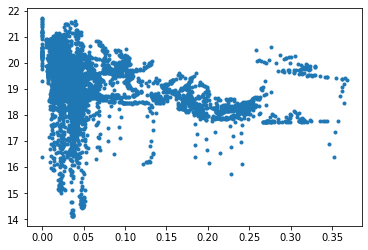

In [113]:
plot(data_aod[7548:16000,17],izana_value[900:16000-6648,5],'.')

print ('CORR:')
print ('c:',pearsonr(izana_value[900:16000-6648,8],data_aod[7548:16000,0]))
print ('r:',pearsonr(izana_value[900:16000-6648,8],data_aod[7548:16000,1]))
print ('g:',pearsonr(izana_value[900:16000-6648,8],data_aod[7548:16000,2]))
print ('b:',pearsonr(izana_value[900:16000-6648,8],data_aod[7548:16000,5]))
print ('y:',pearsonr(izana_value[900:16000-6648,8],data_aod[7548:16000,14]))
print ('y:',pearsonr(izana_value[900:16000-6648,8],data_aod[7548:16000,17]))



# DAY OF THE WEEK RADIANCE RELATIONSHIP